In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import platform
import random
import src.readFiles as readFiles
# Simulation data mount point
if platform.system() == "Darwin":
    # macOS
    topDir = "/Volumes/rahul_2TB/high_bidispersity/new_data/"
elif platform.system() == "Linux":
    topDir = "/media/rahul/rahul_2TB/high_bidispersity/new_data/"
else:
    raise OSError("Unsupported operating system")
    
plt.rcParams["text.usetex"]         = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"  
plt.rcParams["figure.autolayout"]   = True

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def draw_sphere(ax, x, z, r, base_color, light_dir=(-0.4, 0.6)):
    """
    Draw a 2D shaded sphere using a radial gradient.
    """
    N = 150
    y, xg = np.ogrid[-1:1:N*1j, -1:1:N*1j]
    d = np.sqrt(xg**2 + y**2)

    # mask outside circle
    mask = d <= 1

    # fake lighting (dot with light direction)
    lx, ly = light_dir
    lighting = (xg*lx + y*ly)
    lighting = (lighting - lighting.min()) / (lighting.max() - lighting.min())
    lighting = lighting**0.05   # < 1 → broader bright region
    
    # darker edges
    shading  = 0.3 + 0.7 * lighting
    shading *= (1 - 0.6*d)
    shading  = np.clip(shading, 0, 1)
    
    rgba = np.zeros((N, N, 4))
    color = np.array(plt.matplotlib.colors.to_rgb(base_color))
    rgba[..., :3] = color * shading[..., None]
    rgba[..., 3] = mask.astype(float)

    ax.imshow(rgba, extent=(x-r, x+r, z-r, z+r), origin='lower',
              interpolation='bilinear', zorder=0)

In [47]:
import os
import glob
import matplotlib               # type: ignore
import numpy             as np  # type: ignore
import matplotlib.pyplot as plt # type: ignore
import src.readFiles as readFiles
from tqdm import tqdm

'''
Aug 27, 2025 RVP - Added readFiles. Removed a code bug from the boudaries where
                   it painted all interactions with same color and thickness making
                   it look like 'crow's feet'.
Feb 5,  2025 RVP - Initial version of code.

This script produces snapshots of normal force interactions for a given range of strain units.
NOTE: Script creates a directory to store snapshots if it does not exist already
'''

# Input and output paths
topDir        = '/media/rahul/rahul_2TB/high_bidispersity/new_data/'
fig_save_path = '/home/rahul/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/3d/'

# Path errors.
print(f"Error: Path '{topDir}' not found. Check mount point") if not os.path.exists(topDir) else None
print(f"Error: Path '{fig_save_path}' not found. Check mount point") if not os.path.exists(fig_save_path) else None

# Simulation parameters
npp    = 1000
phi    = [0.78] #, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76]
ar     = [2.0]   #, 1.4, 1.8, 2.0, 4.0]
vr     = ['0.5']
numRun = 1

# Particles data file
particleFile    = 'par_*.dat' 
interactionFile = 'int_*.dat' 

plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"
plt.rcParams["figure.autolayout"]   = True
#matplotlib.use('Agg')

# Frame details
startFrame = 200
endFrame   = 205

maxLineWidth = 5.5

for j in range(len(phi)):
    phii = phi[j]
    phii = '{:.3f}'.format(phi[j]) if len(str(phi[j]).split('.')[1]) > 2 else '{:.2f}'.format(phi[j])
    for k in range(len(ar)):
        for l in range(len(vr)):
            dataname = f"{topDir}NP_{npp}/phi_{phii}/ar_{ar[k]}/Vr_{vr[l]}/run_{numRun}"
            if os.path.exists(dataname):
                intPath = open(glob.glob(f'{dataname}/{interactionFile}')[0])
                intList = readFiles.interactionsList(intPath)

                parPath  = open(glob.glob(f'{dataname}/{particleFile}')[0])
                parLines = parPath.readlines()
                parList1 = readFiles.readParFile(parPath)

                # box dimensions
                Lx = float(parLines[3].split()[2]) 
                Lz = float(parLines[3].split()[2])

                # setting up axis and box walls
                
                newLx = 2*Lx/4 + 2*ar[k]
                newLz = 2*Lz/4 + 2*ar[k]
                
                # getting the max force from the given range of frames
                maxForces = []
                for frame in range(startFrame, endFrame+1):
                    frameList = intList[frame]

                    normxij   = frameList[:,2]
                    normzij   = frameList[:,4]
                    lubNorm   = frameList[:,6]
                    lubTangx  = frameList[:,7]
                    lubTangz  = frameList[:,9]
                    contNorm  = frameList[:,11]
                    contTangx = frameList[:,12]
                    contTangz = frameList[:,14]
                    repulNorm = frameList[:,16]

                    normInts  = lubNorm + contNorm + repulNorm
                    tangInts  = np.linalg.norm(np.array([lubTangx + contTangx, lubTangz + contTangz]), axis=0)
                    totForce  = np.array([normInts, tangInts])
                    forceNorm = np.einsum('ij,ij->i', totForce.T, np.column_stack((normxij, normzij)))

                    maxForces.append(np.max(forceNorm))
                
                maxForce = np.max(maxForces)
                
                print("\n")
                # plotting frames
                for frame in tqdm(range(startFrame, endFrame), desc="Processing frames", unit="frame"):
                    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
                    
                    # position and radius data from par_*.dat
                    px = parList1[frame][:,2]
                    pz = parList1[frame][:,3]
                    pr = parList1[frame][:,1]
                    NP = len(pr)
                    
                    # interaction data from int_*.dat
                    frameList = intList[frame]
                    pi        = np.array([int(x) for x in frameList[:,0]])
                    pj        = np.array([int(x) for x in frameList[:,1]])

                    normxij   = frameList[:,2]
                    normzij   = frameList[:,4]
                    gapij     = frameList[:,5]
                    contState = frameList[:,10]
                    lubNorm   = frameList[:,6]
                    lubTangx  = frameList[:,7]
                    lubTangz  = frameList[:,9]
                    contNorm  = frameList[:,11]
                    contTangx = frameList[:,12]
                    contTangz = frameList[:,14]
                    repulNorm = frameList[:,16]

                    normInts  = lubNorm + contNorm + repulNorm
                    tangInts  = np.linalg.norm(np.array([lubTangx + contTangx, lubTangz + contTangz]), axis=0)
                    totForce  = np.array([normInts, tangInts])
                    forceNorm = np.einsum('ij,ij->i', totForce.T, np.column_stack((normxij, normzij)))

                    # plot parameters
                    numInts       = len(contState)
                    contLineWidth = np.array(forceNorm) * maxLineWidth / maxForce
                    intColor      = np.array(['#CC0000']*numInts, dtype=object) #CC0000
                    contLess      = np.array(contState == 0, dtype=bool)
                    fricLess      = np.array(contState == 1, dtype=bool)
                    if contLess.size > 0: intColor[contLess] = "#F77F00"
                    if fricLess.size > 0: intColor[fricLess] = 'tab:cyan' #'tab:cyan'
                        
                    boundIdx = set()
                    for i in range(NP):
                        condx = px[i] < Lx/4 and px[i] > -Lx/4
                        condz = pz[i] < Lz/4 and pz[i] > -Lz/4
                        if condx and condz:
                            boundIdx.add(i)
                    
                    for i in boundIdx:
                        if pr[i] == 1:
                            color = '#2A6F97'   # steel / ocean blue
                        else:
                            color = '#83C76F'   # muted terracotta orange F77F00

                        draw_sphere(ax, px[i], pz[i], pr[i], color)

                    # plotting interactions
                    for i in range(numInts):
                        if {pi[i], pj[i]} & boundIdx:
                            p1  = np.array([px[pi[i]], pz[pi[i]]])    # particle 1 position
                            p2  = np.array([px[pj[i]], pz[pj[i]]])    # particle 1 position
                            nij = np.array([normxij[i], normzij[i]])  # normal vector 1 to 2
                            pir = pr[pi[i]]
                            pjr = pr[pj[i]]
                            rij = nij * (gapij[i] + 2.) * (pir + pjr) * 0.5 # vector length between partcle 1 and 2
                            p11 = p1 + rij
                            ax.plot([p1[0], p11[0]],[p1[1], p11[1]], color=intColor[i], linewidth=contLineWidth[i], 
                                    solid_capstyle='round', solid_joinstyle='round', zorder = 100, alpha=0.8)
                           
                            if (np.sign(nij[0]) != np.sign((p2 - p1)[0])) or (np.sign(nij[1]) != np.sign((p2 - p1)[1])):
                                p22 = p2 - rij
                                ax.plot([p2[0], p22[0]], [p2[1], p22[1]], color=intColor[i], linewidth=contLineWidth[i], 
                                        solid_capstyle='round', solid_joinstyle='round', zorder = 100, alpha=0.8)
                        #fc = 0.5
                        ax.set_xlim([-(newLx/2),(newLx/2)])
                        ax.set_ylim([-(newLz/2),(newLz/2)])
                        #ax.set_title(fr'$\gamma = {frame/100:.2f}$', pad=10, fontweight='bold')
                        ax.axis('off')
                        ax.set_aspect('equal')
                        
                    directory = f'{fig_save_path}phi_{phii}_ar_{ar[k]}_vr_{vr[l]}_int_2d'
                    os.makedirs(directory, exist_ok=True)
                    #fig.set_size_inches(8, 8)
                    plt.rcParams['path.simplify'] = False
                    fig.savefig(f'{directory}/{frame}.png', dpi=500, bbox_inches='tight', pad_inches=0)
                    #print(f'>     Processed frame: {frame}/{endFrame-1}      ')
                    plt.close()
                    #plt.show()
                        
                plt.close('all')

Processing frames: 100%|███████████████████████| 5/5 [00:14<00:00,  2.83s/frame]


In [69]:
topDir = '/home/rahul/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/miscelleneous/sharepoint_Rahul_Brolin/new 3D data/Stress 10r/phi_0.55/ar_1.4/Vr_0.5/run_1/'

parfile = open(glob.glob(topDir + 'par*.dat')[0])
parDat = readFiles.readParFile(parfile)

In [71]:
parfile = open(glob.glob(topDir + 'par*.dat')[0])
parLines  = parfile.readlines()
float(parLines[3].split()[2])

22.3487

In [74]:
parLines[5].split()

['#', 'Lz', '22.3487']

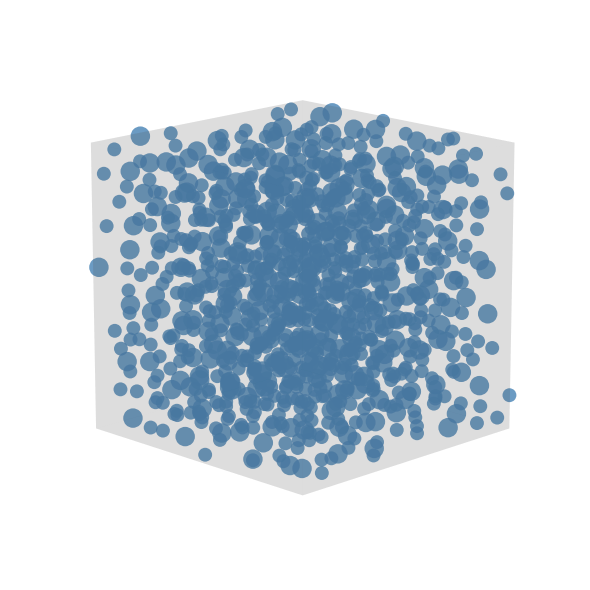

In [24]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

lx = 22.3487

frame = 100
x = parDat[frame][:, 2]
y = parDat[frame][:, 3]
z = parDat[frame][:, 4]
r = parDat[frame][:, 1]

ax.scatter(x, y, z, s=(r * 10)**2,     # scale marker area
    c='steelblue',alpha=0.8, edgecolors='none', depthshade=True)

ax.set_box_aspect([1, 1, 1])
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')
ax.view_init(elev=15, azim=45)
ax.grid(False)

ax.xaxis.pane.set_visible(False)
ax.yaxis.pane.set_visible(False)
ax.zaxis.pane.set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.set_axis_off()
draw_box(ax, (-lx/2, lx/2, -lx/2, lx/2, -lx/2, lx/2), alpha=0.07)
draw_box(ax, (-lx/2, lx/2, -lx/2, lx/2, -lx/2, lx/2), alpha=0.03, color='black')


plt.tight_layout()
plt.show()

In [18]:
import itertools
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def draw_box(ax, bounds, alpha=0.07, color='gray'):
    """
    Draw a translucent 3D box.

    bounds = (xmin, xmax, ymin, ymax, zmin, zmax)
    """
    xmin, xmax, ymin, ymax, zmin, zmax = bounds

    # 8 vertices of the cube
    vertices = np.array(list(itertools.product(
        [xmin, xmax], [ymin, ymax], [zmin, zmax]
    )))

    # 6 faces (each face is a list of 4 vertices)
    faces = [
        [vertices[j] for j in [0, 1, 3, 2]],  # bottom
        [vertices[j] for j in [4, 5, 7, 6]],  # top
        [vertices[j] for j in [0, 1, 5, 4]],  # front
        [vertices[j] for j in [2, 3, 7, 6]],  # back
        [vertices[j] for j in [0, 2, 6, 4]],  # left
        [vertices[j] for j in [1, 3, 7, 5]],  # right
    ]

    box = Poly3DCollection(
        faces,
        facecolors=color,
        edgecolors='none',
        alpha=alpha
    )

    ax.add_collection3d(box)


In [65]:
import pyvista as pv
import numpy as np
import gc

# Parameters / Particle data

for frame in range(100, 200):
    #frame = 100
    x = parDat[frame][:, 2]
    y = parDat[frame][:, 3]
    z = parDat[frame][:, 4]
    r = parDat[frame][:, 1]
    
    points = np.column_stack([x, y, z])
    lx = 22.3487  # box size
    
    opacity = np.ones(len(x))
    
    for i in range(len(x)):
        if np.any(points[i, :] > (lx/2)*0.95) or np.any(points[i, :] < (-lx/2)*0.95):
            opacity[i] = 0.3
        
    
    # Create sphere glyphs
    cloud = pv.PolyData(points)
    cloud["radius"] = r * 2
    
    spheres = cloud.glyph(
        geom=pv.Sphere(theta_resolution=64, phi_resolution=64),
        scale="radius",
        orient=False
    )
    
    
    # Create Plotter
    
    p = pv.Plotter()
    
    # for i, pt in enumerate(points):
    #     sphere = pv.Sphere(
    #         center=pt,
    #         radius=r[i],
    #         theta_resolution=64,
    #         phi_resolution=64
    #     )
    #     p.add_mesh(
    #         sphere,
    #         color="#9c8c49",
    #         smooth_shading=True,
    #         specular=0.8,
    #         specular_power=30,
    #         opacity=opacity[i],
    #     )
    
    p.add_mesh( spheres, color="#9c8c49", smooth_shading=True, specular=0.8, specular_power=30 )
    
    # Add translucent simulation box
    box = pv.Box(bounds=(-lx/2, lx/2, -lx/2, lx/2, -lx/2, lx/2))
    
    p.add_mesh(
        box,
        color="lightblue",    # face color
        opacity=0.2,         # face transparency
        style="surface",     # filled faces
        show_edges=True,     # show edges
        edge_color="black",  # edge color
        line_width=3         # edge thickness
    )
    
    
    # -----------------------------
    # Camera (like Matplotlib elev/azim)
    # -----------------------------
    distance = lx * 3.0
    elev = np.deg2rad(25)    # degrees to radians
    azim = np.deg2rad(305)
    
    cam_x = distance * np.cos(elev) * np.cos(azim)
    cam_y = distance * np.cos(elev) * np.sin(azim)
    cam_z = distance * np.sin(elev)
    
    p.camera_position = (
        (cam_x, cam_y, cam_z),  # camera location
        (0.5, -1.5, -2),              # focal point (center)
        (0, 0, 1)               # up vector
    )

    # Lighting
    light = pv.Light(
        position=(cam_x*1.05, cam_y*1.05, cam_z*2),   # light position
        focal_point=(0, 0, 0),
        intensity=0.8)
    p.add_light(light)
    
    
    ##################
    
    # -----------------------------
    # Flat arrows on top and bottom
    # -----------------------------
    
    top_arrow_start = (-lx*0.1, -lx*0.3, lx/2 + 0.1*lx)  # top face, slightly above
    
    top_arrow = pv.Arrow(
        start=top_arrow_start,
        direction=(1, 0, 0),
        tip_length=0.1,
        tip_radius=0.05,
        shaft_radius = 0.03,
        scale=10,
        tip_resolution=100,
        shaft_resolution=500
    )
    
    # Bottom arrow (lying flat on bottom face, along -x)
    bottom_arrow_start = (lx*0.1, -lx/2*1.1, -lx/2 - 1.5)  # bottom face, slightly below
    
    bottom_arrow = pv.Arrow(
        start=bottom_arrow_start,
        direction=(-1, 0, 0),
        tip_length=0.1,
        tip_radius=0.05,
        shaft_radius = 0.03,
        scale=10,
        tip_resolution=100,
        shaft_resolution=500
    )
    
    # Add arrows to plotter
    p.add_mesh(top_arrow, color="red", smooth_shading=True) 
    p.add_mesh(bottom_arrow, color="blue", smooth_shading=True)

    p.add_axes(line_width=2, color='black', labels_off=False)

    #p.set_background([1, 1, 1, 1])
    p.set_background("white")
    
    figsavepath = '/home/rahul/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/3d/phi_0.54'
    #p.export_pdf(f'{figsavepath}/frame_{frame}.pdf')
    p.screenshot(f'{figsavepath}/frame_{frame}.png', transparent_background=False, window_size=[1200,1200])
    #p.show()
    print(f'{frame}')
    p.close()
    del p
    gc.collect()

100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [220]:
cam_z

np.float64(30.22389998772599)

In [183]:
points.shape

(1000, 3)

In [198]:
opacity = np.ones(len(x))

In [200]:
for i in range(len(x)):
    if np.any(points[i, :] > (lx/2)*0.9) or np.any(points[i, :] < (-lx/2)*0.9):
        opacity[i] = 0.2

In [201]:
opacity

array([1. , 0.2, 1. , 1. , 1. , 0.2, 1. , 0.2, 0.2, 1. , 1. , 0.2, 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 0.2,
       1. , 1. , 1. , 0.2, 1. , 1. , 1. , 0.2, 1. , 1. , 0.2, 1. , 1. ,
       0.2, 0.2, 1. , 0.2, 1. , 1. , 0.2, 0.2, 1. , 0.2, 0.2, 0.2, 1. ,
       1. , 0.2, 1. , 1. , 1. , 1. , 1. , 1. , 0.2, 1. , 1. , 1. , 1. ,
       1. , 1. , 0.2, 1. , 1. , 0.2, 1. , 0.2, 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 0.2, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       0.2, 1. , 1. , 0.2, 1. , 0.2, 1. , 1. , 1. , 1. , 0.2, 1. , 1. ,
       1. , 0.2, 1. , 0.2, 1. , 1. , 0.2, 0.2, 1. , 1. , 1. , 1. , 1. ,
       1. , 0.2, 1. , 1. , 1. , 1. , 0.2, 1. , 0.2, 0.2, 1. , 1. , 1. ,
       0.2, 1. , 1. , 1. , 1. , 1. , 1. , 0.2, 0.2, 1. , 0.2, 1. , 1. ,
       0.2, 0.2, 0.2, 0.2, 1. , 1. , 1. , 1. , 1. , 1. , 0.2, 1. , 1. ,
       1. , 0.2, 0.2, 1. , 1. , 1. , 1. , 0.2, 1. , 1. , 0.2, 1. , 1. ,
       1. , 1. , 0.2, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 0.2, 1.

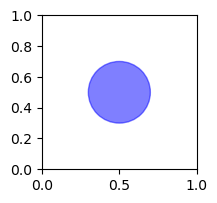

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(2, 2))

circle = plt.Circle((0.5, 0.5), 0.2, color='blue', alpha=0.5)
ax.add_patch(circle)
plt.show()

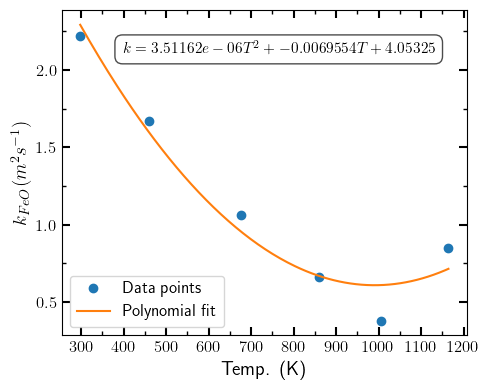

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# Data
temperature = np.array([298, 460, 676, 859, 1005, 1164])
values = np.array([2.22, 1.67, 1.06, 0.66, 0.38, 0.85])

# Polynomial fit (2nd order)
coeffs = np.polyfit(temperature, values, 2)
poly_eq = np.poly1d(coeffs)

# Equation as a string
eq_text = r"$k = {0:g} T^2 + {1:g} T + {2:g}$".format(*coeffs)

# Generate smooth line for plotting
x_fit = np.linspace(min(temperature), max(temperature), 200)
y_fit = poly_eq(x_fit)

# Plot
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(temperature, values, 'o', label='Data points')
ax.plot(x_fit, y_fit, '-', label='Polynomial fit')

# Set ticks
ax.xaxis.set_major_locator(MultipleLocator(100))
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(50))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))

# Add equation on the graph
ax.text(0.15, 0.9, eq_text, transform=ax.transAxes, fontsize=11,
        fontweight='bold', verticalalignment='top',
        bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.7))

# Increase font size and make labels bold
ax.set_xlabel('Temp. (K)', fontsize=14, fontweight='bold')
ax.set_ylabel(r'$k_{FeO} (m^2s^{-1})$', fontsize=14, fontweight='bold')

# Make ticks bold and slightly larger
ax.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=6, labelrotation=0, direction='in', right=True, top=True)
ax.tick_params(axis='both', which='minor', labelsize=10, width=1, length=3, direction='in', right=True, top=True)

# Optionally, increase legend font
ax.legend(loc='lower left', fontsize=12, frameon=True)
figsavepath = '/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/teaching/MATLAB_intro/Figures'
plt.savefig(f"{figsavepath}/polynomial_fit.pdf", dpi=300, bbox_inches='tight')

plt.show()

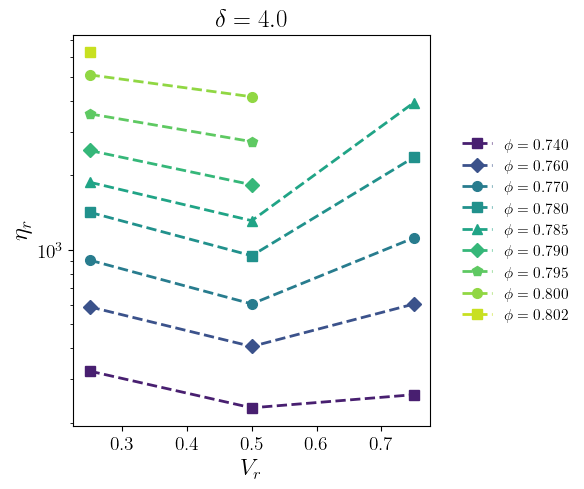

In [23]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import viridis

# -----------------------------
# Settings
# -----------------------------
line_markers = ['o', 's', '^', 'D', 'p']
marker_size = 7
line_width = 2

npp  = 1000
phiv = [0.72, 0.74, 0.75, 0.76, 0.765, 0.77, 0.78, 0.785, 0.79, 0.795, 0.8, 0.802, 0.82]
arr  = 1.4
vrr  = ['0.25', '0.5', '0.75']
numRuns = 2
off   = 100
#gamma = 10
#topDir = "/path/to/data"

# Viridis colormap setup
colors = viridis(np.linspace(0, 1, len(phiv)))

fig, ax = plt.subplots(figsize=(6, 5))

for j, phi in enumerate(phiv):
    phir = f"{phi:.3f}" if phi != round(phi, 2) else f"{phi:.2f}"
    visc = []
    for vrj in vrr:
        visc_list = []
        for run in range(numRuns):
            workDir = f"{topDir}/NP_{npp}/phi_{phir}/ar_{arr:.1f}/Vr_{vrj}/run_{run+1}/"
            if os.path.exists(workDir):
                data_files = glob.glob(os.path.join(workDir, "data_*.dat"))
                if not data_files:
                    continue
                data = np.loadtxt(data_files[0])
                jammed = np.any(data[:, 2] < 0)
                if len(data[:, 3]) > off and not jammed:
                    visc_val = np.mean(data[off:, 3])
                    visc_list.append(visc_val)
        visc.append(np.mean(visc_list) if visc_list else np.nan)
    
    visc_filtered = [x for x in visc if not np.isnan(x)]
    vrr_filtered  = [float(v) for x, v in zip(visc, vrr) if not np.isnan(x)]

    if visc_filtered:
        ax.plot(vrr_filtered, visc_filtered, linestyle='--',
                marker=line_markers[j % len(line_markers)],
                color=colors[j],
                linewidth=line_width,
                markersize=marker_size,
                label=fr'$\phi={phi:.3f}$')

# -----------------------------
# Formatting
# -----------------------------
ax.set_title(fr'$\delta = {arr:.1f}$', fontsize=18)
ax.set_xlabel(r'$V_r$', fontsize=17, fontstyle='italic')
ax.set_ylabel(r'$\eta_{r}$', fontsize=18, fontstyle='italic')
ax.tick_params(axis='both', labelsize=14)
ax.legend(frameon=False, fontsize=11, loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)
ax.grid(False)
ax.set_yscale('log')

plt.tight_layout()
plt.show()

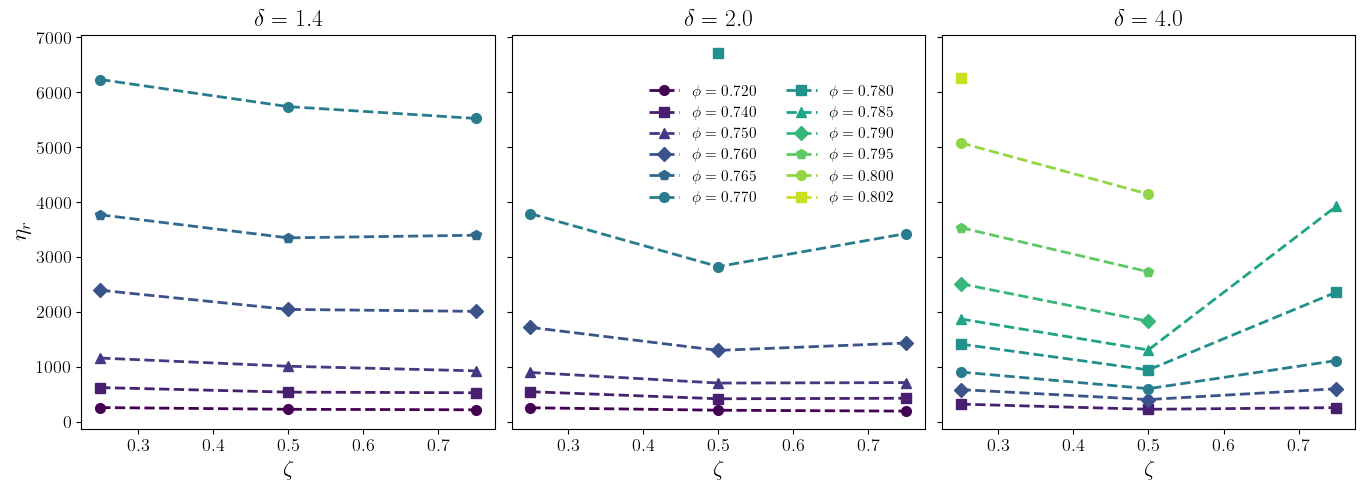

In [40]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import viridis

# -----------------------------
# Settings
# -----------------------------
line_markers = ['o', 's', '^', 'D', 'p']
marker_size = 7
line_width = 2

npp  = 1000
phiv = [0.72, 0.74, 0.75, 0.76, 0.765, 0.77, 0.78, 0.785, 0.79, 0.795, 0.8, 0.802, 0.82]
arr_list = [1.4, 2.0, 4.0]
vrr  = ['0.25', '0.5', '0.75']
numRuns = 2
off   = 100
#topDir = "/path/to/data"

# Viridis colormap
colors = viridis(np.linspace(0, 1, len(phiv)))

# -----------------------------
# Create 1x3 subplots
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

for a_idx, arr in enumerate(arr_list):
    ax = axes[a_idx]

    for j, phi in enumerate(phiv):
        phir = f"{phi:.3f}" if phi != round(phi, 2) else f"{phi:.2f}"
        visc = []
        for vrj in vrr:
            visc_list = []
            for run in range(numRuns):
                workDir = f"{topDir}/NP_{npp}/phi_{phir}/ar_{arr:.1f}/Vr_{vrj}/run_{run+1}/"
                if os.path.exists(workDir):
                    data_files = glob.glob(os.path.join(workDir, "data_*.dat"))
                    if not data_files:
                        continue
                    data = np.loadtxt(data_files[0])
                    jammed = np.any(data[:, 2] < 0)
                    if len(data[:, 3]) > off and not jammed:
                        visc_val = np.mean(data[off:, 3])
                        visc_list.append(visc_val)
            visc.append(np.mean(visc_list) if visc_list else np.nan)

        visc_filtered = [x for x in visc if not np.isnan(x)]
        vrr_filtered  = [float(v) for x, v in zip(visc, vrr) if not np.isnan(x)]

        if visc_filtered:
            ax.plot(vrr_filtered, visc_filtered, linestyle='--',
                    marker=line_markers[j % len(line_markers)],
                    color=colors[j],
                    linewidth=line_width,
                    markersize=marker_size,
                    label=fr'$\phi={phi:.3f}$')

    # -----------------------------
    # Formatting for each subplot
    # -----------------------------
    ax.set_title(fr'$\delta = {arr:.1f}$', fontsize=17)
    ax.set_xlabel(r'$\zeta$', fontsize=16, fontstyle='italic')
    ax.tick_params(axis='both', labelsize=13)
    #ax.set_yscale('log')
    ax.grid(False)

axes[0].set_ylabel(r'$\eta_{r}$', fontsize=17, fontstyle='italic')

# # Shared legend (only one)
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, frameon=False, fontsize=11, loc='center left', bbox_to_anchor=(0.48, 0.75), ncol=1)

# Shared legend from all axes
handles, labels = [], []
for ax in axes:
    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    labels.extend(l)

# Remove duplicates (optional, keeps legend clean)
unique = dict(zip(labels, handles))
fig.legend(unique.values(), unique.keys(),
           frameon=False, fontsize=11,
           loc='center left', bbox_to_anchor=(0.4, 0.7), ncol=2)

plt.tight_layout()
plt.subplots_adjust(right=0.85)  # space for legend


fig_save_path = '/home/rahul/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/viscosity/'
plt.savefig(f"{fig_save_path}/vrr_vs_visc.pdf", bbox_inches="tight", dpi=500)

plt.show()

In [4]:
def test_free_mem_zeros_arrays():
    # Create arrays with non-zero data
    arr1 = np.array([1, 2, 3, 4], dtype=np.int32)
    arr2 = np.array([[5.0, 6.0], [7.0, 8.0]], dtype=np.float64)
    
    # Call free_mem
    readFiles.free_mem(arr1, arr2)
    
    # Assert all elements are zero after calling free_mem
    assert np.all(arr1 == 0), "arr1 was not zeroed out"
    assert np.all(arr2 == 0), "arr2 was not zeroed out"

In [5]:
test_free_mem_zeros_arrays()

In [1]:
import readFiles
from   pathlib import Path
import glob
import numpy as np
import random
import numpy as np

def test_readParFile4():
    data = [np.array([
    [0, 1, -6.94832, -0.287701, 0.421004, 0, 2.76226, 0, 1.8458, 0, 0],
    [1, 1, 15.9122, -5.82255, -16.6717, 0, -0.256502, 0, 1.83494, 0, 0],
    [2, 1, 36.0294, 11.9706, 44.6729, 0, 1.01069, 0, 1.83261, 0, 0],
    [3, 1, -15.2673, -0.71701, 0.384757, 0, -0.597229, 0, 1.54845, 0, 0],
    [4, 1, -26.6757, 17.6198, 67.996, 0, 2.47818, 0, 1.26766, 0, 0],
    [5, 1, -30.6189, 28.9987, 112.927, 0, 4.4265, 0, 1.56611, 0, 0]]),
    np.array([
    [0, 1, -8.13108, -1.20098, -1.12063, 0, -1.59272, 0, 0.775525, 0, 1.19039],
    [1, 1, 9.90338, -6.83313, -2.01544, 0, 0.0829431, 0, 0.227265, 0, 0.736263],
    [2, 1, -25.4824, 11.6838, 3.89886, 0, 0.0024977, 0, 0.310855, 0, -0.272455],
    [3, 1, -18.5279, -2.45106, -0.478714, 0, 0.63809, 0, -0.580693, 0, 0.363456],
    [4, 1, -8.60271, 20.3819, 4.67049, 0, 1.3447, 0, 1.69814, 0, 0.368413],
    [5, 1, -4.16724, 31.294, 7.20103, 0, -0.0753068, 0, -2.25045, 0, -0.268695]]),
    np.array([
    [0, 1, -8.21288, -1.26632, -1.46194, 0, -1.40088, 0, 0.976844, 0, 1.22964],
    [1, 1, 9.80855, -6.82294, -2.19529, 0, 0.350074, 0, 0.288802, 0, 0.746443],
    [2, 1, -25.3285, 11.6786, 3.27815, 0, -0.22184, 0, 0.30429, 0, -0.259056],
    [3, 1, -18.5538, -2.43262, -1.03997, 0, -0.53329, 0, -0.0792144, 0, 0.341145],
    [4, 1, -8.40078, 20.4337, 4.34022, 0, 0.872488, 0, 1.27026, 0, 0.435025],
    [5, 1, -3.88117, 31.2704, 5.61757, 0, -1.56217, 0, 1.08328, 0, -0.320634]])]
    
    test_path = Path('/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/analysis/test_data')
    file_path = glob.glob(f'{test_path}/par_*test.dat')[0]
    parList   = readFiles.readParFile4(open(file_path), npp = 6)

    for a, b in zip(parList, data):
        np.testing.assert_array_equal(a, b)

In [2]:
test_readParFile4()

In [66]:
def test_readParFile3():
    data = [np.array([
    [0, 1, -6.94832, -0.287701, 0.421004, 0, 2.76226, 0, 1.8458, 0, 0],
    [1, 1, 15.9122, -5.82255, -16.6717, 0, -0.256502, 0, 1.83494, 0, 0],
    [2, 1, 36.0294, 11.9706, 44.6729, 0, 1.01069, 0, 1.83261, 0, 0],
    [3, 1, -15.2673, -0.71701, 0.384757, 0, -0.597229, 0, 1.54845, 0, 0],
    [4, 1, -26.6757, 17.6198, 67.996, 0, 2.47818, 0, 1.26766, 0, 0],
    [5, 1, -30.6189, 28.9987, 112.927, 0, 4.4265, 0, 1.56611, 0, 0]]),
    np.array([
    [0, 1, -8.13108, -1.20098, -1.12063, 0, -1.59272, 0, 0.775525, 0, 1.19039],
    [1, 1, 9.90338, -6.83313, -2.01544, 0, 0.0829431, 0, 0.227265, 0, 0.736263],
    [2, 1, -25.4824, 11.6838, 3.89886, 0, 0.0024977, 0, 0.310855, 0, -0.272455],
    [3, 1, -18.5279, -2.45106, -0.478714, 0, 0.63809, 0, -0.580693, 0, 0.363456],
    [4, 1, -8.60271, 20.3819, 4.67049, 0, 1.3447, 0, 1.69814, 0, 0.368413],
    [5, 1, -4.16724, 31.294, 7.20103, 0, -0.0753068, 0, -2.25045, 0, -0.268695]]),
    np.array([
    [0, 1, -8.21288, -1.26632, -1.46194, 0, -1.40088, 0, 0.976844, 0, 1.22964],
    [1, 1, 9.80855, -6.82294, -2.19529, 0, 0.350074, 0, 0.288802, 0, 0.746443],
    [2, 1, -25.3285, 11.6786, 3.27815, 0, -0.22184, 0, 0.30429, 0, -0.259056],
    [3, 1, -18.5538, -2.43262, -1.03997, 0, -0.53329, 0, -0.0792144, 0, 0.341145],
    [4, 1, -8.40078, 20.4337, 4.34022, 0, 0.872488, 0, 1.27026, 0, 0.435025],
    [5, 1, -3.88117, 31.2704, 5.61757, 0, -1.56217, 0, 1.08328, 0, -0.320634]])]
    
    test_path = Path('/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/analysis/test_data')
    file_path = glob.glob(f'{test_path}/par_*test.dat')[0]
    parList   = readFiles.readParFile3(open(file_path), final_strain = 0.02)

    for a, b in zip(parList, data):
        np.testing.assert_array_equal(a, b)

In [67]:
test_readParFile3()

In [69]:
test_path = Path('/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/analysis/test_data')
file_path = glob.glob(f'{test_path}/par_*test.dat')[0]
#parList   = readFiles.readParFile4(open(file_path), npp = 6)

In [70]:
data    = np.loadtxt(open(file_path), comments='#')

In [76]:
data.shape[0]/6

3.0

In [56]:
def test_readParFile2():
    data = [np.array([
    [0, 1, -6.94832, -0.287701, 0.421004, 0, 2.76226, 0, 1.8458, 0, 0],
    [1, 1, 15.9122, -5.82255, -16.6717, 0, -0.256502, 0, 1.83494, 0, 0],
    [2, 1, 36.0294, 11.9706, 44.6729, 0, 1.01069, 0, 1.83261, 0, 0],
    [3, 1, -15.2673, -0.71701, 0.384757, 0, -0.597229, 0, 1.54845, 0, 0],
    [4, 1, -26.6757, 17.6198, 67.996, 0, 2.47818, 0, 1.26766, 0, 0],
    [5, 1, -30.6189, 28.9987, 112.927, 0, 4.4265, 0, 1.56611, 0, 0]]),
    np.array([
    [0, 1, -8.13108, -1.20098, -1.12063, 0, -1.59272, 0, 0.775525, 0, 1.19039],
    [1, 1, 9.90338, -6.83313, -2.01544, 0, 0.0829431, 0, 0.227265, 0, 0.736263],
    [2, 1, -25.4824, 11.6838, 3.89886, 0, 0.0024977, 0, 0.310855, 0, -0.272455],
    [3, 1, -18.5279, -2.45106, -0.478714, 0, 0.63809, 0, -0.580693, 0, 0.363456],
    [4, 1, -8.60271, 20.3819, 4.67049, 0, 1.3447, 0, 1.69814, 0, 0.368413],
    [5, 1, -4.16724, 31.294, 7.20103, 0, -0.0753068, 0, -2.25045, 0, -0.268695]]),
    np.array([
    [0, 1, -8.21288, -1.26632, -1.46194, 0, -1.40088, 0, 0.976844, 0, 1.22964],
    [1, 1, 9.80855, -6.82294, -2.19529, 0, 0.350074, 0, 0.288802, 0, 0.746443],
    [2, 1, -25.3285, 11.6786, 3.27815, 0, -0.22184, 0, 0.30429, 0, -0.259056],
    [3, 1, -18.5538, -2.43262, -1.03997, 0, -0.53329, 0, -0.0792144, 0, 0.341145],
    [4, 1, -8.40078, 20.4337, 4.34022, 0, 0.872488, 0, 1.27026, 0, 0.435025],
    [5, 1, -3.88117, 31.2704, 5.61757, 0, -1.56217, 0, 1.08328, 0, -0.320634]])]
    
    test_path = Path('/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/analysis/test_data')
    file_path = glob.glob(f'{test_path}/par_*test.dat')[0]
    parList   = readFiles.readParFile2(file_path)

    for a, b in zip(parList, data):
        np.testing.assert_array_equal(a, b)

In [57]:
test_readParFile2()

In [54]:
def test_readParFile():
    data = [np.array([
    [0, 1, -6.94832, -0.287701, 0.421004, 0, 2.76226, 0, 1.8458, 0, 0],
    [1, 1, 15.9122, -5.82255, -16.6717, 0, -0.256502, 0, 1.83494, 0, 0],
    [2, 1, 36.0294, 11.9706, 44.6729, 0, 1.01069, 0, 1.83261, 0, 0],
    [3, 1, -15.2673, -0.71701, 0.384757, 0, -0.597229, 0, 1.54845, 0, 0],
    [4, 1, -26.6757, 17.6198, 67.996, 0, 2.47818, 0, 1.26766, 0, 0],
    [5, 1, -30.6189, 28.9987, 112.927, 0, 4.4265, 0, 1.56611, 0, 0]]),
    np.array([
    [0, 1, -8.13108, -1.20098, -1.12063, 0, -1.59272, 0, 0.775525, 0, 1.19039],
    [1, 1, 9.90338, -6.83313, -2.01544, 0, 0.0829431, 0, 0.227265, 0, 0.736263],
    [2, 1, -25.4824, 11.6838, 3.89886, 0, 0.0024977, 0, 0.310855, 0, -0.272455],
    [3, 1, -18.5279, -2.45106, -0.478714, 0, 0.63809, 0, -0.580693, 0, 0.363456],
    [4, 1, -8.60271, 20.3819, 4.67049, 0, 1.3447, 0, 1.69814, 0, 0.368413],
    [5, 1, -4.16724, 31.294, 7.20103, 0, -0.0753068, 0, -2.25045, 0, -0.268695]]),
    np.array([
    [0, 1, -8.21288, -1.26632, -1.46194, 0, -1.40088, 0, 0.976844, 0, 1.22964],
    [1, 1, 9.80855, -6.82294, -2.19529, 0, 0.350074, 0, 0.288802, 0, 0.746443],
    [2, 1, -25.3285, 11.6786, 3.27815, 0, -0.22184, 0, 0.30429, 0, -0.259056],
    [3, 1, -18.5538, -2.43262, -1.03997, 0, -0.53329, 0, -0.0792144, 0, 0.341145],
    [4, 1, -8.40078, 20.4337, 4.34022, 0, 0.872488, 0, 1.27026, 0, 0.435025],
    [5, 1, -3.88117, 31.2704, 5.61757, 0, -1.56217, 0, 1.08328, 0, -0.320634]])]
    
    test_path = Path('/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/analysis/test_data')
    file_path = glob.glob(f'{test_path}/par_*test.dat')[0]
    parList   = readFiles.readParFile(open(file_path))

    for a, b in zip(parList, data):
        np.testing.assert_array_equal(a, b)

In [55]:
test_readParFile()

In [50]:
def test_interactionsList():
    data = [np.array([
    [0, 891, 0.429056, 0, -0.903278, 0.0179601, 61.1331, -5.30821, 0, -2.5214, 0, 0, 0, 0, 0, 0, 0.379068],
    [0, 928, -0.99308, 0, 0.117444, 0.0173358, 32.701, -1.05412, 0, -8.91341, 0, 0, 0, 0, 0, 0, 0.38479],
    [0, 277, 0.305526, 0, 0.952184, 0.0178282, -12.766, 2.81001, 0, -0.901644, 0, 0, 0, 0, 0, 0, 0.350039],
    [0, 790, 0.992921, 0, 0.118778, 0.018714, -7.53486, -0.346116, 0, 2.89334, 0, 0, 0, 0, 0, 0, 0.372271],
    [1, 51, -0.849228, 0, -0.528026, 0.370001, -7.69429, 0.277562, 0, -0.446406, 0, 0, 0, 0, 0, 0, 0],
    [1, 997, -0.875928, 0, 0.482442, 0.0195719, 49.9058, -2.22647, 0, -4.04242, 0, 0, 0, 0, 0, 0, 0.364685],
    [1, 263, -0.0882054, 0, -0.996102, 0.124799, -12.9726, -4.15579, 0, 0.367998, 0, 0, 0, 0, 0, 0, 0.0412079],
    [1, 373, 0.998801, 0, -0.0489579, 0.117457, 7.68127, 0.0891717, 0, 1.81921, 0, 0, 0, 0, 0, 0, 0.0477254],
    [1, 882, 0.480419, 0, 0.877039, 0.0197062, -63.2718, 2.11505, 0, -1.15857, 0, 0, 0, 0, 0, 0, 0.363511],
    [2, 171, -0.996066, 0, 0.0886113, 0.0191557, -1.20976, -0.574336, 0, -6.45602, 0, 0, 0, 0, 0, 0, 0.340868],
    [2, 548, -0.0981543, 0, 0.995171, 0.019963, 1.06953, 7.92073, 0, 0.781226, 0, 0, 0, 0, 0, 0, 0.335408],
    [2, 519, 0.518431, 0, -0.85512, 0.0196108, 29.8601, -2.8973, 0, -1.75654, 0, 0, 0, 0, 0, 0, 0.337779]]),
    np.array([
    [0, 891, -0.387686, 0, -0.921792, -0.000620774, 0, 0, 0, 0, 2, 17.3855, 3.34303, 0, -1.40601, 0, 0.583333],
    [544, 987, -0.965542, 0, 0.260247, -0.00100389, 0, 0, 0, 0, 2, 28.7741, -2.50531, 0, -9.29495, 0, 0.583333],
    [140, 663, -0.0421651, 0, 0.999111, -0.00034203, 0, 0, 0, 0, 2, 9.45874, -10.9847, 0, -0.463583, 0, 0.583333],
    [287, 917, -0.0292224, 0, 0.999573, 0.138554, 2.31485, -0.651975, 0, -0.0190604, 0, 0, 0, 0, 0, 0, 0.0209775],
    [637, 978, 0.81575, 0, -0.578405, -0.00190128, 0, 0, 0, 0, 2, 51.6871, 3.81939, 0, 5.38665, 0, 0.583333],
    [1, 997, -0.12234, 0, 0.992488, -0.00084553, 0, 0, 0, 0, 2, 24.0285, -26.5413, 0, -3.27165, 0, 0.583333],
    [701, 791, 0.24242, 0, -0.970171, -0.00334231, 0, 0, 0, 0, 2, 131.81, -43.4331, 0, -10.8528, 0, 0.7],
    [1, 373, 0.796499, 0, -0.604639, 0.16974, -0.692444, 0.0294166, 0, 0.0387508, 0, 0, 0, 0, 0, 0, 0.0167736],
    [1, 882, 0.900114, 0, 0.435655, 0.00442566, -7.62161, 0.129789, 0, -0.268159, 0, 0, 0, 0, 0, 0, 0.524551],
    [168, 368, -0.259167, 0, 0.965833, 0.344576, 0.329678, 0.0909774, 0, 0.0244124, 0, 0, 0, 0, 0, 0, 0.000508182],
    [2, 548, 0.59232, 0, 0.805703, 0.00724076, -1.30006, 0.889782, 0, -0.654132, 0, 0, 0, 0, 0, 0, 0.432591],
    [287, 506, -0.490229, 0, -0.871594, 0.312347, -0.0544877, 0.165343, 0, -0.0929973, 0, 0, 0, 0, 0, 0, 0.000968176],
    [931, 957, 0.488719, 0, 0.872442, -0.00113329, 0, 0, 0, 0, 2, 44.3011, -5.21637, 0, 2.92207, 0, 0.7],
    [797, 927, -0.957037, 0, 0.289967, -0.000580239, 0, 0, 0, 0, 2, 22.6114, 5.77074, 0, 19.0463, 0, 0.7],
    [3, 547, 0.92241, 0, 0.386213, -0.000599011, 0, 0, 0, 0, 2, 11.1343, 6.74475, 0, -16.1088, 0, 0.5],
    [3, 590, -0.611653, 0, -0.791126, 0.38338, -0.217735, -0.00604272, 0, 0.00467188, 0, 0, 0, 0, 0, 0, 0]]),   
    np.array([
    [0, 891, -0.391516, 0, -0.920171, -0.000138442, 0, 0, 0, 0, 2, 3.12589, 7.46932, 0, -3.17806, 0, 0.583333],
    [544, 987, -0.967276, 0, 0.253727, -0.00127237, 0, 0, 0, 0, 2, 37.0393, -2.9697, 0, -11.3213, 0, 0.583333],
    [140, 663, -0.042719, 0, 0.999087, -3.73364e-05, 0, 0, 0, 0, 2, 1.12575, -1.66239, 0, -0.0710807, 0, 0.583333]])]
    
    test_path = Path('/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/analysis/test_data')
    file_path = glob.glob(f'{test_path}/int_*test.dat')[0]
    intList   = readFiles.interactionsList(open(file_path))

    for a, b in zip(intList, data):
        np.testing.assert_array_equal(a, b)

In [51]:
test_interactionsList()

In [49]:
data = [np.array([
    [0, 891, 0.429056, 0, -0.903278, 0.0179601, 61.1331, -5.30821, 0, -2.5214, 0, 0, 0, 0, 0, 0, 0.379068],
    [0, 928, -0.99308, 0, 0.117444, 0.0173358, 32.701, -1.05412, 0, -8.91341, 0, 0, 0, 0, 0, 0, 0.38479],
    [0, 277, 0.305526, 0, 0.952184, 0.0178282, -12.766, 2.81001, 0, -0.901644, 0, 0, 0, 0, 0, 0, 0.350039],
    [0, 790, 0.992921, 0, 0.118778, 0.018714, -7.53486, -0.346116, 0, 2.89334, 0, 0, 0, 0, 0, 0, 0.372271],
    [1, 51, -0.849228, 0, -0.528026, 0.370001, -7.69429, 0.277562, 0, -0.446406, 0, 0, 0, 0, 0, 0, 0],
    [1, 997, -0.875928, 0, 0.482442, 0.0195719, 49.9058, -2.22647, 0, -4.04242, 0, 0, 0, 0, 0, 0, 0.364685],
    [1, 263, -0.0882054, 0, -0.996102, 0.124799, -12.9726, -4.15579, 0, 0.367998, 0, 0, 0, 0, 0, 0, 0.0412079],
    [1, 373, 0.998801, 0, -0.0489579, 0.117457, 7.68127, 0.0891717, 0, 1.81921, 0, 0, 0, 0, 0, 0, 0.0477254],
    [1, 882, 0.480419, 0, 0.877039, 0.0197062, -63.2718, 2.11505, 0, -1.15857, 0, 0, 0, 0, 0, 0, 0.363511],
    [2, 171, -0.996066, 0, 0.0886113, 0.0191557, -1.20976, -0.574336, 0, -6.45602, 0, 0, 0, 0, 0, 0, 0.340868],
    [2, 548, -0.0981543, 0, 0.995171, 0.019963, 1.06953, 7.92073, 0, 0.781226, 0, 0, 0, 0, 0, 0, 0.335408],
    [2, 519, 0.518431, 0, -0.85512, 0.0196108, 29.8601, -2.8973, 0, -1.75654, 0, 0, 0, 0, 0, 0, 0.337779]]),
    np.array([
    [0, 891, -0.387686, 0, -0.921792, -0.000620774, 0, 0, 0, 0, 2, 17.3855, 3.34303, 0, -1.40601, 0, 0.583333],
    [544, 987, -0.965542, 0, 0.260247, -0.00100389, 0, 0, 0, 0, 2, 28.7741, -2.50531, 0, -9.29495, 0, 0.583333],
    [140, 663, -0.0421651, 0, 0.999111, -0.00034203, 0, 0, 0, 0, 2, 9.45874, -10.9847, 0, -0.463583, 0, 0.583333],
    [287, 917, -0.0292224, 0, 0.999573, 0.138554, 2.31485, -0.651975, 0, -0.0190604, 0, 0, 0, 0, 0, 0, 0.0209775],
    [637, 978, 0.81575, 0, -0.578405, -0.00190128, 0, 0, 0, 0, 2, 51.6871, 3.81939, 0, 5.38665, 0, 0.583333],
    [1, 997, -0.12234, 0, 0.992488, -0.00084553, 0, 0, 0, 0, 2, 24.0285, -26.5413, 0, -3.27165, 0, 0.583333],
    [701, 791, 0.24242, 0, -0.970171, -0.00334231, 0, 0, 0, 0, 2, 131.81, -43.4331, 0, -10.8528, 0, 0.7],
    [1, 373, 0.796499, 0, -0.604639, 0.16974, -0.692444, 0.0294166, 0, 0.0387508, 0, 0, 0, 0, 0, 0, 0.0167736],
    [1, 882, 0.900114, 0, 0.435655, 0.00442566, -7.62161, 0.129789, 0, -0.268159, 0, 0, 0, 0, 0, 0, 0.524551],
    [168, 368, -0.259167, 0, 0.965833, 0.344576, 0.329678, 0.0909774, 0, 0.0244124, 0, 0, 0, 0, 0, 0, 0.000508182],
    [2, 548, 0.59232, 0, 0.805703, 0.00724076, -1.30006, 0.889782, 0, -0.654132, 0, 0, 0, 0, 0, 0, 0.432591],
    [287, 506, -0.490229, 0, -0.871594, 0.312347, -0.0544877, 0.165343, 0, -0.0929973, 0, 0, 0, 0, 0, 0, 0.000968176],
    [931, 957, 0.488719, 0, 0.872442, -0.00113329, 0, 0, 0, 0, 2, 44.3011, -5.21637, 0, 2.92207, 0, 0.7],
    [797, 927, -0.957037, 0, 0.289967, -0.000580239, 0, 0, 0, 0, 2, 22.6114, 5.77074, 0, 19.0463, 0, 0.7],
    [3, 547, 0.92241, 0, 0.386213, -0.000599011, 0, 0, 0, 0, 2, 11.1343, 6.74475, 0, -16.1088, 0, 0.5],
    [3, 590, -0.611653, 0, -0.791126, 0.38338, -0.217735, -0.00604272, 0, 0.00467188, 0, 0, 0, 0, 0, 0, 0]]),   
    np.array([
    [0, 891, -0.391516, 0, -0.920171, -0.000138442, 0, 0, 0, 0, 2, 3.12589, 7.46932, 0, -3.17806, 0, 0.583333],
    [544, 987, -0.967276, 0, 0.253727, -0.00127237, 0, 0, 0, 0, 2, 37.0393, -2.9697, 0, -11.3213, 0, 0.583333],
    [140, 663, -0.042719, 0, 0.999087, -3.73364e-05, 0, 0, 0, 0, 2, 1.12575, -1.66239, 0, -0.0710807, 0, 0.583333]])]

data[0].shape

(12, 17)

In [35]:
import readFiles
from pathlib import Path
import glob
import numpy as np
import random
import numpy as np


def test_particleSizeList():
    data = np.array([1. , 1. , 1. , 1.4, 1.4, 1.4])
    
    test_path    = Path('/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/analysis/test_data')
    file_path    = glob.glob(f'{test_path}/random_seed_test.dat')[0]
    particleSize = readFiles.particleSizeList(open(file_path), sizeRatio=1.4)

    assert np.array_equal(particleSize, data)
    

def test_particleSizeList_mono():
    random.seed(42)  # Set seed for reproducibility
    particleSize = readFiles.particleSizeList(None, sizeRatio=1, npp=6)
    
    expected = [2, 1, 1, 2, 1, 2]  # whatever you get with seed 42
    assert particleSize == expected

In [33]:
random.seed(42)  # Set seed for reproducibility
particleSize = readFiles.particleSizeList(None, sizeRatio=1, npp=6)

expected = [2, 1, 1, 2, 1, 2]

In [34]:
particleSize

[2, 1, 1, 2, 1, 2]

In [36]:
test_particleSizeList()
test_particleSizeList_mono()

In [19]:
test_path    = Path('/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/analysis/test_data')
file_path    = glob.glob(f'{test_path}/random_seed_test.dat')[0]
particleSize = readFiles.particleSizeList(open(file_path), sizeRatio=1.4)

In [20]:
particleSize

array([1. , 1. , 1. , 1.4, 1.4, 1.4])

In [24]:
data = np.array([1. , 1. , 1. , 1.4, 1.4, 1.4])

In [25]:
data

array([1. , 1. , 1. , 1.4, 1.4, 1.4])

In [7]:
import readFiles
from pathlib import Path
import glob

def test_rigClusterList():
    data = [[174, 201, 174, 488, 201, 488],
        [206, 767, 206, 904, 767, 904],
        [318, 603, 318, 947, 603, 947],
        [135, 603, 135, 646, 318, 603, 318, 947, 603, 947, 646, 947],
        [206, 767, 206, 904, 767, 904],
        [41, 546, 41, 772, 546, 772],
        [83, 816, 83, 895, 816, 895],
        [84, 929, 84, 933, 84, 975, 190, 929, 190, 975, 933, 975],
        [135, 603, 135, 646, 318, 603, 318, 947, 603, 947, 646, 947],
        [323, 388, 323, 875, 388, 875],
        [337, 745, 337, 982, 745, 982],
        [434, 668, 434, 768, 668, 768],
        [41, 546, 41, 772, 401, 584, 401, 772, 546, 772, 584, 772],
        [69, 226, 69, 897, 226, 897],
        [83, 816, 83, 895, 816, 895],
        [84, 929, 84, 933, 84, 975, 190, 929, 190, 975, 933, 975],
        [135, 603, 135, 646, 318, 603, 318, 947, 603, 947, 646, 947],
        [323, 388, 323, 875, 388, 875],
        [327, 354, 327, 774, 354, 774],
        [434, 668, 434, 768, 668, 768],
        [41, 546, 41, 772, 401, 584, 401, 772, 546, 772, 584, 772],
        [64, 133, 64, 635, 133, 453, 133, 909, 453, 909, 635, 909],
        [69, 226, 69, 897, 226, 897],
        [83, 816, 83, 895, 816, 895],
        [84, 929, 84, 933, 84, 975, 190, 929, 190, 975, 933, 975],
        [135, 603, 135, 646, 318, 603, 318, 947, 603, 947, 646, 947]]

    test_path = Path('/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/analysis/test_data')
    file_path = glob.glob(f'{test_path}/rig_*test.dat')[0]
    rigList   = readFiles.rigClusterList(open(file_path))

    assert rigList == data

In [8]:
test_rigClusterList()

In [3]:
import readFiles
from pathlib import Path
import glob

def test_rigList():
    data = [[[0]],
            [[0]],
            [[174, 201, 174, 488, 201, 488],
            [206, 767, 206, 904, 767, 904],
            [318, 603, 318, 947, 603, 947]],
            [[135, 603, 135, 646, 318, 603, 318, 947, 603, 947, 646, 947],
            [206, 767, 206, 904, 767, 904]],
            [[41, 546, 41, 772, 546, 772],
            [83, 816, 83, 895, 816, 895],
            [84, 929, 84, 933, 84, 975, 190, 929, 190, 975, 933, 975],
            [135, 603, 135, 646, 318, 603, 318, 947, 603, 947, 646, 947],
            [323, 388, 323, 875, 388, 875],
            [337, 745, 337, 982, 745, 982],
            [434, 668, 434, 768, 668, 768]],
            [[41, 546, 41, 772, 401, 584, 401, 772, 546, 772, 584, 772],
            [69, 226, 69, 897, 226, 897],
            [83, 816, 83, 895, 816, 895],
            [84, 929, 84, 933, 84, 975, 190, 929, 190, 975, 933, 975],
            [135, 603, 135, 646, 318, 603, 318, 947, 603, 947, 646, 947],
            [323, 388, 323, 875, 388, 875],
            [327, 354, 327, 774, 354, 774],
            [434, 668, 434, 768, 668, 768]],
            [[41, 546, 41, 772, 401, 584, 401, 772, 546, 772, 584, 772],
            [64, 133, 64, 635, 133, 453, 133, 909, 453, 909, 635, 909],
            [69, 226, 69, 897, 226, 897],
            [83, 816, 83, 895, 816, 895],
            [84, 929, 84, 933, 84, 975, 190, 929, 190, 975, 933, 975],
            [135, 603, 135, 646, 318, 603, 318, 947, 603, 947, 646, 947]]]

    test_path = Path('/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/analysis/test_data')
    file_path = glob.glob(f'{test_path}/rig_*test.dat')[0]
    rigList   = readFiles.rigList(open(file_path))

    assert rigList == data

In [4]:
test_rigList()

In [5]:
test_path = Path('/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/analysis/test_data')
file_path = glob.glob(f'{test_path}/rig_*test.dat')[0]
rigList   = readFiles.rigList(open(file_path))

In [6]:
rigList

[[[0]],
 [[0]],
 [[174, 201, 174, 488, 201, 488],
  [206, 767, 206, 904, 767, 904],
  [318, 603, 318, 947, 603, 947]],
 [[135, 603, 135, 646, 318, 603, 318, 947, 603, 947, 646, 947],
  [206, 767, 206, 904, 767, 904]],
 [[41, 546, 41, 772, 546, 772],
  [83, 816, 83, 895, 816, 895],
  [84, 929, 84, 933, 84, 975, 190, 929, 190, 975, 933, 975],
  [135, 603, 135, 646, 318, 603, 318, 947, 603, 947, 646, 947],
  [323, 388, 323, 875, 388, 875],
  [337, 745, 337, 982, 745, 982],
  [434, 668, 434, 768, 668, 768]],
 [[41, 546, 41, 772, 401, 584, 401, 772, 546, 772, 584, 772],
  [69, 226, 69, 897, 226, 897],
  [83, 816, 83, 895, 816, 895],
  [84, 929, 84, 933, 84, 975, 190, 929, 190, 975, 933, 975],
  [135, 603, 135, 646, 318, 603, 318, 947, 603, 947, 646, 947],
  [323, 388, 323, 875, 388, 875],
  [327, 354, 327, 774, 354, 774],
  [434, 668, 434, 768, 668, 768]],
 [[41, 546, 41, 772, 401, 584, 401, 772, 546, 772, 584, 772],
  [64, 133, 64, 635, 133, 453, 133, 909, 453, 909, 635, 909],
  [69, 226, 

In [11]:
test_rigClusterList()

In [3]:
test_path = Path('/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/analysis/test_data')
file_path = glob.glob(f'{test_path}/rig_*test.dat')[0]
rigList   = readFiles.rigClusterList(open(file_path))

In [4]:
len(rigList)

26

In [7]:
len(data)

26

In [8]:
rigList

[[174, 201, 174, 488, 201, 488],
 [206, 767, 206, 904, 767, 904],
 [318, 603, 318, 947, 603, 947],
 [135, 603, 135, 646, 318, 603, 318, 947, 603, 947, 646, 947],
 [206, 767, 206, 904, 767, 904],
 [41, 546, 41, 772, 546, 772],
 [83, 816, 83, 895, 816, 895],
 [84, 929, 84, 933, 84, 975, 190, 929, 190, 975, 933, 975],
 [135, 603, 135, 646, 318, 603, 318, 947, 603, 947, 646, 947],
 [323, 388, 323, 875, 388, 875],
 [337, 745, 337, 982, 745, 982],
 [434, 668, 434, 768, 668, 768],
 [41, 546, 41, 772, 401, 584, 401, 772, 546, 772, 584, 772],
 [69, 226, 69, 897, 226, 897],
 [83, 816, 83, 895, 816, 895],
 [84, 929, 84, 933, 84, 975, 190, 929, 190, 975, 933, 975],
 [135, 603, 135, 646, 318, 603, 318, 947, 603, 947, 646, 947],
 [323, 388, 323, 875, 388, 875],
 [327, 354, 327, 774, 354, 774],
 [434, 668, 434, 768, 668, 768],
 [41, 546, 41, 772, 401, 584, 401, 772, 546, 772, 584, 772],
 [64, 133, 64, 635, 133, 453, 133, 909, 453, 909, 635, 909],
 [69, 226, 69, 897, 226, 897],
 [83, 816, 83, 895, 816

In [9]:
data = [[174, 201, 174, 488, 201, 488],
        [206, 767, 206, 904, 767, 904],
        [318, 603, 318, 947, 603, 947],
        [135, 603, 135, 646, 318, 603, 318, 947, 603, 947, 646, 947],
        [206, 767, 206, 904, 767, 904],
        [41, 546, 41, 772, 546, 772],
        [83, 816, 83, 895, 816, 895],
        [84, 929, 84, 933, 84, 975, 190, 929, 190, 975, 933, 975],
        [135, 603, 135, 646, 318, 603, 318, 947, 603, 947, 646, 947],
        [323, 388, 323, 875, 388, 875],
        [337, 745, 337, 982, 745, 982],
        [434, 668, 434, 768, 668, 768],
        [41, 546, 41, 772, 401, 584, 401, 772, 546, 772, 584, 772],
        [69, 226, 69, 897, 226, 897],
        [83, 816, 83, 895, 816, 895],
        [84, 929, 84, 933, 84, 975, 190, 929, 190, 975, 933, 975],
        [135, 603, 135, 646, 318, 603, 318, 947, 603, 947, 646, 947],
        [323, 388, 323, 875, 388, 875],
        [327, 354, 327, 774, 354, 774],
        [434, 668, 434, 768, 668, 768],
        [41, 546, 41, 772, 401, 584, 401, 772, 546, 772, 584, 772],
        [64, 133, 64, 635, 133, 453, 133, 909, 453, 909, 635, 909],
        [69, 226, 69, 897, 226, 897],
        [83, 816, 83, 895, 816, 895],
        [84, 929, 84, 933, 84, 975, 190, 929, 190, 975, 933, 975],
        [135, 603, 135, 646, 318, 603, 318, 947, 603, 947, 646, 947]]

In [22]:
rigFile   = (open(file_path))
hashCounter = -4
clusterIDs  = []
for line in rigFile:
    if line[0] == '#':
        hashCounter += 1
    elif hashCounter >= 0:
        IDs_string = line.split()[0]
        IDs_list   = [int(x.strip()) for x in IDs_string.split(',') if x.split()]
        if len(IDs_list) > 2:
            clusterIDs.append(IDs_list)

In [20]:
IDs_list

[135, 603, 135, 646, 318, 603, 318, 947, 603, 947, 646, 947]

In [23]:
clusterIDs

[[174, 201, 174, 488, 201, 488],
 [206, 767, 206, 904, 767, 904],
 [318, 603, 318, 947, 603, 947],
 [135, 603, 135, 646, 318, 603, 318, 947, 603, 947, 646, 947],
 [206, 767, 206, 904, 767, 904],
 [41, 546, 41, 772, 546, 772],
 [83, 816, 83, 895, 816, 895],
 [84, 929, 84, 933, 84, 975, 190, 929, 190, 975, 933, 975],
 [135, 603, 135, 646, 318, 603, 318, 947, 603, 947, 646, 947],
 [323, 388, 323, 875, 388, 875],
 [337, 745, 337, 982, 745, 982],
 [434, 668, 434, 768, 668, 768],
 [41, 546, 41, 772, 401, 584, 401, 772, 546, 772, 584, 772],
 [69, 226, 69, 897, 226, 897],
 [83, 816, 83, 895, 816, 895],
 [84, 929, 84, 933, 84, 975, 190, 929, 190, 975, 933, 975],
 [135, 603, 135, 646, 318, 603, 318, 947, 603, 947, 646, 947],
 [323, 388, 323, 875, 388, 875],
 [327, 354, 327, 774, 354, 774],
 [434, 668, 434, 768, 668, 768],
 [41, 546, 41, 772, 401, 584, 401, 772, 546, 772, 584, 772],
 [64, 133, 64, 635, 133, 453, 133, 909, 453, 909, 635, 909],
 [69, 226, 69, 897, 226, 897],
 [83, 816, 83, 895, 816

In [18]:
IDs_string[0].split()

['0']

In [89]:
npp  = 1000
runs = 1
phi  = [0.76]
vr   = ['0.5']
ar   = [1.4] #[1.0, 1.4, 2.0, 4.0]
off  = 0

for i, phii in enumerate(phi):
    phir = '{:.3f}'.format(phii) if len(str(phii).split('.')[1])>2 else '{:.2f}'.format(phii)
    for j, arj in enumerate(ar):
        for k, vrk in enumerate(vr):
            for l in range(runs):
                dataname = f"{topDir}NP_{npp}/phi_{phir}/ar_{arj}/Vr_{vrk}/run_{l+1}"
                parFile  = glob.glob(f'{dataname}/par_*')[0]
                datFile  = glob.glob(f'{dataname}/data_*')[0]
                parList  = readFiles.readParFile(open(parFile, 'r'))
                data     = np.loadtxt(datFile)
                
                lx = np.genfromtxt(datFile, skip_header=3, max_rows=1, comments = '_')[2]
                lz = np.genfromtxt(datFile, skip_header=5, max_rows=1, comments = '_')[2]
                

In [79]:
frame = 1200
sr    = data[frame, 2]
vx    = parList[frame][:, 4]
maxvx = max(vx)

In [83]:
sr

0.0388025

In [81]:
maxvx

2.4648

In [61]:

parfile = "/Users/rahul/Downloads/par_D2N2000VF0.79Bidi1.4_0.5Square_1_params_stress10r_shear.dat"
parFile = glob.glob(parfile)[0]
parList = readFiles.readParFile(open(parFile, 'r'))
                

In [62]:
## Angular velocity vs RELEVANT neighbouring <=k particle angular velocity
# normalized wrt shear rate

npp  = 1000
runs = 1
phi  = 0.77
vr   = '0.5'
ar   = 1.4 #[1.0, 1.4, 2.0, 4.0]
off  = 100
k    = 7  # max number of neighbors
phir = '{:.3f}'.format(phi) if len(str(phi).split('.')[1])>2 else '{:.2f}'.format(phi)

angvel_all      = []
neighAngVel_all = []
colors_all      = []
idxlen = []

for l in range(runs):
    dataname  = f"{topDir}/NP_{npp}/phi_{phir}/ar_{ar}/Vr_{vr}/run_{l+1}"  
    dataFile  = open(glob.glob(f'{dataname}/data_*.dat')[0], 'r')
    parFile   = open(glob.glob(f'{dataname}/par_*.dat' )[0], 'r')
    rigFile   = open(glob.glob(f'{dataname}/rig_*.dat' )[0], 'r')
    datdata   = np.genfromtxt(dataFile)
    pardata   = readFiles.readParFile(parFile)
    rigdata   = readFiles.rigList(rigFile)
    srate     = datdata[off:, 2]
    totStrain = datdata[-1, 1]
    parLines  = open(glob.glob(f'{dataname}/par_*.dat' )[0], 'r').readlines()

    lx = float(parLines[3].split()[2]) 
    lz = float(parLines[5].split()[2])
    
    for i, frame in enumerate(pardata[off:]):
        angvel = frame[:,8]
        pidx   = frame[:, 0]
        pr     = frame[:, 1]
        px     = frame[:, 2]
        pz     = frame[:, 3]
        sr     = srate[i]
        
        xmat, zmat = np.outer(px, np.ones(len(px))), np.outer(pz, np.ones(len(pz))) # broadcasting position array
        dxij, dzij = xmat.transpose() - xmat, zmat.transpose() - zmat        # distance matrix
        
        # Lees Edwards boundary:
        dxij[dzij > lz/2.]  -= sr*lx
        dzij[dzij > lz/2.]  -= lz
        
        dxij[dzij < -lz/2.] += sr*lx
        dzij[dzij < -lz/2.] += lz
        
        # X peridodic:
        dxij[dxij >  lx/2.] -= lx
        dxij[dxij < -lx/2.] += lx
    
        dij = np.sqrt(dxij**2 + dzij**2) # norm dist matrix
        
        for ii in pidx:
            sorted_indices = np.argsort(dij[:, int(ii)]) # all neighbors sorted by distance to particle ii
            within_cutoff  = dij[sorted_indices, int(ii)] <= 1.5 * (1+ar) # distance cuttoff
            idx = sorted_indices[within_cutoff][1:k+1]  # skip self # this list wont crash
            idxlen.append(len(idx))
            
            neighAngVel = np.mean(angvel[idx])     # mean ang vel of nearest neighbors
            neighAngVel_all.append(neighAngVel/sr) 

        rigList = [set(sum(rigFrame, [])) for rigFrame in rigdata]
        color   = np.array(['white'] * npp)
        color[list(rigList[off+i])] = 'r'

        angvel_all.extend(angvel/sr)
        colors_all.extend(list(color))

angvel_all      = np.array(angvel_all) - np.mean(angvel_all)
neighAngVel_all = np.array(neighAngVel_all) - np.mean(neighAngVel_all)

1201

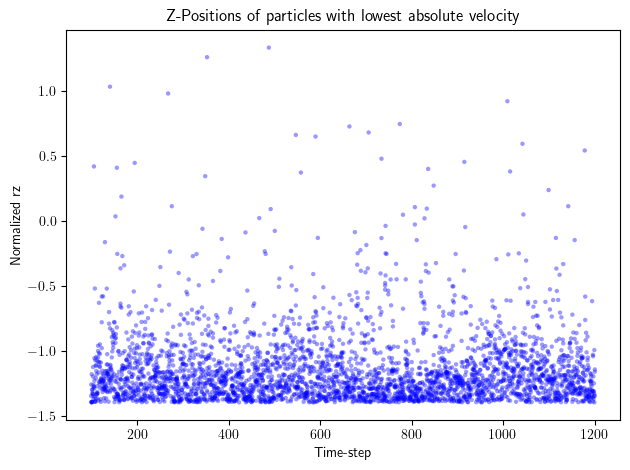

In [68]:
import numpy as np
import matplotlib.pyplot as plt

frame_range = range(100, 1201)
rz_min_all  = []  # To store rz of top 5 min vx particles
frame_all   = []   # Repeat frame index for each of the 5 particles
noElements  = 3

for frame in frame_range:
    vx = parList[frame][:, 4]
    rz = parList[frame][:, 3]
    
    sorted_indices = np.argsort(np.abs(vx))[:noElements]  # Indices of 5 particles with lowest  vx
    #sorted_indices = np.argsort(vx)[:noElements]
    rz_vals = rz[sorted_indices] / lx * 2  # Normalize as before
 
    rz_min_all.extend(rz_vals)
    frame_all.extend([frame] * noElements)

plt.scatter(frame_all, rz_min_all, s=10, c='blue', alpha=0.4,edgecolors='none', label='rz of 5 lowest vx particles')
plt.xlabel('Time-step')
plt.ylabel('Normalized rz')
plt.title('Z-Positions of particles with lowest absolute velocity')
#plt.legend()
plt.tight_layout()
plt.show()

In [93]:
frame = 1200
sr = data[frame, 2]
rz = parList[frame][:, 3]
vx = parList[frame][:, 4]

# Get indices of top 300 particles with highest rz
top_rz_indices = np.argsort(rz)[-100:]

# Extract their vx values
vx_top_rz = vx[top_rz_indices]

# Compute mean vx of these top-rz particles
mean_vx_top_rz = np.mean(vx_top_rz)

print(f"Mean vx of top 300 highest-rz particles at frame {frame}: {mean_vx_top_rz:.4f}")

Mean vx of top 300 highest-rz particles at frame 1200: 0.8536


In [96]:
sr *(lz/2 - 1)

0.83443126685

In [95]:
sr

0.0231809

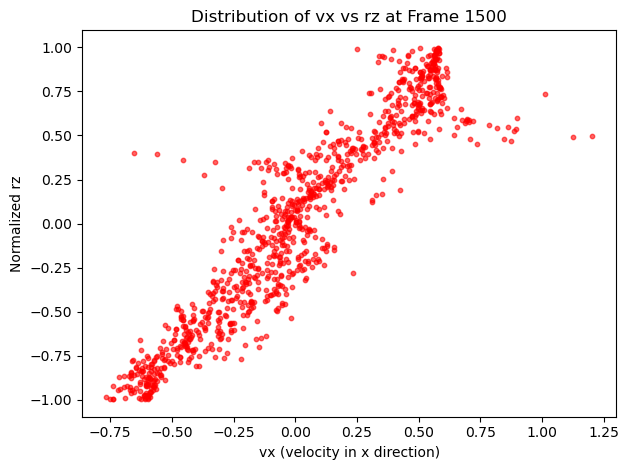

In [46]:
import numpy as np
import matplotlib.pyplot as plt

frame = 1500  # Choose your desired frame
vx = parList[frame][:, 4]
rz = parList[frame][:, 3]

# Optional: normalize rz if you want it scaled between -1 and 1
rz_normalized = rz / lx * 2

plt.scatter(vx, rz_normalized, s=10, alpha=0.6, c='red')
plt.ylabel('Normalized rz')
plt.xlabel('vx (velocity in x direction)')
plt.title(f'Distribution of vx vs rz at Frame {frame}')
plt.tight_layout()
plt.show()

In [49]:
min(vx)

-0.766378

In [21]:
frame = 1500
vx = parList[frame][:,4]
rz = list(parList[frame][:,3])

idx = np.argmin(vx)
rz[idx]

-35.4978

In [13]:
lx

73.993

In [18]:
max(rz)

36.9732

In [4]:
from collections import deque

d = deque([0, 1, 2, 3])
d.popleft() 

0

In [6]:
d[0]

1

In [3]:
import os
import platform
import shutil
import glob
from pathlib import Path

# Set base paths depending on OS
if platform.system() == 'Darwin':  # macOS
    topDir  = Path("/Volumes/rahul_2TB/high_bidispersity/new_data/")
    copyDir = Path("/Users/rahul/Library/CloudStorage/Box-Box/suspensions/2D_DATA/mu_infinity/sigma_100")
elif platform.system() == 'Linux':
    topDir  = Path("/media/rahul/rahul_2TB/high_bidispersity/new_data/")
    copyDir = Path("/media/rahul/CloudStorage/Box-Box/suspensions/2D_DATA/mu_infinity/sigma_100")
else:
    raise OSError("Unsupported OS")

# Parameters
npp  = 1000
runs = 1
phi  = [0.72, 0.74, 0.75, 0.76, 0.765, 0.77, 0.78]
vr   = ['0.5']
ar   = [1.4]
files = ['data_*.dat', 'int_*.dat', 'par_*.dat', 'rig_*.dat']

# Begin copy loop
for phii in phi:
    phir = '{:.3f}'.format(phii) if len(str(phii).split('.')[1]) > 2 else '{:.2f}'.format(phii)
    for arj in ar:
        for vrk in vr:
            for run in range(1, runs + 1):
                dataname = topDir / f"NP_{npp}" / f"phi_{phir}" / f"ar_{arj}" / f"Vr_{vrk}" / f"run_{run}"
                
                if dataname.exists():
                    for pattern in files:
                        for src_file in dataname.glob(pattern):
                            rel_path  = src_file.relative_to(topDir / f"NP_{npp}")
                            dest_path = copyDir / rel_path
                            
                            # Ensure destination folder exists
                            dest_path.parent.mkdir(parents=True, exist_ok=True)

                            # Copy the file
                            shutil.copy2(src_file, dest_path)
                    
                    print(f'Files copied to box for - phi_{phir}/ar_{arj}/Vr_{vrk}/run_{run}')

Files copied to box for - phi_0.72/ar_1.4/Vr_0.5/run_1
Files copied to box for - phi_0.74/ar_1.4/Vr_0.5/run_1
Files copied to box for - phi_0.75/ar_1.4/Vr_0.5/run_1
Files copied to box for - phi_0.76/ar_1.4/Vr_0.5/run_1
Files copied to box for - phi_0.765/ar_1.4/Vr_0.5/run_1
Files copied to box for - phi_0.77/ar_1.4/Vr_0.5/run_1


In [94]:
nums=[1,2,2,3,3,3]
k=2


In [100]:
import numpy as np
from collections import defaultdict

result     = defaultdict(int)
uniqueNums = np.unique(nums)

for num in uniqueNums:
    numCount          = nums.count(num)
    result[num] += numCount

result.values()[:k]

TypeError: 'dict_values' object is not subscriptable

In [109]:
(result.items())

dict_items([(1, 1), (2, 2), (3, 3)])

In [126]:
strs = [""]

In [124]:
strs = []

In [127]:
codeWord = ""
for word in strs:
    codeWord += word + " "

words = list(codeWord.split())
words

[]

In [114]:
codeWord

' '

In [116]:
if not words:
    print('emplty')

emplty


In [3]:
list('bar') == list('rab')

False

In [61]:
strs1  = strs
anafin = []
for i in range(len(strs1)):
    word   = list(strs1[i])
    ana    = [wordi]
    for j in range(i+1, len(strs1)):
        word1 = strs1[j]
        word2 = list(strs1[j])

        for k in word:
            if k in word2:
                word2.remove(k)

        if not word2:
            ana.append(word1)
            strs1.remove(word1)
    anafin.append(ana)

IndexError: list index out of range

In [68]:
strs=["act","pots","tops","cat","stop","hat"]

In [73]:
strs=["ac","c"]

In [71]:
finlist = []
for i in range(len(strs)):
    word1 = list(strs[i])
    ana   = [strs[i]]
    
    for j in range(i+1, len(strs)):
        wordd = strs[j]
        word2 = list(strs[j])
        
        if len(word1) == len(word2):
            for letter in word1:
                if letter in word2:
                    word2.remove(letter)

            if not word2:
                if not any(wordd in sublist for sublist in finlist):
                    ana.append(wordd)
                
    if not any(ana[0] in sublist for sublist in finlist):
        finlist.append(ana)

In [72]:
finlist

[['act', 'cat'], ['pots', 'tops', 'stop'], ['hat']]

In [75]:
res = defaultdict(list)

NameError: name 'defaultdict' is not defined

In [83]:
ord(np.array(list('sar')) - ord('a'))

UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U1'), dtype('int64')) -> None

In [85]:
from collections import defaultdict
res = defaultdict(list)

In [59]:
anafin

[['act', 'cat'], ['pots', 'tops'], ['stop'], ['hat']]

In [86]:
random_dict = {
    'apple': 42,
    'banana': 17,
    'cherry': 93,
    'date': 8,
    'elderberry': 65
}


In [92]:
sorted(random_dict.values(), reverse=True)[:2]

[93, 65]

In [50]:
for i in range(3,7):
    print(i)

3
4
5
6


In [93]:
strs = [1,2,3,4,5,6,6,6,6]
strs.count(6)

4

In [28]:
anafin

[['act', 'cat'], ['pots', 'tops'], ['stop'], ['hat']]

In [29]:
strs1

['act', 'pots', 'stop', 'hat']

In [15]:
piles=[1,4,3,2]
h=9

In [12]:
import numpy as np
piles_sort = np.arange(np.min(piles), np.max(piles) + 1) #sorted(piles)

if h > len(piles):
    for k in piles_sort:
        t = np.sum([np.ceil(i/k) for i in piles])
        
        if t <= h:
            kk = int(k)
            break

else:
    kk= int(max(piles))

kk

2

In [17]:
for k in range(1, max(piles) + 1):
    t = sum(np.ceil(p / k) for p in piles)
    if t <= h:
        kk = int(k)
        break

kk

2

In [8]:
np.sum([np.ceil(i/4) for i in piles])

8.0

In [13]:
piles_sort

array([1, 2, 3, 4])

In [151]:
import os
import glob
import numpy as np      # type: ignore
from   tqdm import tqdm # type: ignore
import readFiles  

In [190]:
npp      = 1000
phi      = [0.77]
ar       = [1.4]
vr       = '0.5'
numRuns  = 1

topDir      = "/media/rahul/rahul_2TB/high_bidispersity/new_data"
sizePair = 'sl'
# PDF parameters
dr  = 5  # in unit length
off = 1900  # no. of timesteps to skip for steady state

for j in range(len(phi)):
    phir = '{:.3f}'.format(phi[j]) if len(str(phi[j]).split('.')[1])>2 else '{:.2f}'.format(phi[j])
    if ar[j] == 1 and sizePair != 'all':
        print(f"     Skipping since ar = 1 and not all pairs are considered (phi = {phir})\n")
        continue  # Skip the rest of this iteration of the 'ar' loop
    for l in range (numRuns):
        dataname = f'{topDir}/NP_{npp}/phi_{phir}/ar_{ar[j]}/Vr_{vr}/run_{l+1}'
        if os.path.exists(dataname):
            if os.path.exists(f'{dataname}/PDF_{sizePair}_g_r_theta.txt'):
                print(f'     PDF file already exists skipping - phi_{phir}/ar_{ar[j]}/Vr_{vr}/run_{l+1}\n')
                continue
            print(f'  Working on - phi_{phir}/ar_{ar[j]}/Vr_{vr}/run_{l+1}\n')
            ranSeedFile = glob.glob(f'{dataname}/random_*.dat')[0] #"random_seed.dat"
            datFile     = glob.glob(f'{dataname}/data_*')[0]
            parFile     = glob.glob(f'{dataname}/par_*')[0]
    
            # Readind particle sizes and reading parameters files into a list
            particleSize = np.genfromtxt(ranSeedFile, skip_header=2, usecols=-1)
            parList      = readFiles.parametersList(parFile)
    
            # Box dimensions
            lx = np.genfromtxt(datFile, skip_header=3, max_rows=1, comments = '_')[2]
            lz = np.genfromtxt(datFile, skip_header=5, max_rows=1, comments = '_')[2]
    
            # Reading simulation results
            data = np.loadtxt(datFile, skiprows=37).transpose()
            gamma, minGap = data[1], data[13]
    
            # Bin parameters
            rmin    = (np.max(particleSize) + np.min(minGap)) if sizePair == 'll' else (np.min(particleSize) + np.min(minGap))
            rmax    = np.max([lx,lz])/2.
            rbin    = np.arange(rmin, rmax + dr, dr)
            pixSurf = dr**2
            gxy     = np.zeros((len(rbin), len(rbin))) # initializing the PDF array
            SSi     = parList[off:] # parameter arrays for all time steps to consider
    
            for _, (ii, mat) in tqdm(enumerate(enumerate(SSi)), desc="Progress", leave=False, total=len(SSi)):
                xp, zp, rp = mat[:,2], mat[:,3], mat[:,1] # all particle co-ordinates and radii
    
                if sizePair in ['ss', 'll']:
                    cond   = (rp == 1) if sizePair == 'ss' else None
                    cond   = (rp  > 1) if sizePair == 'll' else None
                    xp, zp = xp[cond], zp[cond]
    
                # Inter-particle distances array 
                xmat, zmat = np.outer(xp, np.ones(len(xp))), np.outer(zp, np.ones(len(xp)))
                dxij, dzij = xmat.transpose() - xmat,        zmat.transpose() - zmat
                
                # Lees Edwards boundary:
                dxij[dzij > lz/2.]  -= gamma[ii]*lx
                dzij[dzij > lz/2.]  -= lz
                
                dxij[dzij < -lz/2.] += gamma[ii]*lx
                dzij[dzij < -lz/2.] += lz
                
                # X peridodic:
                dxij[dxij >  lx/2.] -= lx
                dxij[dxij < -lx/2.] += lx
            
                if sizePair == 'sl':
                    for im in range(dij.shape[0]):
                        for ikk in range(dij.shape[1]):
                            cond2 = (mat[im,1] != mat[ikk,1])
                            dxij[im, ikk] *= cond2
                            dzij[im, ikk] *= cond2
    
                del xp, zp, xmat, zmat
                for ij in range(len(rbin[0:-1])):
                    for ik in range(len(rbin[0:-1])):
                        condxy = ((dxij >= rbin[ij]) & (dxij < rbin[ij] + dr) &
                                  (dzij >= rbin[ik]) & (dzij < rbin[ik] + dr))
                        gxy[ij, ik] += np.sum(condxy)/pixSurf
                        
            gxy /= len(SSi)
            gxy /= np.mean(gxy)
        
            # Writing the calculated PDF array into a text file
            txtFile = open(f'{dataname}/PDF_{sizePair}_gxy.txt', 'w')
            txtFile.write('# x bins \n')
            txtFile.write(" ".join(map(str, rbin)))
            txtFile.write("\n\n")
    
            txtFile.write('# y bins \n')
            txtFile.write(" ".join(map(str, rbin)))
            txtFile.write("\n\n")
    
            txtFile.write("\n".join(" ".join(map(str, row)) for row in gxy) + "\n")
            txtFile.close()
    
            print(f'\n    Done - NP_{str(npp)}/phi_{phir}/ar_{str(ar[j])}/Vr_{vr}/run_{l+1}\n')
            #del gxy
            
        else:
            print(f'{dataname} - Not found')

  Working on - phi_0.77/ar_1.4/Vr_0.5/run_1




    Done - NP_1000/phi_0.77/ar_1.4/Vr_0.5/run_1



In [191]:
lz

73.511

In [189]:
np.max(gxy)

1.5892659825364734

In [186]:
np.min(gxy)

0.0

In [178]:
np.mean(gxy)

0.6292212952321532

In [187]:
np.mean(gxy)

1.0

In [185]:
np.max(gxy)

1.5892659825364737

In [91]:
target=13
position=[10,2,5,7,4,6,11]
speed=[7,5,10,5,9,4,1]

In [39]:
import numpy as np

xvsort = sorted(zip(position, speed))
x      = [p for p, _ in xvsort][::-1]
v      = [s for _, s in xvsort][::-1]

print(x, v)

[11, 10, 7, 6, 5, 4, 2] [1, 7, 5, 4, 10, 9, 5]


In [46]:
import numpy as np

xvsort = sorted(zip(position, speed))
x      = [p for p, _ in xvsort][::-1]
v      = [s for _, s in xvsort][::-1]

fleet = [1]

for i in range(len(position)-1):
    relvel  = v[i] - v[i+1]
    reldist = x[i] - x[i+1]
    
    if relvel < 0:
        cattime   = abs(reldist/relvel)
        needdist  = v[i]* cattime
        availdist = target - x[i]

        if needdist <= availdist:
            fleet[-1] += 1
            xt      = [i+j*cattime for i,j in zip(x,v)]
            v[i+1] = v[i]
            xvsort = sorted(zip(xt, v))
            x      = [p for p, _ in xvsort][::-1]
            v      = [s for _, s in xvsort][::-1]

        else:
            fleet.append(1)

    else:
        fleet.append(1)

In [102]:
target=10
position=[1,4]
speed=[3,2]
exp = 

In [110]:
target=10
position=[4,1,0,7]
speed=[2,2,1,1]
exp = 3

In [133]:
target=17
position=[8,12,16,11,7]
speed=[6,9,10,9,7]
exp =4

In [136]:
xvsort = sorted(zip(position, speed))
x      = np.array([p for p, _ in xvsort][::-1])
v      = np.array([s for _, s in xvsort][::-1])

fleet   = [0]
indices = list(range(0, len(x)))

while np.any(x < target):
    x = x + v * 0.1
    for j in range(len(x)-1):
        if x[j+1] >= x[j]:
            x[j+1] = x[j]
            v[j+1] = v[j]
             
    fleet[-1] += np.sum(x[indices] >= target)
    indices    = np.where(x < target)[0] 
    fleet.append(0) if fleet[-1] > 0 else None
    print(x)

[17.  12.9 11.9  8.6  7.7]
[18.  13.8 12.8  9.2  8.4]
[19.  14.7 13.7  9.8  9.1]
[20.  15.6 14.6 10.4  9.8]
[21.  16.5 15.5 11.  10.5]
[22.  17.4 16.4 11.6 11.2]
[23.  18.3 17.3 12.2 11.9]
[24.  19.2 18.2 12.8 12.6]
[25.  20.1 19.1 13.4 13.3]
[26. 21. 20. 14. 14.]
[27.  21.9 20.9 14.6 14.6]
[28.  22.8 21.8 15.2 15.2]
[29.  23.7 22.7 15.8 15.8]
[30.  24.6 23.6 16.4 16.4]
[31.  25.5 24.5 17.  17. ]
[32.  26.4 25.4 17.6 17.6]


In [137]:
fleet

[1, 1, 1, 2, 0]

In [118]:
np.any(x < target)

True

In [128]:
x + v * 0.5

array([10.,  9.,  8.,  7.,  6.,  5.])

In [113]:
x

array([11, 11,  9,  4])

In [ ]:
## old

import numpy as np

        xvsort = sorted(zip(position, speed))
        x      = [p for p, _ in xvsort][::-1]
        v      = [s for _, s in xvsort][::-1]

        fleet = [1]

        for i in range(len(position)-1):
            relvel  = v[i] - v[i+1]
            reldist = x[i] - x[i+1]
            
            if relvel < 0:
                cattime   = abs(reldist/relvel)
                needdist  = v[i]* cattime
                availdist = target - x[i]

                if needdist <= availdist:
                    fleet[-1] += 1
                    x      = [i+j*cattime for i,j in zip(x,v)]
                    v[i+1] = v[i]

                else:
                    fleet.append(1)

            else:
                fleet.append(1)
    
        return int(len(fleet))

In [12]:
import numpy as np

xvsort = sorted(zip(position, speed))
x      = [p for p, _ in xvsort]
v      = [s for _, s in xvsort]

fleet = [1]

for i in range(len(position)-1):
    relVel = v[-i-1] - v[-i-2]
    if relVel < 0:
        cattime   = abs((x[-i-1] - x[-i-2])/(v[-i-1] - v[-i-2]))
        needDist  = v[-i-1] * cattime
        availDist = target - x[-i-1]

        if needDist <= availDist:
            #v[-i-2]    = v[-i-1]
            fleet[-1] += 1

        else:
            fleet.append(1)

    else:
        fleet.append(1) 

In [ ]:
import numpy as np

xvsort = sorted(zip(position, speed))
x      = [p for p, _ in xvsort]
v      = [s for _, s in xvsort]

fleet = [1]
l = len(position)

def relVel(i, j):
    return v[i] - v[j]

for index in range(l - 1):
    i = index
    j = index + 1
    #relVel = v[-i-1] - v[-i-2]
    if relVel(i, j) < 0:
        cattime   = abs((x[j] - x[i])/relVel(i, j))
        needDist  = v[j] * cattime
        availDist = target - x[j]

        if needDist <= availDist:
            fleet[-1] += 1
            
        else:
            for k in range(j, l+1):
                if relVel(i, j) < 0:
                    cattime   = abs((x[j] - x[i])/relVel(i, j))
                    needDist  = v[j] * cattime
                    availDist = target - x[j]
            
                    if needDist <= availDist:
                        fleet[-1] += 1
                            
                        fleet.append(1)

    else:
        fleet.append(1) 

In [14]:
fleet

[2, 1, 1]

In [25]:
v

[1, 1, 1, 1]

In [16]:
needDist

1.0

In [17]:
availDist

6

In [9]:
kl = open('/Volumes/rahul_2TB/high_bidispersity/new_data/NP_1000/phi_0.74/ar_1.4/Vr_0.5/run_1/F_prime_rig.txt')
kk = np.array(kl.readlines())

In [15]:
import numpy as np

data = np.loadtxt('/Volumes/rahul_2TB/high_bidispersity/new_data/NP_1000/phi_0.74/ar_1.4/Vr_0.5/run_1/F_prime_rig.txt', skiprows=1)

In [18]:
data[:,1]

(2001,)

In [5]:
import os
import glob
import matplotlib               # type: ignore
import numpy             as np  # type: ignore
import matplotlib.pyplot as plt # type: ignore

'''
Feb 5, 2025
RVP

This script produces snapshots of normal force interactions for a given range of strain units.
NOTE: Script creates a directory to store snapshots if it does not exist already
'''

# Input and output paths
topDir        = '/media/rahul/rahul_2TB/high_bidispersity/new_data/flow_curves/stress_200r/'
fig_save_path = '/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/movies/interactions/media_michel/'

# Path errors.
print(f"Error: Path '{topDir}' not found. Check mount point") if not os.path.exists(topDir) else None
print(f"Error: Path '{fig_save_path}' not found. Check mount point") if not os.path.exists(fig_save_path) else None

# Simulation parameters
npp    = 1000
phi    = [0.765] #, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76]
ar     = [1.4]  #, 1.4, 1.8, 2.0, 4.0]
vr     = ['0.5']
numRun = 1

# Particles data file
particleFile    = 'par_*.dat' 
interactionFile = 'int_*.dat' 

plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"
plt.rcParams["figure.autolayout"]   = True
matplotlib.use('Agg')

"====================================================================================================================================="

def parList(particleFile):
    '''
    Function to read parameters file (par*.dat). We read this file to get 
    particle positions
    '''
    particleFile.seek(0)
    hashCounter   = 0
    temp          = []
    particlesList = []

    fileLines = particleFile.readlines()[22:] # skipping the comment lines

    for line in fileLines:
        if not line.split()[0] == '#':
            lineList = [float(value) for value in line.split()]
            temp.append(lineList)
        else:
            # Checking if counter reaches 7 (7 lines of comments after every timestep data).
            hashCounter += 1 
            if hashCounter == 7: 
                particlesList.append(np.array(temp))
                temp        = []
                hashCounter = 0
    particleFile.close()
    return particlesList

def interactionsList(interactionFile):
    '''
    This function reads the interaction file and creates a nested-list,
    each list inside contains the array of all interaction parameters for
    that timestep.

    Input: interactionFile - the location of the interaction data file
    '''

    hashCounter = 0
    temp        = []
    contactList = [] # list with interaction parameters for each element at each timestep

    fileLines = interactionFile.readlines()[27:] # skipping the comment lines
    for line in fileLines:
        if not line.split()[0] == '#':
            lineList = [float(value) for value in line.split()]
            temp.append(lineList)
        else:
            hashCounter += 1 # checking if counter reaches 7 (7 lines of comments after every timestep data)
            if hashCounter == 7: 
                contactList.append(np.array(temp))
                temp        = []
                hashCounter = 0
    interactionFile.close()
    return contactList

"====================================================================================================================================="

# Frame details
startFrame = 600
endFrame   = 610

maxLineWidth = 5.5

for j in range(len(phi)):
    phii = phi[j]
    phii = '{:.3f}'.format(phi[j]) if len(str(phi[j]).split('.')[1]) > 2 else '{:.2f}'.format(phi[j])
    for k in range(len(ar)):
        for l in range(len(vr)):
            dataname = f"{topDir}NP_{npp}/phi_{phii}/ar_{ar[k]}/Vr_{vr[l]}/run_{numRun}"
            if os.path.exists(dataname):
                intPath = open(glob.glob(f'{dataname}/{interactionFile}')[0])
                intList = interactionsList(intPath)

                parPath  = open(glob.glob(f'{dataname}/{particleFile}')[0])
                parLines = parPath.readlines()
                parList1 = parList(parPath)

                # box dimensions
                Lx = float(parLines[3].split()[2]) 
                Lz = float(parLines[3].split()[2])

                # setting up axis and box walls
                _, ax = plt.subplots(1, 1, figsize=(5,5), dpi = 500)
                newLx = Lx + 2*ar[k]
                newLz = Lz + 2*ar[k]
                
                # getting the max force from the given range of frames
                maxForces = []
                for frame in range(startFrame, endFrame):
                    frameList = intList[frame]

                    normxij   = frameList[:,2]
                    normzij   = frameList[:,4]
                    lubNorm   = frameList[:,6]
                    lubTangx  = frameList[:,7]
                    lubTangz  = frameList[:,9]
                    contNorm  = frameList[:,11]
                    contTangx = frameList[:,12]
                    contTangz = frameList[:,14]
                    repulNorm = frameList[:,16]

                    normInts  = lubNorm + contNorm + repulNorm
                    tangInts  = np.linalg.norm(np.array([lubTangx + contTangx, lubTangz + contTangz]), axis=0)
                    totForce  = np.array([normInts, tangInts])
                    forceNorm = np.einsum('ij,ij->i', totForce.T, np.column_stack((normxij, normzij)))

                    maxForces.append(np.max(forceNorm))
                
                maxForce = np.max(maxForces)
                
                print("\n")
                # plotting frames
                for frame in range(startFrame, endFrame):
                    # position and radius data from par_*.dat
                    px = parList1[frame][:,2]
                    pz = parList1[frame][:,3]
                    pr = parList1[frame][:,1]
                    NP = len(pr)
                    
                    # interaction data from int_*.dat
                    frameList = intList[frame]
                    pi        = np.array([int(x) for x in frameList[:,0]])
                    pj        = np.array([int(x) for x in frameList[:,1]])

                    normxij   = frameList[:,2]
                    normzij   = frameList[:,4]
                    gapij     = frameList[:,5]
                    contState = frameList[:,10]
                    lubNorm   = frameList[:,6]
                    lubTangx  = frameList[:,7]
                    lubTangz  = frameList[:,9]
                    contNorm  = frameList[:,11]
                    contTangx = frameList[:,12]
                    contTangz = frameList[:,14]
                    repulNorm = frameList[:,16]

                    normInts  = lubNorm + contNorm + repulNorm
                    tangInts  = np.linalg.norm(np.array([lubTangx + contTangx, lubTangz + contTangz]), axis=0)
                    totForce  = np.array([normInts, tangInts])
                    forceNorm = np.einsum('ij,ij->i', totForce.T, np.column_stack((normxij, normzij)))

                    # plot parameters
                    numInts       = len(contState)
                    contLineWidth = np.array(forceNorm) * maxLineWidth / maxForce
                    intColor      = np.array(['r']*numInts, dtype=object)
                    contLess      = np.array(contState == 0, dtype=bool)
                    fricLess      = np.array(contState == 1, dtype=bool)
                    if contLess.size > 0: intColor[contLess] = '#80EF80'
                    if fricLess.size > 0: intColor[fricLess] = 'tab:cyan'

                    fig, ax = plt.subplots(1, 1, figsize=(5,5))
                    
                    # plotting all particles 
                    for i in range(NP):
                        if pr[i] == 1:
                            circle = plt.Circle((px[i],pz[i]), pr[i], facecolor='#9FB5C4', fill=True, edgecolor='none')
                        else:
                            circle = plt.Circle((px[i],pz[i]), pr[i], facecolor='#8A9BA8', fill=True, edgecolor='none')
                        ax.add_artist(circle)
                    
                    # plotting interactions
                    for i in range(numInts):
                        p1  = np.array([px[pi[i]], pz[pi[i]]])    # particle 1 position
                        p2  = np.array([px[pj[i]], pz[pj[i]]])    # particle 1 position
                        nij = np.array([normxij[i], normzij[i]]) # normal vector 1 to 2
                        pir = pr[pi[i]]
                        pjr = pr[pj[i]]
                        rij = nij * (gapij[i] + 2.) * (pir + pjr) * 0.5 # vector length between partcle 1 and 2
                        p11 = p1 + rij
                        ax.plot([p1[0], p11[0]],[p1[1], p11[1]], color=intColor[i], linewidth=contLineWidth[i], solid_capstyle='round', solid_joinstyle='round')
                       
                        if (np.sign(nij[0]) != np.sign((p2 - p1)[0])) or (np.sign(nij[1]) != np.sign((p2 - p1)[1])):
                            p22 = p2 - rij
                            ax.plot([p2[0], p22[0]], [p2[1], p22[1]], color=intColor[0], linewidth=contLineWidth[0], solid_capstyle='round', solid_joinstyle='round')
                    
                    ax.set_xlim([-(newLx/2+0.2),(newLx/2+0.2)])
                    ax.set_ylim([-(newLz/2+0.2),(newLz/2+0.2)])
                    #ax.set_title(fr'$\gamma = {frame/100:.2f}$', pad=10, fontweight='bold')
                    ax.axis('off')
                    ax.set_aspect('equal')
                    
                    directory = f'{fig_save_path}phi_{phii}_ar_{ar[k]}_vr_{vr[l]}_int'
                    os.makedirs(directory, exist_ok=True)
                    fig.savefig(f'{directory}/{frame}.png', dpi=400)
                    print(f'>     Processed frame: {frame}/{endFrame-1}      ')
                    plt.close()
                    
                plt.close('all')



>     Processed frame: 600/609      
>     Processed frame: 601/609      
>     Processed frame: 602/609      
>     Processed frame: 603/609      
>     Processed frame: 604/609      
>     Processed frame: 605/609      
>     Processed frame: 606/609      
>     Processed frame: 607/609      
>     Processed frame: 608/609      
>     Processed frame: 609/609      


In [4]:
dataname

'/media/rahul/rahul_2TB/high_bidispersity/new_data/flow_curves/stress_200r/NP_1000/NP_1000/phi_0.765/ar_1.4/Vr_0.5/run_1'

In [8]:
import os
import sys
import glob
import matplotlib                       # type: ignore
import numpy             as     np      # type: ignore
import matplotlib.pyplot as     plt     # type: ignore

'''
This script produces system system snapshots highlighting the
rigid clusters for a given range of strain units.

NOTE: User inputs are - input, output paths and the start and end frame range.
'''

# Input and output paths
inputPath   = '/Users/rahul/Library/CloudStorage/Box-Box/suspensions/2D_DATA/mu_100/phi_0.790/sigma_1'
outputPath  = '/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/miscelleneous/snapshots'

# Frame range
startFrame = 1000 
endFrame   = 1010

plt.rcParams.update({
    "figure.max_open_warning": 0,
    "text.usetex": True,
    "figure.autolayout": True,
    "font.family": "STIXGeneral",
    "mathtext.fontset": "stix",
    "font.size":        10,
    "xtick.labelsize":  10,
    "ytick.labelsize":  10,
    "patch.linewidth":  .2,
    "lines.markersize":  5,
    "hatch.linewidth":  .2
})
plt.rcParams['text.latex.preamble']= r"\usepackage{amsmath}"
matplotlib.use('Agg')

"===================================================================================================================="
def ParList(particleFile):
    '''
    Function to read parameters file (par*.dat). We read this file to get 
    particle positions
    '''
    particleFile.seek(0)
    hashCounter   = 0
    temp          = []
    particlesList = []

    fileLines = particleFile.readlines()[22:] # skipping the comment lines

    for line in fileLines:
        if not line.split()[0] == '#':
            lineList = [float(value) for value in line.split()]
            temp.append(lineList)
        else:
            # Checking if counter reaches 7 (7 lines of comments after every timestep data).
            hashCounter += 1 
            if hashCounter == 7: 
                particlesList.append(np.array(temp))
                temp        = []
                hashCounter = 0
    particleFile.close()
    return particlesList

def rigList(rigidFile):
    '''
    Function to read rigid file (rig*.dat). We read this file to get 
    particle IDs of rigid particles in each timestep.
    '''
    hashCounter = -4
    clusterIDs  = []
    temp = []
    for line in rigidFile:
        if line[0] == '#':
            hashCounter += 1
            if len(temp) > 0:
                clusterIDs.append(temp)
                temp = []
        elif hashCounter >= 0:
            temp.append(line.strip())
            
    rigClusterIDsList = []
    for _, sampleList in enumerate(clusterIDs):
        tempList = []
        for kk in range(len(sampleList)):
            tempList.append([int(indx) for indx in sampleList[kk].split(',')])
        rigClusterIDsList.append(tempList)
    return rigClusterIDsList
"========================================================================================================="

# Data file to read
parFile = 'par_*'
rigFile = 'rig_*'

# Path errors
print(f"Error: Path '{inputPath}' not found. Check mount point") if not os.path.exists(inputPath) else None
print(f"Error: Path '{outputPath}' not found. Check mount point") if not os.path.exists(outputPath) else None
            
particleFile  = open(glob.glob(f'{inputPath}/{parFile}')[0])
parLines      = particleFile.readlines()
particlesList = ParList(particleFile)

rigFilePath   = glob.glob(f'{inputPath}/{rigFile}')
if not rigFilePath:
    print(f"Error: {rigFile} not found at {inputPath}")
    sys.exit(1)
rigidFile     = open(rigFilePath[0])
rigClusterIDs = rigList(rigidFile)
clusterIDs    = [[np.nan] if len(samplelist[0]) < 2 else list({int(num) for sublist in 
                 samplelist for num in sublist}) for samplelist in rigClusterIDs]

# Box dimensions.
Lx = float(parLines[3].split()[2]) 
Lz = float(parLines[3].split()[2])

for frame in range(startFrame, endFrame):
    # Particle sizes and radii
    px = particlesList[frame][:,2]
    pz = particlesList[frame][:,3]
    pr = particlesList[frame][:,1]

    # Setting up axis and box walls
    fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi = 500)
    newLx   = Lx + 2*np.max(pr)
    newLz   = Lz + 2*np.max(pr)

    allPart      = particlesList[frame][:,0]
    rigidPart    = clusterIDs[frame]
    notRigidPart = allPart[np.isin(allPart, rigidPart) == False]

    ax.clear()
    if not np.isnan(notRigidPart[0]):
        for index in notRigidPart:
            index  = int(index)
            circle = plt.Circle((px[index],pz[index]), pr[index], facecolor='w', edgecolor='k', linewidth=0.5, zorder=1)
            ax.add_artist(circle)
    
    if not np.isnan(rigidPart[0]):
        for index in rigidPart:
            circle = plt.Circle((px[index],pz[index]), pr[index], facecolor='#A00000', edgecolor=None, zorder=2)
            ax.add_artist(circle)

    ax.set_xlim([-(newLx/2+0.2),(newLx/2+0.2)])
    ax.set_ylim([-(newLz/2+0.2),(newLz/2+0.2)])
    ax.axis('off')
    ax.set_aspect('equal')
    #ax.set_title(rf"$\boldsymbol{{\gamma}} = \mathbf{{{frame/100:.2f}}}$", fontsize=16, pad=8, color=tColor)

    # Saving figure
    fig.savefig(f'{outputPath}/{frame}.png', dpi=400)
    print(f'>     Processed frame: {frame}/{endFrame-1}      ')
    plt.close()

>     Processed frame: 1000/1009      
>     Processed frame: 1001/1009      
>     Processed frame: 1002/1009      
>     Processed frame: 1003/1009      
>     Processed frame: 1004/1009      
>     Processed frame: 1005/1009      
>     Processed frame: 1006/1009      
>     Processed frame: 1007/1009      
>     Processed frame: 1008/1009      
>     Processed frame: 1009/1009      


In [7]:
np.isnan(rigidPart[0])

True

In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display, Math
from scipy.optimize import curve_fit
from prettytable import PrettyTable
import warnings
import matplotlib.patches as patches

# Suppress specific warnings
warnings.filterwarnings("ignore", message="Mean of empty slice.", category=RuntimeWarning)
warnings.filterwarnings("ignore", message="invalid value encountered in scalar divide", category=RuntimeWarning)

# Define Maron-Pierce model
def maronpierce(x, c, k):
    base = 1 - (x / k)
    base = np.maximum(base, 1e-10)  # Avoid negative/zero base
    return (base ** -(c))

# Power law fitting
def power_law(x, a, b):
    return a * x**b

# Plot styling
line_markers = ['o', 's', '^', '*', 'p']
colors = ['#4a91b5', '#e68139', '#5da258', '#87629b', '#1b9e77']

# Mac paths
#topDir = '/Volumes/rahul_2TB/high_bidispersity/new_data/'
#fig_save_path = '/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/conferences/GSOE_poster/figures/'

#linux
topDir        = '/media/rahul/rahul_2TB/high_bidispersity/new_data/'
fig_save_path = '/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/paper/'

# Parameters
npp  = 1000
phiv = [0.72, 0.74, 0.75, 0.76, 0.765, 0.77, 0.78, 0.785, 0.79, 0.795, 0.8]
arr  = [1.0, 1.4, 2.0, 4.0]
vrr  = '0.5'
numRuns = 2
off     = 100
c_guess = 3
k_guess = [0.785, 0.785, 0.792, 0.815]
fig, ax = plt.subplots(1, 2, figsize=(12, 4.9))
rerr, phims, c_list = [], [], []

for j, arj in enumerate(arr):
    visc = []
    
    for phi in phiv:
        phir = f"{phi:.3f}" if phi != round(phi, 2) else f"{phi:.2f}"
        visc_list = []
        
        for run in range(numRuns):
            vrj = '0.25' if arj == 1 else vrr
            workDir = f"{topDir}NP_{npp}/phi_{phir}/ar_{arj:.1f}/Vr_{vrj}/run_{run+1}/"
            
            if os.path.exists(workDir):
                dataFile = glob.glob(workDir + "data_*.dat")[0]
                data = np.loadtxt(dataFile)
                if len(data[off:, 3]) > off:
                    visc_list.append(np.mean(data[off:, 3]))
        
        visc.append(np.mean(visc_list) if visc_list else np.nan)

    # Remove NaN values for fitting
    visc_filtered = [x for x in visc if not np.isnan(x)]
    phi_vals_filtered = [y for x, y in zip(visc, phiv) if not np.isnan(x)]

    # Curve fitting
    popt, _ = curve_fit(maronpierce, phi_vals_filtered, visc_filtered, p0=[c_guess, k_guess[j]])
    c_opt, k_opt = popt
    phims.append(k_opt)
    c_list.append(c_opt)

    # Plot raw data
    msize = 8 if line_markers[j] == '*' else 6
    ax[0].plot(phi_vals_filtered, visc_filtered, linestyle='--', marker=line_markers[j], 
               label=rf'$\delta = {arj:.1f}$ ($\phi_m = {k_opt:.2f}, \; \beta = {c_opt:.2f}$)', 
               color=colors[j], linewidth=1.5, markersize=msize)

    # Plot Maron-Pierce model fit
    xx = np.linspace(0.739, 0.80, 100)
    yy = maronpierce(xx, c_opt, k_opt)
    ax[0].plot(xx, yy, color=colors[j])

#########################################################################################################

arr = [1.4, 2.0, 4.0]
vrr = ['0.25', '0.5', '0.75']
viscall = []
phimall = []
pcount  = 0

colors  = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#444444',
    '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
    '#bcbd22', '#17becf', '#f6a821', '#f6d020',
    '#003366', '#cc6699'
]
marker_shape = ['p', 'D', 's', '^', 'o', '*', '+', 'x', 'H', 'v', '<', '>', '|']

## plotting ar = 1 and vr = 0.25 case first
visc1, viscerr1     = [], []
for k, phi in enumerate(phiv):
    phir      = f"{phi:.3f}" if phi != round(phi, 2) else f"{phi:.2f}"
    visc_list, viscerr_list = [], []
    for run in range(numRuns):
        phim_vals = [(1 - (i / phim[0][0])) ** (cvals[0][0]) if phim[0][0] != 0 and (1 - (i / phim[0][0])) > 0 else float('nan') for i in phiv]
        workDir = f"{topDir}NP_{npp}/phi_{phir}/ar_1.0/Vr_0.25/run_{run+1}/"
        if os.path.exists(workDir):
            #print(workDir)
            dataFile = glob.glob(workDir+"data_*.dat")[0]
            data     = np.loadtxt(dataFile)
            visc_list.append(np.mean(data[off:, 3])) if len(data[off:, 3]) > off else None
            viscerr_list.append(np.std(data[off:, 3])) if len(data[off:, 3]) > off else None
    visc1.append(np.mean(visc_list) if visc_list else np.nan)
    viscerr1.append(np.mean(viscerr_list) if viscerr_list else np.nan)

visc_filtered      = [x for x in visc1 if not np.isnan(x)]
viscerr_filtered   = [x for x in viscerr1 if not np.isnan(x)]
phim_vals_filtered = [y for x, y in zip(visc1, phim_vals) if not np.isnan(x)]

viscall.append(visc_filtered)
phimall.append(phim_vals_filtered)

ax[1].scatter(phim_vals_filtered, visc_filtered, marker=marker_shape[pcount], s=20, 
    label = fr'$\delta = 1.0,\; \zeta = 0.25,\; 0.50,\; 0.75$', color=colors[pcount])
pcount += 1

# plotting other cases        
for l, vrl in enumerate(vrr):
    for j, arj in enumerate(arr):
        visc, viscerr     = [], []
        for k, phi in enumerate(phiv):
            phir      = f"{phi:.3f}" if phi != round(phi, 2) else f"{phi:.2f}"
            visc_list, viscerr_list = [], []
            for run in range(numRuns):
                phim_vals = [(1 - (i/phim[l][j+1])) ** (cvals[l][j+1]) if phim[l][j+1] != 0 and 
                             (1 - (i / phim[l][j+1])) > 0 else float('nan') for i in phiv]
                workDir   = f"{topDir}NP_{npp}/phi_{phir}/ar_{arj:.1f}/Vr_{vrl}/run_{run+1}/"
                if os.path.exists(workDir):
                    dataFile = glob.glob(workDir+"data_*.dat")[0]
                    data     = np.loadtxt(dataFile)
                    visc_list.append(np.mean(data[off:, 3])) if len(data[off:, 3]) > off else None
                    viscerr_list.append(np.std(data[off:, 3])) if len(data[off:, 3]) > off else None
            visc.append(np.mean(visc_list) if visc_list else np.nan)
            viscerr.append(np.mean(viscerr_list) if viscerr_list else np.nan)
        
        visc_filtered      = [x for x in visc if not np.isnan(x)]
        viscerr_filtered   = [x for x in viscerr if not np.isnan(x)]
        phim_vals_filtered = [y for x, y in zip(visc, phim_vals) if not np.isnan(x)]

        viscall.append(visc_filtered)
        phimall.append(phim_vals_filtered)
        ax[1].scatter(phim_vals_filtered, visc_filtered, marker=marker_shape[pcount], s=30, 
            label = fr'$\delta = {arj:.1f},\; \zeta = {float(vrl):.2f}$', color=colors[pcount])
        pcount += 1
        
    ax[1].plot([], [], ' ', label=" ") 
    
viscFlat = [i for sublist in viscall for i in sublist]
phimFlat = [i for sublist in phimall for i in sublist]

params, covariance = curve_fit(power_law, phimFlat, viscFlat)
a, b = params
xlin = np.linspace(1.6e-4, 47e-4, 100)
#plt.plot(xlin, power_law(xlin, *params), color='r', label=fr"$\textbf{{Power Law}}$: $y = {a:.2f} \cdot x^{{{b:.2f}}}$", linewidth=1.5, alpha=0.4)
ax[1].plot(xlin, power_law(xlin, *params), color='r', label=fr"$\textbf{{Power Law}}$", linewidth=1.8, alpha=0.5)

# Set axis limits and labels
ax[0].set_xlim(0.737, 0.795)
ax[0].set_xlabel(r'$\mathbf{\phi}$', fontsize=18, fontstyle='italic', fontweight='bold')
ax[0].set_ylabel(r'$\mathbf{\eta}_{r}$', fontsize=16, fontstyle='italic', fontweight='bold')
ax[0].tick_params(axis='x', labelsize=12, labelcolor='black')
ax[0].tick_params(axis='y', labelsize=12, labelcolor='black')
ax[0].legend(loc='upper left', fontsize=10.5, labelspacing=1.5, borderpad=1, frameon=False)

# Axis styling
ax[1].set_xlabel(r'$\mathbf{(1-\phi/\phi_m)^{\beta}}$', fontsize=16, fontstyle='italic', fontweight='bold', labelpad=5)
ax[0].set_ylim(1, 6800)
ax[1].set_ylim(1, 6800)  # Changed y-limit
ax[1].set_yticks([])  # Remove y-ticks
ax[1].set_ylabel("")  # Remove y-label
ax[1].set_xticks(np.arange(0, 0.005, 0.001))
ax[1].set_xticklabels(["$0$", "$0.001$", "$0.002$", "$0.003$", "$0.004$"], fontsize=12)
ax[1].legend(loc='upper right', fontsize=13, frameon=False, labelspacing=0.5)

for a in ax:  # Loop over subplots
    a.spines['top'].set_linewidth(1)
    a.spines['right'].set_linewidth(1)
    a.spines['left'].set_linewidth(1)
    a.spines['bottom'].set_linewidth(1)

# Adjust layout and display plot
fig.tight_layout()

if True:
    figFormat=".pdf"
    plt.savefig(fig_save_path+'powerlaw_all_phim'+figFormat, bbox_inches="tight",dpi=800)
plt.show()

print(f"Completed: B ~ {np.mean(cvals):3f}")

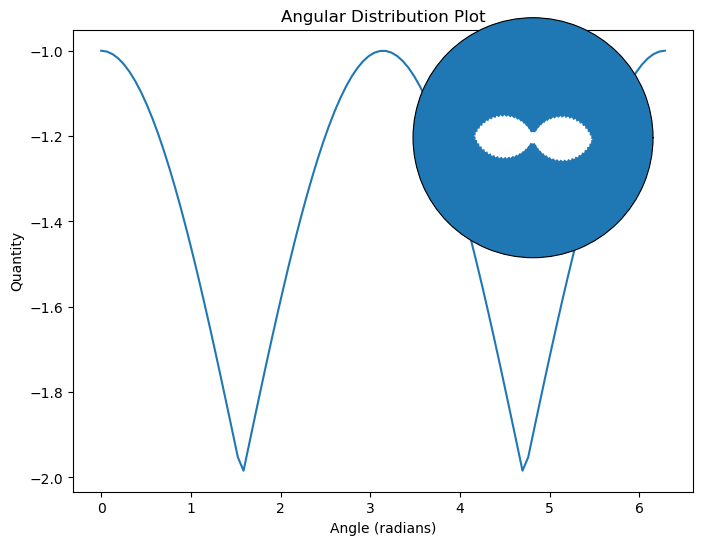

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data: Angular distribution of some quantity
angles = np.linspace(0, 2 * np.pi, 100)  # Angles from 0 to 2π
quantity = np.abs(np.cos(angles))-2  # Example distribution (you can replace this with your data)

# Create the main plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(angles, quantity, label='Angular Distribution')
ax.set_title('Angular Distribution Plot')
ax.set_xlabel('Angle (radians)')
ax.set_ylabel('Quantity')

# Create the inset axes for the circular plot
ax_inset = fig.add_axes([0.5, 0.5, 0.4, 0.4], projection='polar')  # polar projection for circular plot

# Create a circular bar plot using ax.bar
width = 2 * np.pi / len(angles)  # Bar width based on number of angles
bars = ax_inset.bar(np.arange(len(angles)) * 2 * np.pi / len(angles), quantity)

#ax_inset.bar(angles, quantity, width=width, bottom=0, color='r', edgecolor='none')

# Remove the grid and ticks for a cleaner look
ax_inset.grid(False)  # Remove gridlines
ax_inset.set_yticklabels([])  # Remove radial ticks
ax_inset.set_xticklabels([])  # Remove angular ticks

# Set title for the inset plot
#ax_inset.set_title('Circular Bar Plot', fontsize=8)

# Show the plot
plt.show()

In [7]:
pip install pycircular


  Preparing metadata (setup.py) ... done
  Created wheel for pycircular: filename=pycircular-0.1.2-py3-none-any.whl size=18554 sha256=10420b65252f7c90d7a6e2ed7076bd4b796c988ab2a202f8be3d16d1a6be5590
  Stored in directory: /home/rahul/.cache/pip/wheels/57/89/5f/ce5256053d56a016451d3aadc7737e0806d3b309f677321425
Successfully built pycircular
Note: you may need to restart the kernel to use updated packages.


In [14]:
def rigList(rigFile):
    hashCounter = -4
    clusterIDs  = []
    for line in rigFile:
        if line[0] == '#':
            hashCounter += 1
        elif hashCounter >= 0:
            clusterIDs.append(line.strip())
    return clusterIDs

kj = rigList(open('/Volumes/rahul_2TB/high_bidispersity/new_data/NP_1000/phi_0.74/ar_1.4/Vr_0.5/run_1/rig_random_seed_params_stress100r_shear.dat'))
(kj)

['0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '97,235,97,381,235,381',
 '97,235,97,381,235,381',
 '97,235,97,381,235,381',
 '174,201,174,488,201,488',
 '97,235,97,381,235,381',
 '174,201,174,488,201,488',
 '247,638,247,705,638,705',
 '174,201,174,488,201,488',
 '174,201,174,488,201,488',
 '174,201,174,488,201,488',
 '206,767,206,904,767,904',
 '318,603,318,947,603,947',
 '174,201,174,488,201,488',
 '206,767,206,904,767,904',
 '318,603,318,947,603,947',
 '174,201,174,488,201,488',
 '206,767,206,904,767,904',
 '318,603,318,947,603,947',
 '135,603,135,646,318,603,318,947,603,947,646,947',
 '206,767,206,904,767,904',
 '41,546,41,772,546,772',
 '83,816,83,895,816,895',
 '84,929,84,933,84,975,190,929,190,975,933,975',
 '135,603,135,646,318,603,318,947,603,947,646,947',
 '323,388,323,875,388,875',
 '337,745,337,982,745,982',
 '434,668,434,768,668,768',
 '41,546,41,772,401,584,401,772,546,772,584,772',
 '69,226,69,897,226,897',
 '83,816,83,895,816,895',
 

In [15]:
len(kj)

55323

In [10]:
def rigList(rigFile):
    '''
    This function reads the rig_*.dat and creates a list of particle index 
    in rigid cluster. Each element in a list is a str with rigid particle index.
    output sample: ['0','0','0',..., '210,600,550,600', '224,224,948,775,948']

    NOTE: The list elements may have repeated index numbers. Filter before
    processing.

    Inputs:
    rigFile - rig_*.dat path
    '''
    hashCounter = -4
    clusterIDs  = []
    temp = []
    for line in rigFile:
        if line[0] == '#':
            hashCounter += 1
            if len(temp) > 0:
                clusterIDs.append(temp)
                temp = []
        elif hashCounter >= 0:
            temp.append(line.strip())
            
    rigClusterIDsList = []
    for ii, sampleList in enumerate(clusterIDs):
        tempList = []
        for kk in range(len(sampleList)):
            tempList.append([int(indx) for indx in sampleList[kk].split(',')])
        rigClusterIDsList.append(tempList)
    return rigClusterIDsList

kk = rigList(open('/Volumes/rahul_2TB/high_bidispersity/new_data/NP_1000/phi_0.74/ar_1.4/Vr_0.5/run_1/rig_random_seed_params_stress100r_shear.dat'))
(kk)

[[[0]],
 [[0]],
 [[0]],
 [[0]],
 [[0]],
 [[0]],
 [[0]],
 [[0]],
 [[0]],
 [[0]],
 [[0]],
 [[0]],
 [[0]],
 [[0]],
 [[97, 235, 97, 381, 235, 381]],
 [[97, 235, 97, 381, 235, 381]],
 [[97, 235, 97, 381, 235, 381], [174, 201, 174, 488, 201, 488]],
 [[97, 235, 97, 381, 235, 381],
  [174, 201, 174, 488, 201, 488],
  [247, 638, 247, 705, 638, 705]],
 [[174, 201, 174, 488, 201, 488]],
 [[174, 201, 174, 488, 201, 488]],
 [[174, 201, 174, 488, 201, 488],
  [206, 767, 206, 904, 767, 904],
  [318, 603, 318, 947, 603, 947]],
 [[174, 201, 174, 488, 201, 488],
  [206, 767, 206, 904, 767, 904],
  [318, 603, 318, 947, 603, 947]],
 [[174, 201, 174, 488, 201, 488],
  [206, 767, 206, 904, 767, 904],
  [318, 603, 318, 947, 603, 947]],
 [[135, 603, 135, 646, 318, 603, 318, 947, 603, 947, 646, 947],
  [206, 767, 206, 904, 767, 904]],
 [[41, 546, 41, 772, 546, 772],
  [83, 816, 83, 895, 816, 895],
  [84, 929, 84, 933, 84, 975, 190, 929, 190, 975, 933, 975],
  [135, 603, 135, 646, 318, 603, 318, 947, 603, 947, 

In [12]:
len(kk)

2000

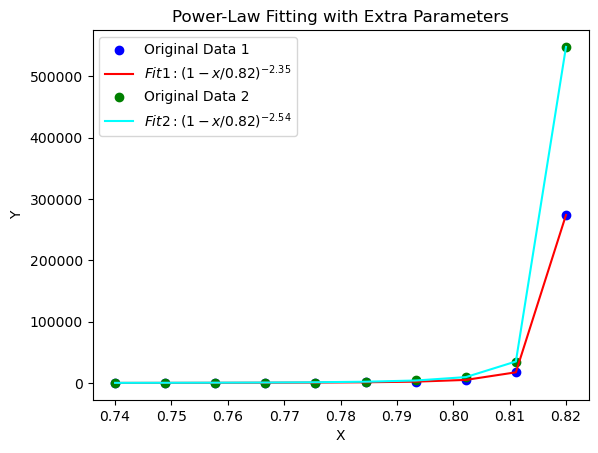

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Modified power law function with an additional parameter 'c'
def power_law(x, a, b):
    return (1 - x / a) ** b

# Generate synthetic data
#np.random.seed(42)
x_data = np.linspace(0.74, 0.82, 10)
y_data = (1 - np.array(x_data) / 0.824) ** -2.35 #+ np.random.normal(0, .1, size=x_data.shape)  # Increasing power law with noise

# Modify last 2 data points
y_data2 = y_data.copy()
y_data2[-4:] *= 2

# Perform power-law fitting with extra parameter 'c'
popt1, pcov1 = curve_fit(power_law, x_data, y_data, p0=(0.824, -2.35))
popt2, pcov2 = curve_fit(power_law, x_data, y_data2, p0=(0.824, -2.35))

# Extract fitted parameters
a_fit1, b_fit1 = popt1
a_fit2, b_fit2 = popt2

# Plot data and fit
plt.scatter(x_data, y_data, label='Original Data 1', color='blue')
plt.plot(x_data, power_law(x_data, *popt1), label=fr'$Fit 1: (1 - x/{a_fit1:.2f})^{{{b_fit1:.2f}}}$', color='red')

plt.scatter(x_data, y_data2, label='Original Data 2', color='green')
plt.plot(x_data, power_law(x_data, *popt2), label=fr'$Fit 2: (1 - x/{a_fit2:.2f})^{{{b_fit2:.2f}}}$', color='cyan')

plt.xlabel('X')
plt.ylabel('Y')
#plt.yscale('log')
#plt.xlim([.735, 0.825])
#plt.ylim([0, 1e4])
plt.legend()
plt.title('Power-Law Fitting with Extra Parameters')
plt.show()

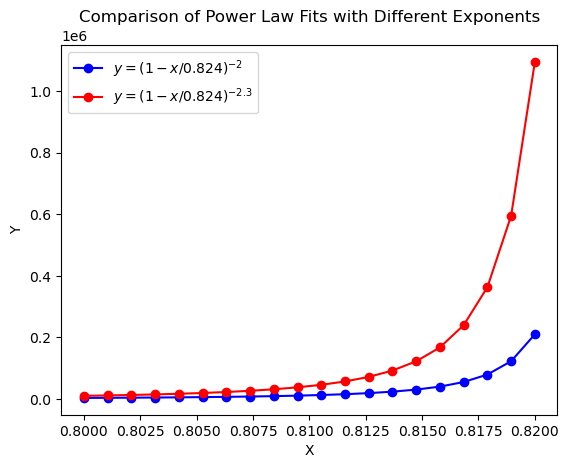

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define x_data as a NumPy array
x_data = np.linspace(0.8, 0.82, 20)

# Define y_data with exponent -2.35
y_data = (1 - np.array(x_data) / 0.824) ** -2.3

# Define y_data2 with a different exponent, e.g., -2.5
y_data2 = (1 - np.array(x_data) / 0.824) ** -2.61

# Plotting the data
#plt.figure(figsize=(8, 6))

# Plot the original y_data with exponent -2.35
plt.plot(x_data, y_data, label=r'$y = (1 - x/0.824)^{-2}$', marker='o', color='blue')

# Plot the modified y_data2 with exponent -2.5
plt.plot(x_data, y_data2, label=r'$y = (1 - x/0.824)^{-2.3}$', marker='o', color='red')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Comparison of Power Law Fits with Different Exponents')
plt.legend()
plt.show()

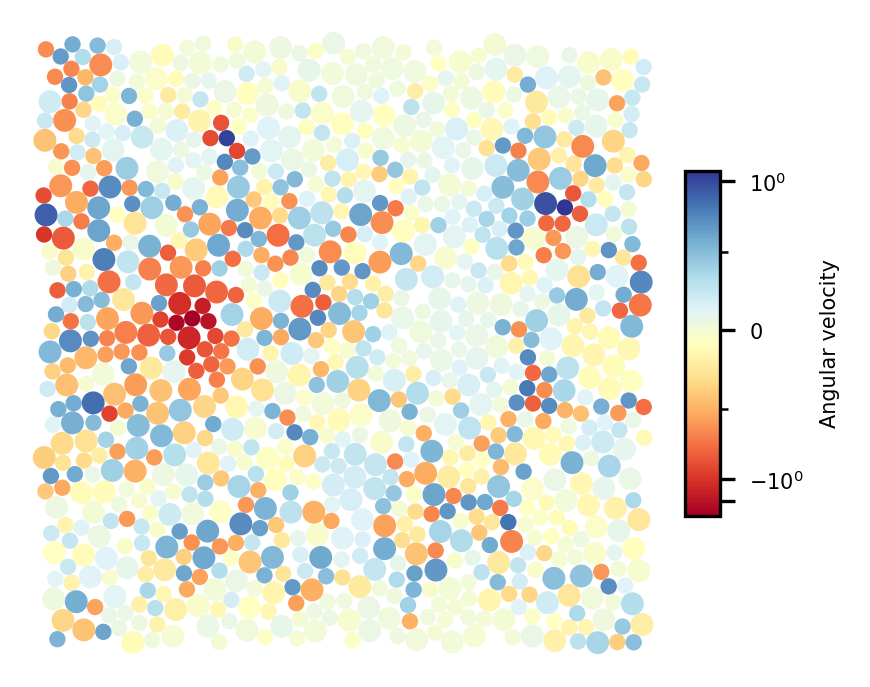

In [53]:
import os
import glob
import matplotlib               # type: ignore
import numpy             as np  # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.colors as mcolors

'''
Feb 5, 2025
RVP

This script produces snapshots of normal force interactions for a given range of strain units.
NOTE: Script creates a directory to store snapshots if it does not exist already
'''

# Input and output paths
topDir        = '/Volumes/rahul_2TB/high_bidispersity/new_data/'
fig_save_path = '/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/conferences/GSOE_poster/movies/'

# Path errors.
print(f"Error: Path '{topDir}' not found. Check mount point") if not os.path.exists(topDir) else None
print(f"Error: Path '{fig_save_path}' not found. Check mount point") if not os.path.exists(fig_save_path) else None

# Simulation parameters
npp    = 1000
phi    = [0.77] #, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76]
ar     = [1.4]  #, 1.4, 1.8, 2.0, 4.0]
vr     = ['0.5']
numRun = 1

# Particles data file
particleFile    = 'par_*.dat' 
interactionFile = 'int_*.dat' 

plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"
plt.rcParams["figure.autolayout"]   = True
#matplotlib.use('Agg')

"====================================================================================================================================="

def parList(particleFile):
    '''
    Function to read parameters file (par*.dat). We read this file to get 
    particle positions
    '''
    particleFile.seek(0)
    hashCounter   = 0
    temp          = []
    particlesList = []

    fileLines = particleFile.readlines()[22:] # skipping the comment lines

    for line in fileLines:
        if not line.split()[0] == '#':
            lineList = [float(value) for value in line.split()]
            temp.append(lineList)
        else:
            # Checking if counter reaches 7 (7 lines of comments after every timestep data).
            hashCounter += 1 
            if hashCounter == 7: 
                particlesList.append(np.array(temp))
                temp        = []
                hashCounter = 0
    particleFile.close()
    return particlesList

"============================================================================================================"

# Frame details
startFrame = 600
endFrame   = 1000

cmap= 'PiYG'

for j in range(len(phi)):
    phii = phi[j]
    phii = '{:.3f}'.format(phi[j]) if len(str(phi[j]).split('.')[1]) > 2 else '{:.2f}'.format(phi[j])
    for k in range(len(ar)):
        for l in range(len(vr)):
            dataname = f"{topDir}NP_{npp}/phi_{phii}/ar_{ar[k]}/Vr_{vr[l]}/run_{numRun}"
            if os.path.exists(dataname):
                parPath  = open(glob.glob(f'{dataname}/{particleFile}')[0])
                parLines = parPath.readlines()
                parList1 = parList(parPath)

                # box dimensions
                Lx = float(parLines[3].split()[2]) 
                Lz = float(parLines[3].split()[2])

                # setting up axis and box walls
                #_, ax = plt.subplots(1, 1, figsize=(5,5), dpi = 500)
                newLx = Lx + 2*ar[k]
                newLz = Lz + 2*ar[k]
                
                # getting the max force from the given range of frames
                maxAngVel, minAngVel = [], []
                for frame in range(startFrame, endFrame):
                    frameList = parList1[frame]

                    pIndex  = frameList[:,0]
                    pRadius = frameList[:,1]
                    px      = frameList[:,2]
                    pz      = frameList[:,3]
                    velx    = frameList[:,4]
                    velz    = frameList[:,6]
                    angVely = frameList[:,8]
                    
                    maxAngVel.append(np.max(angVely))
                    minAngVel.append(np.min(angVely))
                
                maxAngVelres = np.max(maxAngVel)
                minAngVelres = np.min(minAngVel)
                #colorNorm    = plt.Normalize(minAngVelres, maxAngVelres)
                #colors       = plt.cm.RdYlBu(colorNorm(density))
                
                #for frame in range(startFrame, endFrame):
                frame = 1500
                frameList = parList1[frame]

                pIndex  = frameList[:,0]
                pr      = frameList[:,1]
                px      = frameList[:,2]
                pz      = frameList[:,3]
                velx    = frameList[:,4]
                velz    = frameList[:,6]
                angVely = frameList[:,8]
                
                #colorNorm = plt.Normalize(np.min(angVely), np.max(angVely))
                #colors    = plt.cm.PiYG(colorNorm(angVely))
                
                colorNorm = mcolors.SymLogNorm(linthresh=.1, vmin=np.min(angVely), vmax=np.max(angVely), base=10)
                colors = plt.cm.RdYlBu(colorNorm(angVely))

                fig, ax = plt.subplots(1, 1, figsize=(3,3), dpi = 300)

                # plotting all particles 
                for i in range(npp):
                    circle = plt.Circle((px[i],pz[i]), pr[i], facecolor=colors[i], fill=True, edgecolor='none')
                    ax.add_artist(circle)
                    #ax.text(px[i], pz[i], f'{density[i]:.2f}', ha='center', va='center', fontsize=8, color='black')

                ax.set_xlim([-(newLx/2+0.2),(newLx/2+0.2)])
                ax.set_ylim([-(newLz/2+0.2),(newLz/2+0.2)])
                #ax.set_title(fr'$\gamma = {frame/100:.2f}$', pad=10, fontweight='bold')
                ax.axis('off')
                ax.set_aspect('equal')
                
                sm = plt.cm.ScalarMappable(cmap="RdYlBu", norm=colorNorm)
                sm.set_array([])  # Dummy array for colorbar
                cbar = plt.colorbar(sm, ax=ax, fraction=0.05, pad=0.04, shrink=0.5, aspect=10)
                cbar.set_label("Angular velocity", fontsize=5)
                cbar.ax.tick_params(labelsize=5)
                cbar.set_ticks([-2, -1, 0, 1]) # colorbar size
                
                fig.tight_layout()
                plt.show()

In [1]:
import os
import glob
import matplotlib               # type: ignore
import numpy             as np  # type: ignore
import matplotlib.pyplot as plt # type: ignore

'''
Feb 5, 2025
RVP

This script produces snapshots of normal force interactions for a given range of strain units.
NOTE: Script creates a directory to store snapshots if it does not exist already
'''

# Input and output paths
topDir        = '/Volumes/rahul_2TB/high_bidispersity/new_data/'
fig_save_path = '/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/conferences/GSOE_poster/movies/'

# Path errors.
print(f"Error: Path '{topDir}' not found. Check mount point") if not os.path.exists(topDir) else None
print(f"Error: Path '{fig_save_path}' not found. Check mount point") if not os.path.exists(fig_save_path) else None

# Simulation parameters
npp    = 1000
phi    = [0.77] #, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76]
ar     = [1.4]  #, 1.4, 1.8, 2.0, 4.0]
vr     = ['0.5']
numRun = 1

# Particles data file
particleFile    = 'par_*.dat' 
interactionFile = 'int_*.dat' 

plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"
plt.rcParams["figure.autolayout"]   = True
#matplotlib.use('Agg')

"====================================================================================================================================="

def parList(particleFile):
    '''
    Function to read parameters file (par*.dat). We read this file to get 
    particle positions
    '''
    particleFile.seek(0)
    hashCounter   = 0
    temp          = []
    particlesList = []

    fileLines = particleFile.readlines()[22:] # skipping the comment lines

    for line in fileLines:
        if not line.split()[0] == '#':
            lineList = [float(value) for value in line.split()]
            temp.append(lineList)
        else:
            # Checking if counter reaches 7 (7 lines of comments after every timestep data).
            hashCounter += 1 
            if hashCounter == 7: 
                particlesList.append(np.array(temp))
                temp        = []
                hashCounter = 0
    particleFile.close()
    return particlesList

"============================================================================================================"

# Frame details


cmap= 'RdYlBu'

for j in range(len(phi)):
    phii = phi[j]
    phii = '{:.3f}'.format(phi[j]) if len(str(phi[j]).split('.')[1]) > 2 else '{:.2f}'.format(phi[j])
    for k in range(len(ar)):
        for l in range(len(vr)):
            dataname = f"{topDir}NP_{npp}/phi_{phii}/ar_{ar[k]}/Vr_{vr[l]}/run_{numRun}"
            if os.path.exists(dataname):
                parPath  = open(glob.glob(f'{dataname}/{particleFile}')[0])
                parLines = parPath.readlines()
                parList1 = parList(parPath)

                # box dimensions
                Lx = float(parLines[3].split()[2]) 
                Lz = float(parLines[3].split()[2])

                # setting up axis and box walls
                #_, ax = plt.subplots(1, 1, figsize=(5,5), dpi = 500)
                newLx = Lx + 2*ar[k]
                newLz = Lz + 2*ar[k]
                
                #for frame in range(startFrame, endFrame):
                frame = 1500
                frameList = parList1[frame]

                pIndex  = frameList[:,0]
                pr      = frameList[:,1]
                px      = frameList[:,2]
                pz      = frameList[:,3]
                velx    = frameList[:,4]
                velz    = frameList[:,6]
                angVely = frameList[:,8]
                
                colors    = plt.cm.RdYlBu(colorNorm(angVely))

                #plt.figure(figsize=(3, 3))
                #ax = plt.gca()
                fig, ax = plt.subplots(1, 1, figsize=(2,2), dpi = 600)

                # plotting all particles 
                for i in range(npp):
                    circle = plt.Circle((px[i], pz[i]), pr[i], fill=False, edgecolor='black', linewidth=0.1)
                    ax.add_artist(circle)
                    ax.text(px[i], pz[i], f'{angVely[i]:.3}', ha='center', va='center', fontsize=.12, color='black')

                ax.set_xlim([-(newLx/2+0.2),(newLx/2+0.2)])
                ax.set_ylim([-(newLz/2+0.2),(newLz/2+0.2)])
                #ax.set_title(fr'$\gamma = {frame/100:.2f}$', pad=10, fontweight='bold')
                ax.axis('off')
                ax.set_aspect('equal')
                fig.tight_layout()
                plt.show()

NameError: name 'colorNorm' is not defined

In [3]:
(1 - (0.81/0.832))**-2.63

14104.337695405417

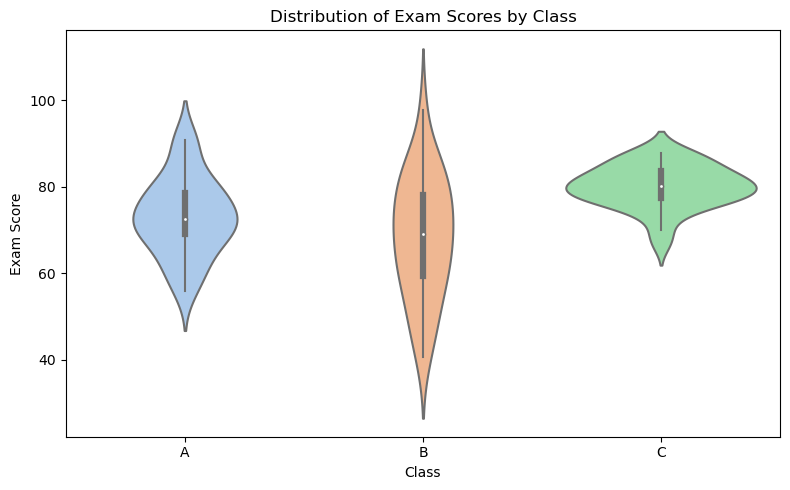

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Generate sample data
np.random.seed(42)
data = {
    'Class': np.repeat(['A', 'B', 'C'], 30),
    'Score': np.concatenate([
        np.random.normal(75, 10, 30),  # Class A
        np.random.normal(70, 15, 30),  # Class B
        np.random.normal(80, 5, 30)    # Class C
    ])
}

df = pd.DataFrame(data)

# Create the violin plot
plt.figure(figsize=(8, 5))
sns.violinplot(x='Class', y='Score', data=df, inner='box', palette='pastel')

# Add labels axnd title
plt.xlabel("Class")
plt.ylabel("Exam Score")
plt.title("Distribution of Exam Scores by Class")

# Show the plot
plt.show()


In [1]:
import os
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import colorsys
from matplotlib import colors

matplotlib.use('TkAgg')

topDir = '/Volumes/rahul_2TB/high_bidispersity/new_data/'
fig_save_path = '/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/conferences/GSOE_poster/'

# Path errors.
if not os.path.exists(topDir):
    print(f"Error: Path '{topDir}' not found. Check mount point")

if not os.path.exists(fig_save_path):
    print(f"Error: Path '{fig_save_path}' not found. Check mount point")

npp = 1000
phi = [0.77]
ar = [1.0, 1.4, 2.0, 4.0]
vr = '0.5'
numRun = 1
parFile = 'par_random_seed_params_stress100r_shear.dat'

# Setup colormap
cmap = matplotlib.colormaps['gist_rainbow']
alpha = 0.75
hls = np.array([colorsys.rgb_to_hls(*c) for c in cmap(np.arange(cmap.N))[:, :3]])
hls[:, 1] *= alpha
rgb = np.clip(np.array([colorsys.hls_to_rgb(*c) for c in hls]), 0, 1)
cmap = colors.LinearSegmentedColormap.from_list("", rgb)

def readParFile(particleFile):
    particleFile.seek(0)
    hashCounter = 0
    temp = []
    particlesList = []

    fileLines = particleFile.readlines()[22:]  # skipping the comment lines

    for line in fileLines:
        if not line.split()[0] == '#':
            lineList = [float(value) for value in line.split()]
            temp.append(lineList)
        else:
            hashCounter += 1
            if hashCounter == 7:
                particlesList.append(np.array(temp))
                temp = []
                hashCounter = 0
    particleFile.close()
    return particlesList

# Simulation frame to display
frame = 300

for j in range(len(phi)):
    phii = phi[j]
    phii = '{:.3f}'.format(phii) if len(str(phii).split('.')[1]) > 2 else '{:.2f}'.format(phii)
    for k in range(len(ar)):
        vrr = '0.25' if ar[k] == 1.0 else '0.5'
        dataname = f"{topDir}NP_{npp}/phi_{phii}/ar_{ar[k]}/Vr_{vrr}"
        if os.path.exists(dataname):
            with open(f'{dataname}/run_{numRun}/{parFile}', 'r') as particleFile:
                lines = particleFile.readlines()
                particlesList = readParFile(particleFile)

            # Box dimensions.
            Lx = float(lines[3].split()[2])
            Lz = float(lines[3].split()[2])

            # Particle sizes and radii.
            px = particlesList[frame][:, 2]
            pz = particlesList[frame][:, 3]
            pr = particlesList[frame][:, 1]

            # Setting up axis and box walls.
            fig, ax = plt.subplots(figsize=(8, 8))  # Create figure and axes
            newLx = Lx + 2 * np.max(pr)
            newLz = Lz + 2 * np.max(pr)

            for i in range(len(particlesList[frame])):
                if pr[i] == 1:
                    circle = plt.Circle((px[i], pz[i]), pr[i], facecolor='#323232', fill=True, edgecolor='None')
                else:
                    circle = plt.Circle((px[i], pz[i]), pr[i], facecolor='#ADD8E6', fill=True, edgecolor='None')
                ax.add_artist(circle)

            ax.set_xlim([-(newLx / 2 + 0.2), (newLx / 2 + 0.2)])
            ax.set_ylim([-(newLz / 2 + 0.2), (newLz / 2 + 0.2)])
            ax.axis('off')
            ax.set_aspect('equal')

            # Saving figure with transparent background.
            figFormat = ".png"
            plt.savefig(f"{fig_save_path}snapshot_phi_{phii}_ar_{ar[k]}_vr_{vr}{figFormat}", bbox_inches="tight", dpi=800, transparent=True)

            plt.close(fig)  # Close the figure to free up memory
        else:
            print(f"{dataname} - Not Found")

In [51]:
import os
import glob
import matplotlib                   # type: ignore
import numpy             as     np  # type: ignore
import matplotlib.pyplot as     plt # type: ignore
import colorsys
from matplotlib import colors       # type: ignore
matplotlib.use('TkAgg')

'''
Feb 21, 2025
RVP

This script produces snapshots for a given range of frames (strain units)with contact lines between LL contacts.
NOTE: Script creates a directory to store snapshots if it does not exist already
'''

# Input and output paths.
topDir        = '/Volumes/rahul_2TB/high_bidispersity/new_data/'
fig_save_path = '/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/conferences/GSOE_poster/movies/'

# Path errors.
print(f"Error: Path '{topDir}' not found. Check mount point") if not os.path.exists(topDir) else None
print(f"Error: Path '{fig_save_path}' not found. Check mount point") if not os.path.exists(fig_save_path) else None

# Simulation parameters.
npp    = 1000
phi    = [0.80] #, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76]
ar     = [4.0]  #, 1.4, 1.8, 2.0, 4.0]
vr     = '0.5'
numRun = 1

cmap      = matplotlib.colormaps['gist_rainbow'] # type: ignore
hls       = np.array([colorsys.rgb_to_hls(*c) for c in cmap(np.arange(cmap.N))[:,:3]])
alpha     = 0.75
hls[:,1] *= alpha
rgb       = np.clip(np.array([colorsys.hls_to_rgb(*c) for c in hls]), 0,1)
cmap      = colors.LinearSegmentedColormap.from_list("", rgb)

# Particles data file
particleFile    = 'par_*.dat' 
interactionFile = 'int_*.dat' 

plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"
plt.rcParams["figure.autolayout"]   = True
matplotlib.use('Agg')

"====================================================================================================================================="

def parList(particleFile):
    '''
    Function to read parameters file (par*.dat). We read this file to get 
    particle positions
    '''
    particleFile.seek(0)
    hashCounter   = 0
    temp          = []
    particlesList = []

    fileLines = particleFile.readlines()[22:] # skipping the comment lines

    for line in fileLines:
        if not line.split()[0] == '#':
            lineList = [float(value) for value in line.split()]
            temp.append(lineList)
        else:
            # Checking if counter reaches 7 (7 lines of comments after every timestep data).
            hashCounter += 1 
            if hashCounter == 7: 
                particlesList.append(np.array(temp))
                temp        = []
                hashCounter = 0
    particleFile.close()
    return particlesList

def interactionsList(interactionFile):
    '''
    This function reads the interaction file and creates a nested-list,
    each list inside contains the array of all interaction parameters for
    that timestep.

    Input: interactionFile - the location of the interaction data file
    '''

    hashCounter = 0
    temp        = []
    contactList = [] # list with interaction parameters for each element at each timestep

    fileLines = interactionFile.readlines()[27:] # skipping the comment lines
    for line in fileLines:
        if not line.split()[0] == '#':
            lineList = [float(value) for value in line.split()]
            temp.append(lineList)
        else:
            hashCounter += 1 # checking if counter reaches 7 (7 lines of comments after every timestep data)
            if hashCounter == 7: 
                contactList.append(np.array(temp))
                temp        = []
                hashCounter = 0
    interactionFile.close()
    return contactList
"====================================================================================================================================="

startFrame = 100
endFrame   = 110

for j in range(len(phi)):
    phii = phi[j]
    phii = '{:.3f}'.format(phii) if len(str(phii).split('.')[1]) > 2 else '{:.2f}'.format(phii)
    for k in range(len(ar)):
        dataname = f"{topDir}NP_{npp}/phi_{phii}/ar_{ar[k]}/Vr_{vr}/run_{numRun}"
        if os.path.exists(dataname):
            intPath = open(glob.glob(f'{dataname}/{interactionFile}')[0])
            intList = interactionsList(intPath)
            
            parPath  = open(glob.glob(f'{dataname}/{particleFile}')[0])
            parLines = parPath.readlines()
            parList1 = parList(parPath)

            # Box dimensions.
            Lx = float(parLines[3].split()[2]) 
            Lz = float(parLines[3].split()[2])

            newLx = Lx + 2*ar[k]
            newLz = Lz + 2*ar[k]
            
            for frame in range(startFrame, endFrame):
                # Particle sizes and radii
                px =parList1[frame][:,2]
                pz =parList1[frame][:,3]
                pr =parList1[frame][:,1]

                frameList = intList[frame]
                pi        = np.array([int(x) for x in frameList[:,0]])
                pj        = np.array([int(x) for x in frameList[:,1]])
                normxij   = frameList[:,2]
                normzij   = frameList[:,4]
                gapij     = frameList[:,5]
                contState = frameList[:,10]
                numInts   = len(contState)

                # Setting up axis and box walls.
                fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi = 500)
                
                ax.clear()
                for i in range(len(parList1[frame])):
                    if pr[i] == 1:
                        circle = plt.Circle((px[i], pz[i]), pr[i], facecolor='#808080', fill=True, edgecolor='None', alpha=0.5)
                    else:
                        circle = plt.Circle((px[i],pz[i]), pr[i], facecolor='#ffb88c', fill=True, edgecolor='None')
                    ax.add_artist(circle)

                for i in range(numInts):
                    p1  = np.array([px[pi[i]], pz[pi[i]]])    # particle 1 position
                    p2  = np.array([px[pj[i]], pz[pj[i]]])    # particle 1 position
                    nij = np.array([normxij[i], normzij[i]])  # normal vector 1 to 2
                    pir = pr[pi[i]]
                    pjr = pr[pj[i]]
                    rij = nij * (gapij[i] + 2.) * (pir + pjr) * 0.5 # vector length between partcle 1 and 2
                    p11 = p1 + rij
                    pairContState = contState[i]
                    if pairContState == 2 and (pir == pjr > 1):
                        ax.plot([p1[0], p11[0]],[p1[1], p11[1]], color='#8B0000', linewidth=3, solid_capstyle='round', solid_joinstyle='round')
                        if (np.sign(nij[0]) != np.sign((p2 - p1)[0])) or (np.sign(nij[1]) != np.sign((p2 - p1)[1])):
                            p22 = p2 - rij
                            ax.plot([p2[0], p22[0]], [p2[1], p22[1]], color='#8B0000', linewidth=3, solid_capstyle='round', solid_joinstyle='round')

                ax.set_xlim([-(newLx/2+0.2),(newLx/2+0.2)])
                ax.set_ylim([-(newLz/2+0.2),(newLz/2+0.2)])
                ax.axis('off')
                ax.set_aspect('equal')
                
                directory = f'{fig_save_path}phi_{phii}_ar_{ar[k]}_vr_{vr}'
                os.makedirs(directory, exist_ok=True)
                fig.savefig(f'{directory}/{frame}.png', dpi=400)
                print(f'>     Processed frame: {frame}/{endFrame-1}      ')
                plt.close()
        else:
            print(f"{dataname} - Not Found")

>     Processed frame: 100/109      
>     Processed frame: 101/109      
>     Processed frame: 102/109      
>     Processed frame: 103/109      
>     Processed frame: 104/109      
>     Processed frame: 105/109      
>     Processed frame: 106/109      
>     Processed frame: 107/109      
>     Processed frame: 108/109      
>     Processed frame: 109/109      


In [49]:
dataname

'/Volumes/rahul_2TB/high_bidispersity/new_data/NP_1000/phi_0.80/ar_4.0/Vr_0.5'

In [2]:
def interactionsList(interactionFile):
    '''
    This function reads the interaction file and creates a nested-list,
    each list inside contains the array of all interaction parameters for
    that timestep.

    Input: interactionFile - the location of the interaction data file
    '''

    hashCounter = 0
    temp        = []
    contactList = [] # list with interaction parameters for each element at each timestep

    fileLines = interactionFile.readlines()[27:] # skipping the comment lines
    for line in fileLines:
        if not line.split()[0] == '#':
            lineList = [float(value) for value in line.split()]
            temp.append(lineList)
        else:
            hashCounter += 1 # checking if counter reaches 7 (7 lines of comments after every timestep data)
            if hashCounter == 7: 
                contactList.append(np.array(temp))
                temp        = []
                hashCounter = 0
    interactionFile.close()
    return contactList

In [7]:
intPath = open('/Volumes/rahul_2TB/high_bidispersity/new_data/NP_1000/phi_0.78/ar_4.0/Vr_0.25/run_1/int_random_seed_params_stress100r_shear.dat')
intList = interactionsList(intPath)

frameList = intList[200]

normxij   = frameList[:,2]
normzij   = frameList[:,4]
lubNorm   = frameList[:,6]
lubTangx  = frameList[:,7]
lubTangz  = frameList[:,9]
contNorm  = frameList[:,11]
contTangx = frameList[:,12]
contTangz = frameList[:,14]
repulNorm = frameList[:,16]

normInts  = lubNorm + contNorm + repulNorm
tangInts  = np.linalg.norm(np.array([lubTangx + contTangx, lubTangz + contTangz]), axis=0)
totForce  = np.array([normInts, tangInts])
forceNorm = np.einsum('ij,ij->i', totForce.T, np.column_stack((normxij, normzij)))

In [ ]:
np.einsum('ij,ij->i', normInts, normInts)

In [21]:

forceProj1 = normInts[:, np.newaxis] * np.column_stack((normxij, normzij))
forceProj2 = np.array([lubTangx + contTangx, lubTangz + contTangz])

anglee = np.einsum('ij,ij->i', forceProj1, forceProj2.T)

In [14]:
forceProj1 = normInts[:, np.newaxis] * np.column_stack((normxij, normzij))
forceProj2 = np.array([lubTangx + contTangx, lubTangz + contTangz])


(-0.1, 0.1)

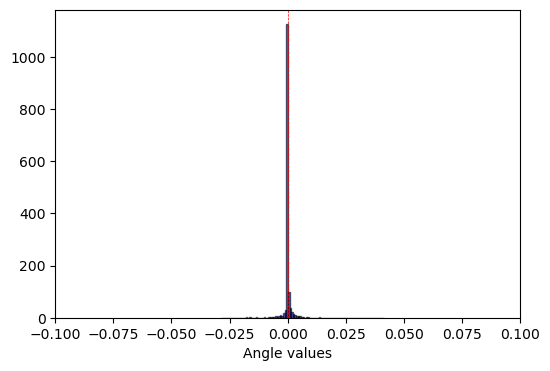

In [47]:
mean_value = np.mean(anglee)

# Create histogram
plt.figure(figsize=(6,4))
plt.hist(anglee, bins=100, density=True, alpha=0.6, color='b', edgecolor='black')

# Plot the mean as a vertical line
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=.5, label=f'Mean = {mean_value:.3f}')

# Labels and title
plt.xlabel("Angle values")
plt.xlim([-.1, .1])

In [25]:
anglee

array([-5.45533786e-06,  3.98897923e-03,  0.00000000e+00, ...,
       -1.08081242e-09,  1.88241246e-07, -7.71688390e-09])

In [33]:
print(np.sort(anglee)[10:])

[-0.01036009 -0.00971695 -0.00848037 ...  0.01535424  0.02599462
  0.04123355]


In [34]:
anglee[0]

-5.4553378608749755e-06

In [13]:
print("totForce shape:", totForce.shape)  # Should be (2438, 2)
print("normxij shape:", normxij.shape)    # Should be (2438,)
print("normzij shape:", normzij.shape)    # Should be (2438,)
print("tang shape:", tangInts.shape)

totForce shape: (2, 2207)
normxij shape: (2207,)
normzij shape: (2207,)
tang shape: (2207,)


In [3]:
data = np.loadtxt('/Volumes/rahul_2TB/high_bidispersity/new_data/NP_1000/phi_0.785/ar_4.0/Vr_0.75/run_1/data_random_seed_params_stress100r_shear.dat')

In [7]:
data[:, 10]

(2001,)

In [8]:
my_list = [1, 2, 3, -4, 5]
index = np.where(np.array(my_list) < 0)[0][0]

In [12]:
np.where(np.array(my_list) < 0)[0][0]

3

In [17]:
dataFile = open('/Volumes/rahul_2TB/high_bidispersity/new_data/NP_1000/phi_0.77/ar_2.0/Vr_0.25/run_2/data_random_seed_params_stress100r_shear.dat')
datData  = np.loadtxt(dataFile)
srList   = list(datData[:,2])
stValue  = np.where(np.array(srList) < 0)[0][0]

In [16]:
len(srList)

2001

In [15]:
np.where(np.array(srList) < 0)

(array([], dtype=int64),)

In [ ]:
# To plot parameter vs phim all zeta values
# plotting functions
from scipy.optimize import curve_fit
#from matplotlib.lines import Line2D
#mac
topDir        = '/Volumes/rahul_2TB/high_bidispersity/new_data/'
fig_save_path = '/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/Research/Bidisperse Project/analysis/figures/new_data/'

#linux
#topDir        = '/home/rahul/mnt/sshfs_darwin/simulations/'
#fig_save_path = '/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/Research/Bidisperse Project/analysis/figures/new_data/'

npp     = 1000
phiv    = [0.72, 0.74, 0.75, 0.76, 0.765, 0.77, 0.78, 0.765, 0.79, 0.795, 0.8]
arr     = [1.0, 1.4, 2.0, 4.0]
vrr     = ['0.25', '0.5', '0.75']
numRuns = 2
off     = 100
colors  = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
    '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
    '#bcbd22', '#17becf', '#f6a821', '#f6d020',
    '#003366', '#cc6699'
]
marker_shape = ['p', 'D', 's', '^', 'o', '*', '+', 'x', 'H', 'v', '<', '>', '|']

phim = [[0.7854954763461525, 0.7855437529576518, 0.7891401952846274, 0.8226644737782638], 
        [0.7854954763461525, 0.7848770357288001, 0.7901457354497431, 0.8192596591068829],
        [0.7854954763461525, 0.7853357301032967, 0.7873975128014937, 0.8021663345214478]]
viscall = []
phimall = []
pcount  = 0
for l, vrl in enumerate(vrr):
    for j, arj in enumerate(arr):
        visc      = []
        viscerr   = []
        #phim_vals = [i/phim[][j] for i in phiv]
        for k, phi in enumerate(phiv):
            phir      = f"{phi:.3f}" if phi != round(phi, 2) else f"{phi:.2f}"
            visc_list = []
            viscerr_list = []
            for run in range(numRuns):
                vrj = '0.25' if arj == 1 else vrl
                ll  = 0      if arj == 1 else l
                phim_vals = [i/phim[ll][j] for i in phiv]
                workDir = f"{topDir}NP_{npp}/phi_{phir}/ar_{arj:.1f}/Vr_{vrj}/run_{run+1}/"
                if os.path.exists(workDir):
                    #print(workDir)
                    dataFile = glob.glob(workDir+"data_*.dat")[0]
                    data     = np.loadtxt(dataFile)
                    visc_list.append(np.mean(data[off:, 3])) if len(data[off:, 3]) > off else None
                    viscerr_list.append(np.std(data[off:, 3])) if len(data[off:, 3]) > off else None
            visc.append(np.mean(visc_list) if visc_list else np.nan)
            viscerr.append(np.mean(viscerr_list) if viscerr_list else np.nan)
        
        visc_filtered      = [x for x in visc if not np.isnan(x)]
        viscerr_filtered   = [x for x in viscerr if not np.isnan(x)]
        phim_vals_filtered = [y for x, y in zip(visc, phim_vals) if not np.isnan(x)]

        viscall.append(visc_filtered)
        phimall.append(phim_vals_filtered)
        plt.scatter(phim_vals_filtered, visc_filtered, marker=marker_shape[pcount], s=20, 
            label = fr'$\delta = {arj:.1f},\; \zeta = {float(vrj):.2f}$', color=colors[pcount])
        pcount += 1
        
    plt.plot([], [], ' ', label=" ") 
        
plt.xlabel(r'$\phi/\phi_m$', fontsize=14,fontstyle='italic')
plt.ylabel(r'$\eta_{r}$', fontsize=14,fontstyle='italic')

plt.xlim(.898,.987)
#plt.ylim(0,7300)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper left', fontsize=11, frameon=False)
plt.tight_layout()

# power law fit
viscFlat = [i for sublist in viscall for i in sublist]
phimFlat = [i for sublist in phimall for i in sublist]
def power_law(x, a, b):
    return a * x**b

params, covariance = curve_fit(power_law, phimFlat, viscFlat)
a, b = params
xlin = np.linspace(0.903, max(phimFlat), 100)
plt.plot(xlin, power_law(xlin, *params), color='k', label=f"Fitted power law: y = {a:.2f} * x^{b:.2f}")

figsave=False

if figsave:
    figFormat=".png"
    plt.savefig(fig_save_path+labels[1][y]+'_vs_phim(modified)_'+str(npp)+figFormat, bbox_inches="tight",dpi=500)
plt.show()

In [4]:
import os
import glob
import matplotlib               # type: ignore
import numpy             as np  # type: ignore
import matplotlib.pyplot as plt # type: ignore

'''
Feb 5, 2025
RVP

This script produces snapshots of normal force interactions for a given range of strain units.
Snapshots are produced for all the phi and ar values mentioned.
NOTE: snapshots produced for just one run (run = 1)

pre-requisite - need specific directories to store the images
Command to execute in terminal:
python3 -c makeInteractionSnapshots.py
'''

# Input and output paths
topDir        = '/Volumes/rahul_2TB/high_bidispersity/new_data/flow_curves/'
fig_save_path ='/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/analysis/figures/new_data/movies/flow_curve/'

# Path errors.
print(f"Error: Path '{topDir}' not found. Check mount point") if not os.path.exists(topDir) else None
print(f"Error: Path '{fig_save_path}' not found. Check mount point") if not os.path.exists(fig_save_path) else None

# Simulation parameters
npp    = 1000

# Below arrays must be of same lengths
stress = ['0.05r', '0.5r', '0.5r', '200r']
phi    = [0.77, 0.765, 0.765, 0.795]
ar     = [2.0, 1.0, 1.4, 4.0]

# Fixed params
vr     = '0.5'
numRun = 1

# Particles data file
particleFile    = 'par_*.dat' 
interactionFile = 'int_*.dat' 

plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"
plt.rcParams["figure.autolayout"]   = True
matplotlib.use('Agg')

"====================================================================================================================================="

def parList(particleFile):
    '''
    Function to read parameters file (par*.dat). We read this file to get 
    particle positions
    '''
    particleFile.seek(0)
    hashCounter   = 0
    temp          = []
    particlesList = []

    fileLines = particleFile.readlines()[22:] # skipping the comment lines

    for line in fileLines:
        if not line.split()[0] == '#':
            lineList = [float(value) for value in line.split()]
            temp.append(lineList)
        else:
            # Checking if counter reaches 7 (7 lines of comments after every timestep data).
            hashCounter += 1 
            if hashCounter == 7: 
                particlesList.append(np.array(temp))
                temp        = []
                hashCounter = 0
    particleFile.close()
    return particlesList

def interactionsList(interactionFile):
    '''
    This function reads the interaction file and creates a nested-list,
    each list inside contains the array of all interaction parameters for
    that timestep.

    Input: interactionFile - the location of the interaction data file
    '''

    hashCounter = 0
    temp        = []
    contactList = [] # list with interaction parameters for each element at each timestep

    fileLines = interactionFile.readlines()[27:] # skipping the comment lines
    for line in fileLines:
        if not line.split()[0] == '#':
            lineList = [float(value) for value in line.split()]
            temp.append(lineList)
        else:
            hashCounter += 1 # checking if counter reaches 7 (7 lines of comments after every timestep data)
            if hashCounter == 7: 
                contactList.append(np.array(temp))
                temp        = []
                hashCounter = 0
    interactionFile.close()
    return contactList

"====================================================================================================================================="

# Frame details
startFrame = 100
endFrame   = 250

maxLineWidth = 4.5
for ii in range(len(stress)):
    phii = '{:.3f}'.format(phi[ii]) if len(str(phi[ii]).split('.')[1]) > 2 else '{:.2f}'.format(phi[ii])
    dataname = f"{topDir}stress_{stress[ii]}/NP_{npp}/phi_{phii}/ar_{ar[ii]}/Vr_{vr}/run_{numRun}"
    if os.path.exists(dataname):
        intPath = open(glob.glob(f'{dataname}/{interactionFile}')[0])
        intList = interactionsList(intPath)

        parPath  = open(glob.glob(f'{dataname}/{particleFile}')[0])
        parLines = parPath.readlines()
        parList1 = parList(parPath)

        # box dimensions
        Lx = float(parLines[3].split()[2]) 
        Lz = float(parLines[3].split()[2])

        # setting up axis and box walls
        _, ax = plt.subplots(1, 1, figsize=(5,5), dpi = 500)
        newLx = Lx + 2*ar[ii]
        newLz = Lz + 2*ar[ii]

        # getting the max force from the given range of frames
        maxForces = []
        for frame in range(startFrame, endFrame):
            frameList = intList[frame]
            lubNorm   = frameList[:,6]
            contNorm  = frameList[:,11]
            repulNorm = frameList[:,16]
            normInts  = lubNorm + contNorm + repulNorm

            maxForces.append(np.max(normInts))

        maxForce = np.max(maxForces)

        print("\n")
        # plotting frames
        for frame in range(startFrame, endFrame):
            # position and radius data from par_*.dat
            px = parList1[frame][:,2]
            pz = parList1[frame][:,3]
            pr = parList1[frame][:,1]
            NP = len(pr)

            # interaction data from int_*.dat
            frameList = intList[frame]
            pi        = np.array([int(x) for x in frameList[:,0]])
            pj        = np.array([int(x) for x in frameList[:,1]])
            normxij   = frameList[:,2]
            normzij   = frameList[:,4]
            gapij     = frameList[:,5]
            lubNorm   = frameList[:,6]
            contState = frameList[:,10]
            contNorm  = frameList[:,11]
            repulNorm = frameList[:,16]
            normInts  = lubNorm + contNorm + repulNorm

            # plot parameters
            numInts       = len(contState)
            contLineWidth = np.array(normInts) * maxLineWidth / maxForce
            intColor      = np.array(['r']*numInts, dtype=object)
            contLess      = np.array(contState == 0, dtype=bool)
            fricLess      = np.array(contState == 1, dtype=bool)
            if contLess.size > 0: intColor[contLess] = '#80EF80' # neon green color
            if fricLess.size > 0: intColor[fricLess] = 'tab:cyan'

            fig, ax = plt.subplots(1, 1, figsize=(5,5))

            # plotting all particles 
            for i in range(NP):
                if pr[i] == 1:
                    circle = plt.Circle((px[i],pz[i]), pr[i], facecolor='#9FB5C4', fill=True, edgecolor='none')
                else:
                    circle = plt.Circle((px[i],pz[i]), pr[i], facecolor='#8A9BA8', fill=True, edgecolor='none')
                ax.add_artist(circle)

            # plotting interactions
            for i in range(numInts):
                p1  = np.array([px[pi[i]], pz[pi[i]]])    # particle 1 position
                p2  = np.array([px[pj[i]], pz[pj[i]]])    # particle 1 position
                nij = np.array([normxij[i], normzij[i]]) # normal vector 1 to 2
                pir = pr[pi[i]]
                pjr = pr[pj[i]]
                rij = nij * (gapij[i] + 2.) * (pir + pjr) * 0.5 # vector length between partcle 1 and 2
                p11 = p1 + rij
                ax.plot([p1[0], p11[0]],[p1[1], p11[1]], color=intColor[i], linewidth=contLineWidth[i], solid_capstyle='round', solid_joinstyle='round')

                if (np.sign(nij[0]) != np.sign((p2 - p1)[0])) or (np.sign(nij[1]) != np.sign((p2 - p1)[1])):
                    p22 = p2 - rij
                    ax.plot([p2[0], p22[0]], [p2[1], p22[1]], color=intColor[0], linewidth=contLineWidth[0], solid_capstyle='round', solid_joinstyle='round')

            ax.set_xlim([-(newLx/2+0.2),(newLx/2+0.2)])
            ax.set_ylim([-(newLz/2+0.2),(newLz/2+0.2)])
            #ax.set_title(fr'$\gamma = {frame/100:.2f}$', pad=10, fontweight='bold')
            ax.axis('off')
            ax.set_aspect('equal')

            directory = f'{fig_save_path}str_{stress[ii]}_phi_{phii}_ar_{ar[ii]}_vr_{vr}'
            os.makedirs(directory, exist_ok=True)
            fig.savefig(f'{directory}/{frame}.png', dpi=400)
            print(f'>     Processed frame: {frame}/{endFrame-1}      ')
            plt.close()

        plt.close('all')



>     Processed frame: 100/249      
>     Processed frame: 101/249      
>     Processed frame: 102/249      
>     Processed frame: 103/249      
>     Processed frame: 104/249      
>     Processed frame: 105/249      
>     Processed frame: 106/249      
>     Processed frame: 107/249      
>     Processed frame: 108/249      
>     Processed frame: 109/249      
>     Processed frame: 110/249      
>     Processed frame: 111/249      
>     Processed frame: 112/249      



KeyboardInterrupt



In [3]:
stress[i]

IndexError: list index out of range

In [18]:
import sys
# Add the directory containing the files to sys.path
sys.path.append('/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/Research/Bidisperse Project/myLibrary')

# Now you can import your custom files as modules
import myFunctions
import FilesGenerator
import os
import glob

'''
Jan 21 2025
RVP

This script creates Frig, rig_*.dat files if missing and also rigPrime files if missing
The above mentioned files are required for snapshots
'''
outputVar = 't'   # it can either be 't' or 'gamma' (check it in your parameters file)

NP  = 1000
phi = [0.77]
ar  = [1.4]
vr  = ['0.5']
numRuns = 2

topDir   = '/Users/rahul/Documents/Simulations'
frigFile = 'F_rig.txt' 
rigFile  = 'rig_*.dat' 
    
for i, phii in enumerate(phi):
    phir = '{:.3f}'.format(phii) if len(str(phii).split('.')[1]) > 2 else '{:.2f}'.format(phii)
    for j, arj in enumerate(ar):
        for k, vrk in enumerate(vr):
            for m in range(numRuns):
                run = m+1
                datname  = f"{topDir}/NP_{NP}/phi_{phir}/ar_{arj:.1f}/Vr_{vrk}/run_{run}/"
                if os.path.exists(datname):
                    rigPath  = glob.glob(f'{datname}{rigFile}')
                    frigPath = f'{datname}{frigFile}'
                    if len(rigPath) == 0  or not os.path.exists(frigPath):
                        print('')
                        print(f'NP = {NP}, phi = {phir}, ar = {arj}, vr = {vrk}, run = {run}')
                        workingFileName = datname + '00_OngoingFileGenerator.txt'
                        if os.path.exists(workingFileName):
                            print('  >> The files are being generated for this case  >>  SKIPPING')
                        else:
                            workingFile = open(workingFileName, "w")       
                            workingFile.write('This is just a file to indicate that the some work is going on in this directory.\n')
                            workingFile.close()
                            t_SS = 0 #steadyStateTime.t_SS(i,j,k)
                            FilesGenerator.filesGeneratorOneRun(NP, phii, datname, t_SS, 't', makeMovies=False)
                            os.remove(workingFileName)
                    else:
                        print('  >> The rigdity files already exist for this case  >>  SKIPPING')
        
                    rigPrimeFile = f'{datname}rigPrime.txt'
                    if not os.path.exists(rigPrimeFile):
                        myFunctions.myPrimeRigidClusters(datname)
                else:
                    print(f'directory not found - {topDir}/NP_{NP}/phi_{phir}/ar_{arj:.1f}/Vr_{vrk}/run_{run}/')

directory not found - /Users/rahul/Documents/Simulations/NP_1000/phi_0.77/ar_1.4/Vr_0.5/run_1/

NP = 1000, phi = 0.77, ar = 1.4, vr = 0.5, run = 2
  >> computing rigid clusters
numSnapshots =  1627
Contact and position data has been converted from the LF_DEM format to the format needed to play the pebble game.  Starting pebble game calculations now!
upperSnapShotRange =  1627


KeyboardInterrupt: 

In [4]:
rigPath

[]

In [14]:
rigFile  = 'rig_*.dat'
rigPath = glob.glob(f'{datname}{rigFile}')



In [15]:
np.isem(rigPath)

[]

In [6]:
f'{datname}{rigFile}'

'/Users/rahul/Documents/Simulations/NP_1000/phi_0.77/ar_1.4/Vr_0.5/run_1/rig_*.dat'

In [17]:
import os
import glob
import matplotlib
import numpy             as np
import matplotlib.pyplot as plt

'''
Feb 5, 2025
RVP

This script produces snapshots of normal force interactions for a given range of strain units.
Snapshots are produced for all the phi and ar values mentioned.
NOTE: snapshots produced for just one run (run = 1)

pre-requisite - need specific directories to store the images
Command to execute in terminal:
python3 -c makeInteractionSnapshots.py
'''

# Input and output paths
topDir        = '/Volumes/Rahul_2TB/high_bidispersity/new_data/'

#fig_save_path = '/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/Research/Bidisperse Project/analysis/figures/new_data/movies/interactions/'
fig_save_path ='/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/Research/Bidisperse Project/analysis/figures/new_data/movies/interactions/'

# Path errors.
print(f"Error: Path '{topDir}' not found. Check mount point") if not os.path.exists(topDir) else None
print(f"Error: Path '{fig_save_path}' not found. Check mount point") if not os.path.exists(fig_save_path) else None

# Simulation parameters
npp    = 1000
phi    = [0.77] #, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76]
ar     = [2.0]  #, 1.4, 1.8, 2.0, 4.0]
vr     = ['0.25', '0.75']
numRun = 1

# Particles data file
particleFile    = 'par_*.dat' 
interactionFile = 'int_*.dat' 

plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"
plt.rcParams["figure.autolayout"]   = True
matplotlib.use('Agg')

"====================================================================================================================================="

def parList(particleFile):
    '''
    Function to read parameters file (par*.dat). We read this file to get 
    particle positions
    '''
    particleFile.seek(0)
    hashCounter   = 0
    temp          = []
    particlesList = []

    fileLines = particleFile.readlines()[22:] # skipping the comment lines

    for line in fileLines:
        if not line.split()[0] == '#':
            lineList = [float(value) for value in line.split()]
            temp.append(lineList)
        else:
            # Checking if counter reaches 7 (7 lines of comments after every timestep data).
            hashCounter += 1 
            if hashCounter == 7: 
                particlesList.append(np.array(temp))
                temp        = []
                hashCounter = 0
    particleFile.close()
    return particlesList

def interactionsList(interactionFile):
    '''
    This function reads the interaction file and creates a nested-list,
    each list inside contains the array of all interaction parameters for
    that timestep.

    Input: interactionFile - the location of the interaction data file
    '''

    hashCounter = 0
    temp        = []
    contactList = [] # list with interaction parameters for each element at each timestep

    fileLines = interactionFile.readlines()[27:] # skipping the comment lines
    for line in fileLines:
        if not line.split()[0] == '#':
            lineList = [float(value) for value in line.split()]
            temp.append(lineList)
        else:
            hashCounter += 1 # checking if counter reaches 7 (7 lines of comments after every timestep data)
            if hashCounter == 7: 
                contactList.append(np.array(temp))
                temp        = []
                hashCounter = 0
    interactionFile.close()
    return contactList

"====================================================================================================================================="

# Frame details
startFrame = 1
endFrame   = 10

maxLineWidth = 4.5

for j in range(len(phi)):
    phii = phi[j]
    phii = '{:.3f}'.format(phi[j]) if len(str(phi[j]).split('.')[1]) > 2 else '{:.2f}'.format(phi[j])
    for k in range(len(ar)):
        for l in range(len(vr)):
            dataname = f"{topDir}NP_{npp}/phi_{phii}/ar_{ar[k]}/Vr_{vr[l]}/run_{numRun}"
            if os.path.exists(dataname):
                intPath = open(glob.glob(f'{dataname}/{interactionFile}')[0])
                intList = interactionsList(intPath)

                parPath  = open(glob.glob(f'{dataname}/{particleFile}')[0])
                parLines = parPath.readlines()
                parList1 = parList(parPath)

                # box dimensions
                Lx = float(parLines[3].split()[2]) 
                Lz = float(parLines[3].split()[2])

                # setting up axis and box walls
                _, ax = plt.subplots(1, 1, figsize=(5,5), dpi = 500)
                newLx = Lx + 2*ar[k]
                newLz = Lz + 2*ar[k]
                
                # getting the max force from the given range of frames
                maxForces = []
                for frame in range(startFrame, endFrame):
                    frameList = intList[frame]
                    lubNorm   = frameList[:,6]
                    contNorm  = frameList[:,11]
                    repulNorm = frameList[:,16]
                    normInts  = lubNorm + contNorm + repulNorm

                    maxForces.append(np.max(normInts))
                
                maxForce = np.max(maxForces)
                
                print("\n")
                # plotting frames
                for frame in range(startFrame, endFrame):
                    # position and radius data from par_*.dat
                    px = parList1[frame][:,2]
                    pz = parList1[frame][:,3]
                    pr = parList1[frame][:,1]
                    NP = len(pr)
                    
                    # interaction data from int_*.dat
                    frameList = intList[frame]
                    pi        = np.array([int(x) for x in frameList[:,0]])
                    pj        = np.array([int(x) for x in frameList[:,1]])
                    normxij   = frameList[:,2]
                    normzij   = frameList[:,4]
                    gapij     = frameList[:,5]
                    lubNorm   = frameList[:,6]
                    contState = frameList[:,10]
                    contNorm  = frameList[:,11]
                    repulNorm = frameList[:,16]
                    normInts  = lubNorm + contNorm + repulNorm

                    # plot parameters
                    numInts       = len(contState)
                    contLineWidth = np.array(normInts) * maxLineWidth / maxForce
                    intColor      = np.array(['r']*numInts, dtype=object)
                    contLess      = np.array(contState == 0, dtype=bool)
                    fricLess      = np.array(contState == 1, dtype=bool)
                    if contLess.size > 0: intColor[contLess] = '#80EF80'
                    if fricLess.size > 0: intColor[fricLess] = 'tab:cyan'

                    fig, ax = plt.subplots(1, 1, figsize=(5,5))
                    
                    # plotting all particles 
                    for i in range(NP):
                        if pr[i] == 1:
                            circle = plt.Circle((px[i],pz[i]), pr[i], facecolor='#9FB5C4', fill=True, edgecolor='none')
                        else:
                            circle = plt.Circle((px[i],pz[i]), pr[i], facecolor='#8A9BA8', fill=True, edgecolor='none')
                        ax.add_artist(circle)
                    
                    
                    # plotting interactions
                    for i in range(numInts):
                        p1  = np.array([px[pi[i]], pz[pi[i]]])    # particle 1 position
                        p2  = np.array([px[pj[i]], pz[pj[i]]])    # particle 1 position
                        nij = np.array([normxij[i], normzij[i]]) # normal vector 1 to 2
                        pir = pr[pi[i]]
                        pjr = pr[pj[i]]
                        rij = nij * (gapij[i] + 2.) * (pir + pjr) * 0.5 # vector length between partcle 1 and 2
                        p11 = p1 + rij
                        ax.plot([p1[0], p11[0]],[p1[1], p11[1]], color=intColor[i], linewidth=contLineWidth[i], solid_capstyle='round', solid_joinstyle='round')
                       
                        if (np.sign(nij[0]) != np.sign((p2 - p1)[0])) or (np.sign(nij[1]) != np.sign((p2 - p1)[1])):
                            p22 = p2 - rij
                            ax.plot([p2[0], p22[0]], [p2[1], p22[1]], color=intColor[0], linewidth=contLineWidth[0], solid_capstyle='round', solid_joinstyle='round')
                    
                    ax.set_xlim([-(newLx/2+0.2),(newLx/2+0.2)])
                    ax.set_ylim([-(newLz/2+0.2),(newLz/2+0.2)])
                    #ax.set_title(fr'$\gamma = {frame/100:.2f}$', pad=10, fontweight='bold')
                    ax.axis('off')
                    ax.set_aspect('equal')
                    
                    directory = f'{fig_save_path}phi_{phii}_ar_{ar[k]}_vr_{vr[l]}'
                    os.makedirs(directory, exist_ok=True)
                    fig.savefig(f'{directory}/{frame}.png', dpi=400)
                    print(f'>     Processed frame: {frame}/{endFrame-1}      ')
                    matplotlib.pyplot.close()
                    
                plt.close('all')



>     Processed frame: 1/9      
>     Processed frame: 2/9      
>     Processed frame: 3/9      
>     Processed frame: 4/9      
>     Processed frame: 5/9      
>     Processed frame: 6/9      
>     Processed frame: 7/9      
>     Processed frame: 8/9      
>     Processed frame: 9/9      


>     Processed frame: 1/9      
>     Processed frame: 2/9      
>     Processed frame: 3/9      
>     Processed frame: 4/9      
>     Processed frame: 5/9      
>     Processed frame: 6/9      
>     Processed frame: 7/9      
>     Processed frame: 8/9      
>     Processed frame: 9/9      


In [2]:
contLess

True

In [3]:
contState

array([0., 0., 0., ..., 0., 0., 0.])

In [12]:
np.array(contState == 0, dtype=bool)[10]

False

In [11]:
contState[10]

2.0

In [1]:
import os
import sys
import random
import glob
import matplotlib                       # type: ignore
import numpy             as     np      # type: ignore
import matplotlib.pyplot as     plt     # type: ignore

'''
Feb 4, 2025
RVP

This script produces snapshots of normal force interactions for a given range of strain units.
Snapshots are produced for all the phi and ar values mentioned.
NOTE: snapshots produced for just one run (run = 1)

Command to execute in terminal:
python3 -c makeInteractionSnapshots.py
'''

# Input and output paths.
topDir        = '/media/Linux_1TB/new_data/'
fig_save_path = '/media/Linux_1TB/figures/'

# Path errors.
print(f"Error: Path '{topDir}' not found. Check mount point") if not os.path.exists(topDir) else None
print(f"Error: Path '{fig_save_path}' not found. Check mount point") if not os.path.exists(fig_save_path) else None

# Simulation parameters.
npp    = 1000
phi    = [0.77] #, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76]
ar     = [1.4]  #, 1.4, 1.8, 2.0, 4.0]
vr     = ['0.5']
numRun = 1

# Particles data file.
parFile = 'par_*.dat'
rigFile = 'rig_*.dat'

plt.rcParams.update({
    "figure.max_open_warning": 0,
    "text.usetex": True,
    "figure.autolayout": True,
    "font.family": "STIXGeneral",
    "mathtext.fontset": "stix",
    "font.size":        10,
    "xtick.labelsize":  10,
    "ytick.labelsize":  10,
    "patch.linewidth":  .2,
    "lines.markersize":  5,
    "hatch.linewidth":  .2
})
plt.rcParams['text.latex.preamble']= r"\usepackage{amsmath}"

matplotlib.use('Agg')

"====================================================================================================================================="

def ParList(particleFile):
    '''
    Function to read parameters file (par*.dat). We read this file to get 
    particle positions
    '''
    particleFile.seek(0)
    hashCounter   = 0
    temp          = []
    particlesList = []

    fileLines = particleFile.readlines()[22:] # skipping the comment lines

    for line in fileLines:
        if not line.split()[0] == '#':
            lineList = [float(value) for value in line.split()]
            temp.append(lineList)
        else:
            # Checking if counter reaches 7 (7 lines of comments after every timestep data).
            hashCounter += 1 
            if hashCounter == 7: 
                particlesList.append(np.array(temp))
                temp        = []
                hashCounter = 0
    particleFile.close()
    return particlesList

def interactionsList(interactionFile):
    '''
    This function reads the interaction file and creates a nested-list,
    each list inside contains the array of all interaction parameters for
    that timestep.

    Input: interactionFile - the location of the interaction data file
    '''

    hashCounter = 0
    temp        = []
    contactList = [] # list with interaction parameters for each element at each timestep

    fileLines = interactionFile.readlines()[27:] # skipping the comment lines
    for line in fileLines:
        if not line.split()[0] == '#':
            lineList = [float(value) for value in line.split()]
            temp.append(lineList)
        else:
            hashCounter += 1 # checking if counter reaches 7 (7 lines of comments after every timestep data)
            if hashCounter == 7: 
                contactList.append(np.array(temp))
                temp        = []
                hashCounter = 0
    interactionFile.close()
    return contactList

def particleSizeList(randomSeedFile, sizeRatio, npp = 1000):
    '''
    This function reads the random seed file and creates
    a list of particle sizes. The list index is the particle index.

    Inputs:
    randomSeedFile - location for the random seed file. It contains the particle index and sizes
    sizeRatio      - delta or ar for the case
    npp            - system size
    '''

    if sizeRatio == 1:
        # Painting particles randomly in two colours for monodisperse case.
        particleSize = [1]*(int(npp/2)) + [2]*(int(npp/2))
        random.shuffle(particleSize)
    else:
        particleSize = np.loadtxt(randomSeedFile, usecols = 3) # reading only column 3 which has particle size
        randomSeedFile.close()
    return particleSize
"====================================================================================================================================="

maxLineWidth      = 5

particleFile    = 'par_*.dat' 
interactionFile = 'int_*.dat' 
ranSeedFile     = 'random_seed.dat' 

# Frame details
startFrame = 1000
endFrame   = 1010

for j in range(len(phi)):
    phii = phi[j]
    phii = '{:.3f}'.format(phi[j]) if len(str(phi[j]).split('.')[1]) > 2 else '{:.2f}'.format(phi[j])
    for k in range(len(ar)):
        for l in range(len(vr)):
            dataname = dataname = f"{topDir}NP_{npp}/phi_{phii}/ar_{ar[k]}/Vr_{vr[l]}/run_{numRun}"
            if os.path.exists(dataname):
                intPath = open(glob.glob(f'{dataname}/{interactionFile}')[0])
                intList = interactionsList(intPath)

                parPath  = open(glob.glob(f'{dataname}/{particleFile}')[0])
                parLines = parPath.readlines()
                ParList  = ParList(parPath)

                #ranSeedPath  = open(glob.glob(f'{dataname}/{ranSeedFile}'))
                #particleSize = particleSizeList(ranSeedPath, sizeRatio = ar[k])

                # Box dimensions.
                Lx = float(parLines[3].split()[2]) 
                Lz = float(parLines[3].split()[2])

                # Setting up axis and box walls.
                _, ax = plt.subplots(1, 1, figsize=(5,5), dpi = 500)
                newLx = Lx + 2*ar[k]
                newLz = Lz + 2*ar[k]
                
                maxForces = []

                for ss in range(startFrame, endFrame):
                    frameList = intList[ss]

                    pi        = np.array([int(x) for x in frameList[:,0]])
                    pj        = np.array([int(x) for x in frameList[:,1]])
                    normxij   = frameList[:,2]
                    normyij   = frameList[:,3]
                    normzij   = frameList[:,4]
                    lubNorm   = frameList[:,6]
                    contNorm  = frameList[:,11]
                    repulNorm = frameList[:,16]

                    normInts = lubNorm + contNorm + repulNorm

                    maxForces.append(np.max(normInts))
                
                maxForce = np.max(maxForces)
                
                for ss in range(startFrame, endFrame):
                    px = ParList[ss][:,2]
                    pz = ParList[ss][:,3]
                    pr = ParList[ss][:,1]

                    pi        = np.array([int(x) for x in frameList[:,0]])
                    pj        = np.array([int(x) for x in frameList[:,1]])
                    normxij   = frameList[:,2]
                    normyij   = frameList[:,3]
                    normzij   = frameList[:,4]
                    lubNorm   = frameList[:,6]
                    contState = frameList[:,10]
                    contNorm  = frameList[:,11]
                    repulNorm = frameList[:,16]
                    normInts  = lubNorm + contNorm + repulNorm

                    numInts  = len(contState)
                    intColor = np.array(['r']*numInts, dtype=object)
                    contLess = np.array(contState == 0, dtype=bool)[0]
                    fricLess = np.array(contState == 1, dtype=bool)[0]
                    if contLess.size > 0: intColor[contLess] == 'tab:cyan'
                    if fricLess.size > 0: intColor[fricLess] == 'g'

                    contLineWidth = np.array(normInts) * maxLineWidth / maxForce

                    fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi = 500)

                    for i in range(len(ParList[ss])):
                        if pr[i] == 1:
                            circle = plt.Circle((px[i],pz[i]), pr[i], facecolor='#323232', fill=True, edgecolor='None')
                        else:
                            circle = plt.Circle((px[i],pz[i]), pr[i], facecolor='#ADD8E6', fill=True, edgecolor='None')
                        ax.add_artist(circle)
                    
                    for i in range(len(normInts)):
                        pix = px[pi[i]]
                        piz = pz[pi[i]]

                        pjx = px[pj[i]]
                        pjz = pz[pj[i]]

                        pir = pr[pi[i]]
                        pjr = pr[pj[i]]

                        p1 = np.array([pix, pjx])
                        p2 = np.array([piz, pjz])

                        plt.plot(p1, p2, color = intColor[i], linewidth = contLineWidth[i])

                    ax.axis('off')
                    ax.set_aspect('equal')
                    fig.savefig(fig_save_path+"int_"+str(ss+1)+".png", dpi=200)
                    
                plt.close('all')

IndexError: list index out of range

In [48]:
import os
import sys
import random
import glob
import matplotlib                       # type: ignore
import numpy             as     np      # type: ignore
import matplotlib.pyplot as     plt     # type: ignore

'''
Feb 4, 2025
RVP

This script produces snapshots of normal force interactions for a given range of strain units.
Snapshots are produced for all the phi and ar values mentioned.
NOTE: snapshots produced for just one run (run = 1)

Command to execute in terminal:
python3 -c makeInteractionSnapshots.py
'''

# Input and output paths.
topDir        = '/media/Linux_1TB/new_data/'
fig_save_path = '/media/Linux_1TB/figures/'

# Path errors.
print(f"Error: Path '{topDir}' not found. Check mount point") if not os.path.exists(topDir) else None
print(f"Error: Path '{fig_save_path}' not found. Check mount point") if not os.path.exists(fig_save_path) else None

# Simulation parameters.
npp    = 1000
phi    = [0.77] #, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76]
ar     = [1.4]  #, 1.4, 1.8, 2.0, 4.0]
vr     = ['0.5']
numRun = 1

# Particles data file.
parFile = 'par_*.dat'
rigFile = 'rig_*.dat'

# plt.rcParams.update({
#     "figure.max_open_warning": 0,
#     "text.usetex": True,
#     "figure.autolayout": True,
#     "font.family": "STIXGeneral",
#     "mathtext.fontset": "stix",
#     "font.size":        10,
#     "xtick.labelsize":  10,
#     "ytick.labelsize":  10,
#     "patch.linewidth":  .2,
#     "lines.markersize":  5,
#     "hatch.linewidth":  .2
# })
plt.rcParams['text.latex.preamble']= r"\usepackage{amsmath}"

matplotlib.use('Agg')

"====================================================================================================================================="

def ParList(particleFile):
    '''
    Function to read parameters file (par*.dat). We read this file to get 
    particle positions
    '''
    particleFile.seek(0)
    hashCounter   = 0
    temp          = []
    particlesList = []

    fileLines = particleFile.readlines()[22:] # skipping the comment lines

    for line in fileLines:
        if not line.split()[0] == '#':
            lineList = [float(value) for value in line.split()]
            temp.append(lineList)
        else:
            # Checking if counter reaches 7 (7 lines of comments after every timestep data).
            hashCounter += 1 
            if hashCounter == 7: 
                particlesList.append(np.array(temp))
                temp        = []
                hashCounter = 0
    particleFile.close()
    return particlesList

def interactionsList(interactionFile):
    '''
    This function reads the interaction file and creates a nested-list,
    each list inside contains the array of all interaction parameters for
    that timestep.

    Input: interactionFile - the location of the interaction data file
    '''

    hashCounter = 0
    temp        = []
    contactList = [] # list with interaction parameters for each element at each timestep

    fileLines = interactionFile.readlines()[27:] # skipping the comment lines
    for line in fileLines:
        if not line.split()[0] == '#':
            lineList = [float(value) for value in line.split()]
            temp.append(lineList)
        else:
            hashCounter += 1 # checking if counter reaches 7 (7 lines of comments after every timestep data)
            if hashCounter == 7: 
                contactList.append(np.array(temp))
                temp        = []
                hashCounter = 0
    interactionFile.close()
    return contactList

def particleSizeList(randomSeedFile, sizeRatio, npp = 1000):
    '''
    This function reads the random seed file and creates
    a list of particle sizes. The list index is the particle index.

    Inputs:
    randomSeedFile - location for the random seed file. It contains the particle index and sizes
    sizeRatio      - delta or ar for the case
    npp            - system size
    '''

    if sizeRatio == 1:
        # Painting particles randomly in two colours for monodisperse case.
        particleSize = [1]*(int(npp/2)) + [2]*(int(npp/2))
        random.shuffle(particleSize)
    else:
        particleSize = np.loadtxt(randomSeedFile, usecols = 3) # reading only column 3 which has particle size
        randomSeedFile.close()
    return particleSize
"====================================================================================================================================="

maxLineWidth      = 4

particleFile    = 'par_*.dat' 
interactionFile = 'int_*.dat' 
ranSeedFile     = 'random_seed.dat' 

# Frame details
startFrame = 1000
endFrame   = 1001

for j in range(len(phi)):
    phii = phi[j]
    phii = '{:.3f}'.format(phi[j]) if len(str(phi[j]).split('.')[1]) > 2 else '{:.2f}'.format(phi[j])
    for k in range(len(ar)):
        for l in range(len(vr)):
            dataname = dataname = f"{topDir}NP_{npp}/phi_{phii}/ar_{ar[k]}/Vr_{vr[l]}/run_{numRun}"
            if os.path.exists(dataname):
                intPath = open(glob.glob(f'{dataname}/{interactionFile}')[0])
                intList = interactionsList(intPath)

                parPath  = open(glob.glob(f'{dataname}/{particleFile}')[0])
                parLines = parPath.readlines()
                ParList  = ParList(parPath)

                #ranSeedPath  = open(glob.glob(f'{dataname}/{ranSeedFile}'))
                #particleSize = particleSizeList(ranSeedPath, sizeRatio = ar[k])

                # Box dimensions.
                Lx = float(parLines[3].split()[2]) 
                Lz = float(parLines[3].split()[2])

                # Setting up axis and box walls.
                _, ax = plt.subplots(1, 1, figsize=(5,5), dpi = 500)
                newLx = Lx + 2*ar[k]
                newLz = Lz + 2*ar[k]
                
                maxForces = []

                for ss in range(startFrame, endFrame):
                    frameList = intList[ss]

                    #pi        = np.array([int(x) for x in frameList[:,0]])
                    #pj        = np.array([int(x) for x in frameList[:,1]])
                    #normxij   = frameList[:,2]
                    #normyij   = frameList[:,3]
                    #normzij   = frameList[:,4]
                    lubNorm   = frameList[:,6]
                    contNorm  = frameList[:,11]
                    repulNorm = frameList[:,16]

                    normInts = lubNorm + contNorm + repulNorm

                    maxForces.append(np.max(normInts))
                
                maxForce = np.max(maxForces)
                
                for ss in range(startFrame, endFrame):
                    px = ParList[ss][:,2]
                    pz = ParList[ss][:,3]
                    pr = ParList[ss][:,1]
                    NP = len(pr)
                    
                    frameList = intList[ss]
                    pi        = np.array([int(x) for x in frameList[:,0]])
                    pj        = np.array([int(x) for x in frameList[:,1]])
                    normxij   = frameList[:,2]
                    normzij   = frameList[:,4]
                    gapij     = frameList[:,5]
                    lubNorm   = frameList[:,6]
                    contState = frameList[:,10]
                    contNorm  = frameList[:,11]
                    repulNorm = frameList[:,16]
                    normInts  = lubNorm + contNorm + repulNorm

                    numInts  = len(contState)
                    intColor = np.array(['r']*numInts, dtype=object)
                    contLess = np.array(contState == 0, dtype=bool)[0]
                    fricLess = np.array(contState == 1, dtype=bool)[0]
                    if contLess.size > 0: intColor[contLess] == 'tab:cyan'
                    if fricLess.size > 0: intColor[fricLess] == 'g'

                    contLineWidth = np.array(normInts) * maxLineWidth / maxForce

                    fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi = 500)

                    for i in range(NP):
                        if pr[i] == 1:
                            circle = plt.Circle((px[i],pz[i]), pr[i], facecolor='#323232', fill=True, edgecolor='None')
                        else:
                            circle = plt.Circle((px[i],pz[i]), pr[i], facecolor='#ADD8E6', fill=True, edgecolor='None')
                        ax.add_artist(circle)
                    
                    for i in range(numInts):
                        p1 = np.array([px[pi[i]], pz[pi[i]]])
                        #p2 = np.array(px[pj[i]], pz[pj[i]])
                        nij = np.array([normxij[i], normzij[i]])
                        pir = pr[pi[i]]
                        pjr = pr[pj[i]]

                        rij = nij * (gapij[i] + 2.) * (pir + pjr) * 0.5
                        p2  = p1 + rij

                        ax.plot([p1[0], p2[0]],[p1[1], p2[1]], color = intColor[i], linewidth = contLineWidth[i], solid_capstyle='round', solid_joinstyle='round')
                        p3 = np.array([px[pj[i]], pz[pj[i]]])
                        
                        if (np.sign(nij[0]) != np.sign((p3 - p1)[0])) or (np.sign(nij[1]) != np.sign((p3 - p1)[1])):
                            p4 = p3 - rij
                            ax.plot([p3[0], p4[0]], [p3[1], p4[1]], color=intColor[0], linewidth=contLineWidth[0], solid_capstyle='round', solid_joinstyle='round')
                    
                    ax.set_xlim([-(newLx/2+0.2),(newLx/2+0.2)])
                    ax.set_ylim([-(newLz/2+0.2),(newLz/2+0.2)])
                    ax.set_title(fr'$\gamma = {ss/100:.2f}$', pad=10, fontweight='bold')
                    ax.axis('off')
                    ax.set_aspect('equal')
                    fig.savefig(fig_save_path+"int_"+str(ss+1)+".svg", dpi=800)
                    
                plt.close('all')

In [43]:
fig_save_path+"int_"+str(ss+1)+".svg"

'/media/Linux_1TB/figures/int_1001.svg'

In [31]:
from matplotlib.collections import LineCollection

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev

# Define points (only 2 points)
x = np.array([1, 2])
y = np.array([3, 4])

# Fit a spline with k=1 (linear interpolation)
tck, u = splprep([x, y], s=0, k=1)
u_fine = np.linspace(0, 1, 100)
x_smooth, y_smooth = splev(u_fine, tck)

# Plot smooth curve
plt.plot(x_smooth, y_smooth, color='r', linewidth=3)
plt.scatter(x, y, color='b', zorder=3)  # Show original points

# Show plot
plt.show()


/tmp/ipykernel_1249354/500198426.py:19: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [71]:
pjx

21.1432

In [66]:
glob.glob(f'{dataname}/{interactionFile}')[0]

'/media/Linux_1TB/new_data/NP_1000/phi_0.77/ar_1.4/Vr_0.5/run_1/int_random_seed_params_stress100r_shear.dat'

In [49]:
len(range(10, 15))

5

In [61]:
interactionFile

'int_*.dat'

In [62]:
f'{dataname}/{interactionFile}'

'/media/Linux_1TB/new_data/NP_1000/phi_0.77/ar_1.4/Vr_0.5/int_*.dat'

In [63]:
/media/Linux_1TB/new_data/NP_1000/phi_0.77/ar_1.4/Vr_0.5/run_1/

SyntaxError: invalid syntax (1161567830.py, line 1)

In [47]:
def ParList(particleFile):
    '''
    Function to read parameters file (par*.dat). We read this file to get 
    particle positions
    '''
    particleFile.seek(0)
    hashCounter   = 0
    temp          = []
    particlesList = []

    fileLines = particleFile.readlines()[22:] # skipping the comment lines

    for line in fileLines:
        if not line.split()[0] == '#':
            lineList = [float(value) for value in line.split()]
            temp.append(lineList)
        else:
            # Checking if counter reaches 7 (7 lines of comments after every timestep data).
            hashCounter += 1 
            if hashCounter == 7: 
                particlesList.append(np.array(temp))
                temp        = []
                hashCounter = 0
    particleFile.close()
    return particlesList

In [48]:

ffile = open('/media/rahul/Rahul_2TB/high_bidispersity/new_Data/NP_1000/phi_0.72/ar_1.4/Vr_0.25/run_2/par_random_seed_params_stress100r_shear.dat')
intlist = ParList(ffile)

In [53]:
pi

NameError: name 'pi' is not defined

In [54]:
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])

c = a + b 

In [56]:
len(c)

3

In [51]:
intlist[:][:,2]

TypeError: list indices must be integers or slices, not tuple

In [5]:
def rigList(rigFile):
    hashCounter = -4
    clusterIDs  = []
    temp = []
    for line in rigFile:
        if line[0] == '#':
            hashCounter += 1
            if len(temp) > 0:
                clusterIDs.append(temp)
                temp = []
        elif hashCounter >= 0:
            temp.append(line.strip())
            
    rigClusterIDsList = []
    for ii, sampleList in enumerate(clusterIDs):
        tempList = []
        for kk in range(len(sampleList)):
            tempList.append([int(indx) for indx in sampleList[kk].split(',')])
        rigClusterIDsList.append(tempList)
    return rigClusterIDsList

In [16]:
rigFile = open('/media/Linux_1TB/simulations/NP_1000/phi_0.75/ar_1.4/Vr_0.5/run_1/rig_random_seed_params_stress100r_shear.dat')
rigClusterIDsList1 = rigList(rigFile)
clusterIDs = [[np.nan] if len(samplelist[0]) < 2 else list({int(num) for sublist in samplelist for num in sublist}) for samplelist in rigClusterIDsList1]

In [15]:
rigClusterIDsList1[10]

[[308, 626, 308, 728, 626, 728]]

In [22]:
clusterIDs[1000]

[2,
 6,
 7,
 8,
 522,
 534,
 25,
 27,
 545,
 562,
 569,
 571,
 572,
 579,
 69,
 75,
 77,
 78,
 80,
 84,
 86,
 607,
 101,
 621,
 624,
 625,
 114,
 120,
 634,
 123,
 640,
 129,
 645,
 649,
 650,
 144,
 657,
 148,
 667,
 668,
 158,
 674,
 675,
 165,
 173,
 180,
 693,
 695,
 184,
 183,
 187,
 700,
 190,
 710,
 209,
 213,
 727,
 215,
 218,
 730,
 222,
 735,
 736,
 227,
 740,
 755,
 763,
 255,
 259,
 260,
 773,
 781,
 277,
 281,
 794,
 793,
 285,
 798,
 294,
 807,
 296,
 811,
 812,
 302,
 816,
 819,
 821,
 822,
 823,
 826,
 829,
 320,
 324,
 325,
 843,
 844,
 343,
 856,
 859,
 353,
 867,
 871,
 876,
 364,
 370,
 883,
 372,
 371,
 380,
 382,
 896,
 897,
 899,
 902,
 913,
 914,
 917,
 920,
 410,
 922,
 416,
 929,
 934,
 425,
 951,
 440,
 952,
 954,
 442,
 447,
 960,
 972,
 974,
 984,
 475,
 991,
 992,
 482,
 483,
 995,
 489,
 492]

In [24]:
for index in clusterIDs[100]:
    print(index)

514
522
11
15
531
20
532
21
30
31
32
546
552
41
556
49
53
60
579
584
75
589
591
593
597
604
606
607
97
106
621
628
118
125
127
131
132
645
649
655
152
665
679
683
690
193
708
709
202
716
717
718
208
722
725
726
730
732
226
231
235
243
251
771
772
773
260
777
265
786
274
789
793
285
798
805
807
814
311
827
318
832
835
836
326
839
330
334
847
336
337
348
862
351
871
363
884
381
901
397
912
401
402
921
414
933
935
940
428
432
433
944
947
438
951
952
443
959
455
968
977
983
473
988
989
476
994
995


In [27]:
type(clusterIDs[100][20])

int

In [23]:
startFrame = 1000
endFrame   = 1010

for kk in range(startFrame, endFrame):
    print(kk)

1000
1001
1002
1003
1004
1005
1006
1007
1008
1009


In [27]:
datafile = '/Volumes/Rahul_2TB/high_bidispersity/NP_1000/phi_0.76/ar_1.8/Vr_0.5/run_1/data_random_seed_params_stress100r_shear.dat'
data = np.loadtxt(datafile)
data.shape

(2001, 30)

In [30]:
data[-1][1]*100

2000.0

In [24]:
aa = np.random.randint(low=0, high=10, size=(5, 10))
aa

array([[8, 9, 8, 0, 4, 6, 3, 0, 9, 2],
       [6, 8, 4, 4, 3, 0, 3, 5, 4, 4],
       [5, 6, 4, 1, 0, 9, 0, 2, 0, 9],
       [2, 1, 3, 0, 0, 3, 0, 7, 0, 5],
       [1, 6, 8, 1, 7, 3, 3, 9, 7, 4]])

In [18]:
import numpy as np
for i in range(10):
    print(aa[2:4, i])

[1 1]
[9 0]
[1 4]
[7 7]
[0 4]
[7 3]
[7 0]
[1 4]
[2 7]
[8 1]


In [39]:
import random

npp = 1000
gammat    = 20

frig      = 0.06
timesteps = int(gammat*100)

Nelements          = int(timesteps * npp) # total elements in matrix
Nones              = int(Nelements * frig)
array_flat         = np.zeros(Nelements, dtype=bool)
array_flat[:Nones] = True

np.random.shuffle(array_flat)
rigMatrix = array_flat.reshape(timesteps, npp)

np.sum(rigMatrix)/timesteps/npp

0.06

In [36]:
np.sum(rigMatrix)/timesteps/npp

0.15

In [35]:
rigMatrix.shape

(2000, 1000)

In [68]:
# rigMatrix random check

import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import random

def rigList(rigFile):
    hashCounter = -4
    clusterIDs  = []
    temp = []
    for line in rigFile:
        if line[0] == '#':
            hashCounter += 1
            if len(temp) > 0:
                clusterIDs.append(temp)
                temp = []
        elif hashCounter >= 0:
            temp.append(line.strip())
            
    rigClusterIDsList = []
    for ii, sampleList in enumerate(clusterIDs):
        tempList = []
        for kk in range(len(sampleList)):
            tempList.append([int(indx) for indx in sampleList[kk].split(',')])
        rigClusterIDsList.append(tempList)
    return rigClusterIDsList

off = 100
npp = 1000 

rigFile = open('/Volumes/Rahul_2TB/high_bidispersity/NP_1000/phi_0.75/ar_1.4/Vr_0.5/run_1/rig_random_seed_params_stress100r_shear.dat')
rigClusterIDs = rigList(rigFile)

clusterIDs = [[np.nan] if len(samplelist[0]) < 2 else list({int(num) for sublist in samplelist for num in sublist}) for samplelist in rigClusterIDs]
rigMatrix  = np.zeros((len(clusterIDs),npp), dtype=bool)
ntaus      = len(clusterIDs[off:])

for ii,samplelist in enumerate(clusterIDs):
    if not np.isnan(samplelist)[0]:
        rigMatrix[ii][samplelist] = True

In [61]:
rigMatrix.shape

(2000, 1000)

In [73]:
np.sum(rigMatrix[100:,:])/ntaus/npp

0.11884684210526317

In [66]:
off = 100

dataFile  = '/Volumes/Rahul_2TB/high_bidispersity/NP_1000/phi_0.75/ar_1.4/Vr_0.5/run_1/data_random_seed_params_stress100r_shear.dat'
data      = np.loadtxt(dataFile)
gammat    = data[-1][1]

frigFile  = '/Volumes/Rahul_2TB/high_bidispersity/NP_1000/phi_0.75/ar_1.4/Vr_0.5/run_1/F_rig.txt'
data1     = np.loadtxt(frigFile)
frig      = np.mean(data1[off:])/npp
timesteps = int(gammat*100)

Nelements          = int(timesteps * npp) # total elements in matrix
Nones              = int(Nelements * frig)
array_flat         = np.zeros(Nelements, dtype=bool)
array_flat[:Nones] = True

np.random.shuffle(array_flat)
rigMatrix1 = array_flat.reshape(timesteps, npp)
ntaus     = timesteps - off

In [74]:
np.sum(rigMatrix1[off:,:])/ntaus/npp

0.11889684210526316

In [70]:
frig

0.11898421883219358

In [26]:
frig/1000

0.11898421883219358

In [71]:
rigMatrix1.shape

(2000, 1000)

In [14]:
topDir = '/Users/rahul/Documents/Simulations/test_kn'
phi    = [0.75, 0.79]
ar     = [1.4, 4.0]
runs   = 1
off    = 100
tests  = ['kn1', 'kn2', 'kn3']
kn     = [1884.95, 188.49, 4712.39]

for t in range(len(tests)):
    for i, phii in enumerate(phi):
        for j, arj in enumerate(ar):
            phir   = '{:.3f}'.format(phii) if len(str(phii).split('.')[1])>2 else '{:.2f}'.format(phii)
            Dir = f'{topDir}/{tests[t]}/NP_1000/phi_{phir}/ar_{ar[j]}'
            if not os.path.exists(Dir):
                    continue
            mingap = []
            for l in range(runs):
                workDir = f'{topDir}/{tests[t]}/NP_1000/phi_{phir}/ar_{ar[j]}/Vr_0.5/run_{l+1}'
                dataFile    = glob.glob(f'{workDir}/data_*.dat')[0]
                data        = np.loadtxt(dataFile)
                mingap_data = data[off:, 13]
                mingap.append(np.mean(mingap_data))
            bold_red = "\033[1;31m"
            reset    = "\033[0m"
            overlap  = -np.mean(mingap) * 100
            print(f'phi = {phir}, ar = {arj}, kn = {kn[t]}: {bold_red}{np.round(overlap,3)}{reset} %')

phi = 0.75, ar = 1.4, kn = 1884.95: 2.057 %
phi = 0.75, ar = 1.4, kn = 188.49: 16.155 %
phi = 0.79, ar = 4.0, kn = 4712.39: 1.209 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\panda\AppData\Local\Temp\ipykernel_71304\3932772191.py:83: UserWarning: FixedFormatter should only be used together with FixedLocator
  x1.set_yticklabels(y_tick_labels, fontsize=12, fontweight='bold')  # Set labels with font properties
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\panda\AppData\Local\Temp\ipykernel_71304\3932772191.py:99: UserWarning: FixedFormatter should only be used together with FixedLocator
  x2.set_yticklabels(y_tick_labels, fontsize=12, fontweight='bold')  # Set labels with font properties


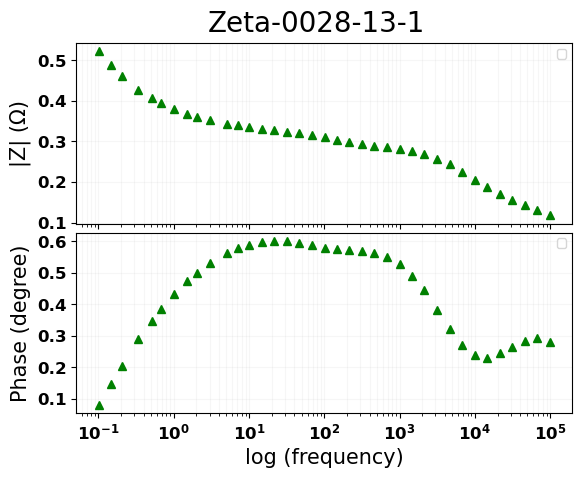

In [13]:
# Bode Plot

# plt.rcParams.update({
#   "figure.max_open_warning" : 0,
#   "text.usetex"             : True,
#   "text.latex.preamble"     : r"\usepackage{amsmath, bm, type1cm}",  # Added \bm for bold math
#   "figure.autolayout"       : True,
#   "font.family"             : "STIXGeneral",
#   "mathtext.fontset"        : "stix",
#   "font.size"               : 8,
#   "xtick.labelsize"         : 8,
#   "ytick.labelsize"         : 8,
#   "lines.linewidth"         : 1,
#   "lines.markersize"        : 5,
# })

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

cell_legend = ['Zeta-0010-30-3', 'Zeta-0010-34-5', 'Zeta-0028-13-1']
#cell_legend = ['Zeta-0010-35-1', 'Zeta-0010-25-3', 'Zeta-0032-16-2']

xls_file = r'C:\Users\panda\Downloads\CE box plot data.xlsx'
sheet = 'Output-Impedance'

# Load the Excel file and the specified sheet
df = pd.read_excel(xls_file, sheet_name=sheet)

# Extract the imaginary and real parts from the dataframe
Freq = df['freq'].tolist()  # Frequency 
Z3 = df['Z3'].tolist()  # Module of real and imag. 3
#Z2 = df['Z2'].tolist()  # Module of real and imag. 2
#Z1 = df['Z1'].tolist()  # Module of real and imag. 1

#Data extraction for phase degree
ph3 = df['phiZ3'].tolist()  # Phase angle for cell 3
#ph2 = df['phiZ2'].tolist()  # Phase angle for cell 2
#ph1 = df['phiZ1'].tolist()  # Phase angle for cell 1

# Number of data points
N = len(Freq)

# Create arrays for the frequency and mod part
Z_freq = np.zeros(N)
Z_mod3 = np.zeros(N)
#Z_mod2 = np.zeros(N)
#Z_mod1 = np.zeros(N)
Z_ph3 = np.zeros(N)
#Z_ph2 = np.zeros(N)
#Z_ph1 = np.zeros(N)

# Populate the arrays
for i in range(N):
    Z_freq[i] = Freq[i]
    Z_mod3[i] = Z3[i]
    #Z_mod2[i] = Z2[i]
    #Z_mod1[i] = Z1[i]
    Z_ph3[i] = ph3[i]
    #Z_ph2[i] = ph2[i]
    #Z_ph1[i] = ph1[i]

# Print the arrays (optional, for debugging)
#print(Z_imag)
#print(Z_real)

# Plot the Bode plot for each set of data

# Create subplots
fig, (x1, x2) = plt.subplots(2, 1)

# Frequency v/s mod of Z
#x1.plot(Z_freq, Z_mod1, marker='o', linestyle=' ', label=cell_legend[0], color='royalblue')
#x1.plot(Z_freq, Z_mod2, marker='s', linestyle=' ', label=cell_legend[1], color='orange')
x1.plot(Z_freq, Z_mod3, marker='^', linestyle=' ', color='green')
x1.set_ylabel('|Z| (\u03A9)', fontsize=15)
#x1.grid(which='both', alpha=0.2)
# Add a legend
x1.legend(loc='upper right', fontsize=8.5)
# Define y-ticks positions (e.g., at 0, 0.5, 1.0)
y_ticks = np.arange(0, 1.1, 0.1)  # Define where you want the ticks
y_tick_labels = [f'{tick:.1f}' for tick in y_ticks]  # Create labels for ticks
x1.set_yticklabels(y_tick_labels, fontsize=12, fontweight='bold')  # Set labels with font properties
x1.set_xticks([])
x1.grid(True, which='both',alpha=.1)
x1.set_xscale('log')

# Frequency v/s phase (degree)
#x2.plot(Z_freq, Z_ph1, marker='o', linestyle=' ', label=cell_legend[0], color='royalblue')
#x2.plot(Z_freq, Z_ph2, marker='s', linestyle=' ', label=cell_legend[1], color='orange')
x2.plot(Z_freq, Z_ph3, marker='^', linestyle=' ', color='green')
x2.set_ylabel('Phase (degree)', fontsize=15)
#x2.grid(which='both', alpha=0.2)
# Add a legend
x2.legend(loc='upper right', fontsize=8.5)
# Define y-ticks positions (e.g., at 0, 0.5, 1.0)
y_ticks = np.arange(0, 1.1, 0.1)  # Define where you want the ticks
y_tick_labels = [f'{tick:.1f}' for tick in y_ticks]  # Create labels for ticks
x2.set_yticklabels(y_tick_labels, fontsize=12, fontweight='bold')  # Set labels with font properties
x2.set_xscale('log')
x2.grid(True, which='both',alpha=.1)
plt.xlabel('log (frequency)', fontsize=15)

#plt.xscale('log')
# Set plot details
fig.suptitle(cell_legend[2], fontsize=20,  y=0.95)
#plt.xlabel('log (frequency)', fontsize=15)
#plt.ylim([0, -2.0])
plt.xticks(fontsize=12, fontweight='bold')
plt.subplots_adjust(hspace=0.05)

plt.savefig(r'C:\Users\panda\Downloads\figure1.svg', bbox_inches="tight",dpi=800)

# Show the plot
plt.show()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import fnmatch

topDir = '/Users/rahul/Downloads/sakshi_data/'
cell_no = [14,15,16]

for i in range(len(cell_no)):
    xls_file = topDir+'Cell_'+str(cell_no[i])+'.xlsx'
    xls = pd.ExcelFile(xls_file)
    sheet_names = xls.sheet_names
    matching_sheets = fnmatch.filter(sheet_names, 'StatisticsByStep_chan_*')
    
    if matching_sheets:
        df = pd.read_excel(file_path, sheet_name=matching_sheets[0])  # Load the first matching sheet
        #print(f"Loaded sheet: {matching_sheets[0]}")
        time = df['Test Time (s)'].tolist()
        voltage = df['Voltage (V)'].tolist()

        plt.plot(time, voltage, label = f'Cell {cell_no[i]}')
        plt.legend()
        plt.show()
    else:
        print("No matching sheet found.")
    

    

No matching sheet found.


NameError: name 'df' is not defined

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import fnmatch

topDir = '/Users/rahul/Downloads/sakshi_data/'
cell_no = [14,15,16]

for i in range(len(cell_no)):
    xls_file = topDir+'Cell_'+str(cell_no[i])+'.xlsx'
    xls = pd.ExcelFile(xls_file)
    sheet_names = xls.sheet_names
    matching_sheets = fnmatch.filter(sheet_names, 'StatisticsByStep_chan_*')
    
    if matching_sheets:
        df = pd.read_excel(file_path, sheet_name=matching_sheets[0])  # Load the first matching sheet
        #print(f"Loaded sheet: {matching_sheets[0]}")
        time = df['Test Time (s)'].tolist()
        voltage = df['Voltage (V)'].tolist()

        plt.plot(time, voltage, label = f'Cell {cell_no[i]}')
        plt.legend()
        plt.show()
    else:
        print("No matching sheet found.")
    

    

[]

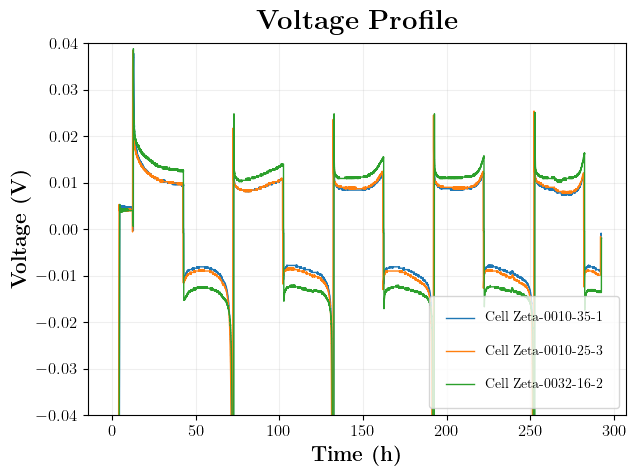

In [98]:
# Voltage profile

# plt.rcParams.update({
#   "figure.max_open_warning" : 0,
#   "text.usetex"             : True,
#   "text.latex.preamble"     : r"\usepackage{amsmath, bm, type1cm}",  # Added \bm for bold math
#   "figure.autolayout"       : True,
#   "font.family"             : "STIXGeneral",
#   "mathtext.fontset"        : "stix",
#   "font.size"               : 8,
#   "xtick.labelsize"         : 8,
#   "ytick.labelsize"         : 8,
#   "lines.linewidth"         : 1,
#   "lines.markersize"        : 5,
# })

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import fnmatch

topDir = '/Users/rahul/Downloads/sakshi_data/'

#cell_no     = [14,15,16]
#cell_legend = ['Zeta-0010-30-3', 'Zeta-0010-34-5', 'Zeta-0028-13-1']

cell_no     = [18,21,22]
cell_legend = ['Zeta-0010-35-1', 'Zeta-0010-25-3', 'Zeta-0032-16-2']

for i in range(len(cell_no)):
    xls_file = topDir+'Cell_'+str(cell_no[i])+'.xlsx'
    sheet    = 'Record-Tab'
    
    df      = pd.read_excel(xls_file, sheet_name = sheet)  # Load the first matching sheet
    time    = df['TestTime/h'].tolist()
    voltage = df['Voltage/V'].tolist()

    plt.plot(time, voltage, label = f'Cell {cell_legend[i]}')
    
plt.grid(which='both', alpha=0.2)
plt.title(r'\textbf{Voltage Profile}', fontsize=20, pad=10)
plt.xlabel(r'\textbf{Time (h)}', fontsize=15)
plt.ylabel(r'\textbf{Voltage (V)}', fontsize=15)
plt.ylim([-0.04, +0.04])
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
plt.legend(loc='lower right', fontsize=10, labelspacing=1.5,borderpad=1.2)
plt.savefig(topDir+ "voltage_profile_cell_2_" +str(cell_no[0])+'.svg', bbox_inches="tight",dpi=800)  
plt.show()

In [17]:
plt.rcParams.update({
  "figure.max_open_warning" : 0,
  "text.usetex"             : True,
  "text.latex.preamble"     : r"\usepackage{amsmath, bm, type1cm}",  # Added \bm for bold math
  "figure.autolayout"       : True,
  "font.family"             : "STIXGeneral",
  "mathtext.fontset"        : "stix",
  "font.size"               : 8,
  "xtick.labelsize"         : 8,
  "ytick.labelsize"         : 8,
  "lines.linewidth"         : 1,
  "lines.markersize"        : 5,
})

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import fnmatch

topDir = '/Users/rahul/Downloads/sakshi_data/'
cell_no     = [14,21,22]
#cell_legend = ['Zeta-0010-30-3', 'Zeta-0010-34-5', 'Zeta-0028-13-1']
cell_legend = ['Zeta-0010-35-1', 'Zeta-0010-25-3', 'Zeta-0032-16-2']

#for i in range(len(cell_no)):
xls_file = topDir+'Cell_'+str(cell_no[0])+'.xlsx'
sheet    = 'Record-Tab'

df      = pd.read_excel(xls_file, sheet_name = sheet)  # Load the first matching sheet
time    = df['TestTime/h'].tolist()
voltage = df['Voltage/V'].tolist()
capacity = df['Capacity/mAh'].tolist()

# dis_cap = 0
# charge_cap=0
# for i in range(len(voltage)):
#     if voltage[i] <= 0:
#         dis_cap += capacity[i]
#     else:
#         #break
#         while voltage[i] > -1:
#             charge_cap += capacity[i]
#         else:
#             break

In [28]:
np.sum(capacity[1516:18657])

87832.40000000001

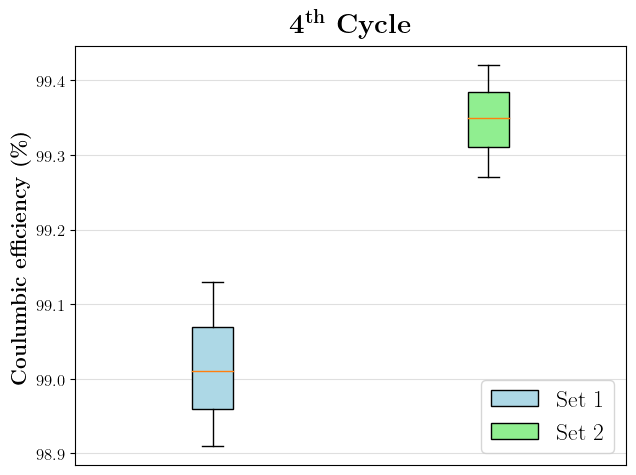

In [91]:
## Couloumbic efficiency

ce_11 = [96.61, 92.70, 98.34]
ce_12 = [97.75, 97.89,98.55]

ce_21 = [97.92,98.04,98.12]
ce_22 = [98.69,98.76,98.62]

ce_31 = [98.69,98.69,98.90]
ce_32 = [98.84,98.98,98.98]

ce_41 = [98.91,99.13,99.01]
ce_42 = [99.35,99.27,99.42]

#plt.boxplot([ce_11, ce_12])

# Set labels for the boxes
box = plt.boxplot([ce_41, ce_42], patch_artist=True)

# Add custom colors
colors = ['lightblue', 'lightgreen']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Set labels for the boxes
#plt.xticks([1, 2], ['Set 1', 'Set 2'])

# Add a legend
plt.legend([box["boxes"][0], box["boxes"][1]], ['Set 1', 'Set 2'], loc='lower right', fontsize = 17)

# Display the plot
plt.grid(which='both', alpha=0.4)
plt.title(r'$\mathbf{4^{th}} \textbf{ Cycle}$', fontsize=20, pad=10)
#plt.xlabel(r'\textbf{Set}', fontsize=15)
plt.ylabel(r'$\textbf{Coulumbic efficiency (\%)}$', fontsize=15)
#plt.xticks(fontsize=12, fontweight='bold')
plt.xticks([])
plt.yticks(fontsize=12, fontweight='bold')
#plt.legend(loc='lower right', fontsize=10, labelspacing=1.5,borderpad=1.2)
plt.savefig(topDir+ "coulumbic_eff_cell_" +'4th cycle'+'.svg', bbox_inches="tight",dpi=800)  
plt.show()

In [36]:
filee = '/Users/rahul/Downloads/datatoprocess/EIS/10_17_2024_4_3_2_20/Cell Group 1/X0093/EIS/Output-Impedance.txt'

In [37]:
df = pd.read_csv(filee, sep="\t") 

In [41]:
df.head()

Id    freq       t             t_cycle       cycle   step    type  p/g   \
0        Hz         s             s                                          
1  1     99121.093  120.360       0.354         1       1       PEIS  p      
2  2     67382.812  120.706       0.699         1       1       PEIS  p      
3  3     46142.578  121.051       1.044         1       1       PEIS  p      
4  4     31494.140  121.403       1.396         1       1       PEIS  p      

   c/d   con   ...  Cp         A          n       m       f_err      \
0              ...  uF                                    %           
1  c     1vs2  ...  0.110783   16.114552  406     1       0.878906    
2  c     1vs2  ...  0.136768   4.841640   276     1       1.095557    
3  c     1vs2  ...  0.169294   3.095588   189     1       0.588829    
4  c     1vs2  ...  0.208644   2.467560   129     1       0.406783    

   dt         pre     avg     DA     ShouldBeSaved  
0  s                                           NaN  
1  0.342800   1       1       1                1.0  
2  0.341211   1       1       1                1.0  
3  0.340378   1       1       1                1.0  
4  0.347449   1       1       1                1.0  

[5 rows x 71 columns]

In [71]:
filee = '/Users/rahul/Downloads/datatoprocess/EIS/10_17_2024_4_3_2_20/Cell Group 1/X0093/EIS/Output-Impedance.txt'
df = pd.read_csv(filee, sep="\t") 
df.iloc[0:, 31]

0     Ohm      
1     -1.700153
2     -1.844843
3     -1.841482
4     -1.791567
5     -1.720304
6     -1.629205
7     -1.518905
8     -1.387754
9     -1.216653
10    -1.017468
11    -0.833021
12    -0.666209
13    -0.532062
14    -0.444904
15    -0.383163
16    -0.346665
17    -0.330573
18    -0.320064
19    -0.311193
20    -0.300160
21    -0.295418
22    -0.295439
23    -0.305562
24    -0.320467
25    -0.340091
26    -0.365894
27    -0.402002
28    -0.484386
29    -0.577171
30    -0.660025
31    -0.795693
32    -0.952512
33    -1.075836
34    -1.270910
35    -1.547410
36    -1.757264
37    -1.992250
Name: Im(Z12)  , dtype: object

In [58]:
for index, column in enumerate(df.columns):
    print(f"Index {index}: {column}")

Index 0: Id  
Index 1: freq     
Index 2: t           
Index 3: t_cycle     
Index 4: cycle 
Index 5: step  
Index 6: type
Index 7: p/g 
Index 8: c/d 
Index 9: con 
Index 10: V12      
Index 11: V1R      
Index 12: V2R      
Index 13: dV12     
Index 14: dV1R     
Index 15: dV2R     
Index 16: I12      
Index 17: I1R      
Index 18: I2R      
Index 19: dI12     
Index 20: dI1R     
Index 21: dI2R     
Index 22: I-Range
Index 23: Q1       
Index 24: Q2       
Index 25: QR       
Index 26: Qcd      
Index 27: |Qcd|    
Index 28: Qc       
Index 29: Qd       
Index 30: Re(Z12)  
Index 31: Im(Z12)  
Index 32: |Z12|    
Index 33: phi(Z12) 
Index 34: SFDR(Z12)
Index 35: Re(Z1)   
Index 36: Im(Z1)   
Index 37: |Z1|     
Index 38: phi(Z1)  
Index 39: SFDR(Z1) 
Index 40: Re(Z2)   
Index 41: Im(Z2)   
Index 42: |Z2|     
Index 43: phi(Z2)  
Index 44: SFDR(Z2) 
Index 45: Re(ZR)   
Index 46: Im(ZR)   
Index 47: |ZR|     
Index 48: phi(ZR)  
Index 49: SFDR(ZR) 
Index 50: Re(Z1R)  
Index 51: Im(Z1R)

Estimated Resistance (R): 0.99 Ohms
Estimated Capacitance (C): 1.01e+00 F
Original Real Part of Impedance (Z_real):
[99.999999   99.99999874 99.99999841 99.99999799 99.99999746 99.9999968
 99.99999596 99.99999491 99.99999357 99.99999189 99.99998976 99.99998708
 99.9999837  99.99997943 99.99997405 99.99996725 99.99995868 99.99994786
 99.99993421 99.99991698 99.99989524 99.99986781 99.99983319 99.99978951
 99.99973439 99.99966484 99.99957708 99.99946633 99.99932659 99.99915025
 99.99892774 99.99864697 99.99829268 99.99784561 99.99728149 99.99656965
 99.99567143 99.99453802 99.99310786 99.99130327 99.98902622 99.98615305
 99.98252777 99.97795355 99.97218215 99.96490041 99.95571341 99.94412314
 99.92950171 99.91105767 99.88779364 99.85845322 99.8214544  99.77480629
 99.71600524 99.64190556 99.54855938 99.43101915 99.28309573 99.09706446
 98.86331215 98.56991924 98.20217519 97.74203228 97.16751537 96.45212456
 95.56429821 94.46704548 93.11791383 91.46952178 89.47095149 87.07033203
 84.21891

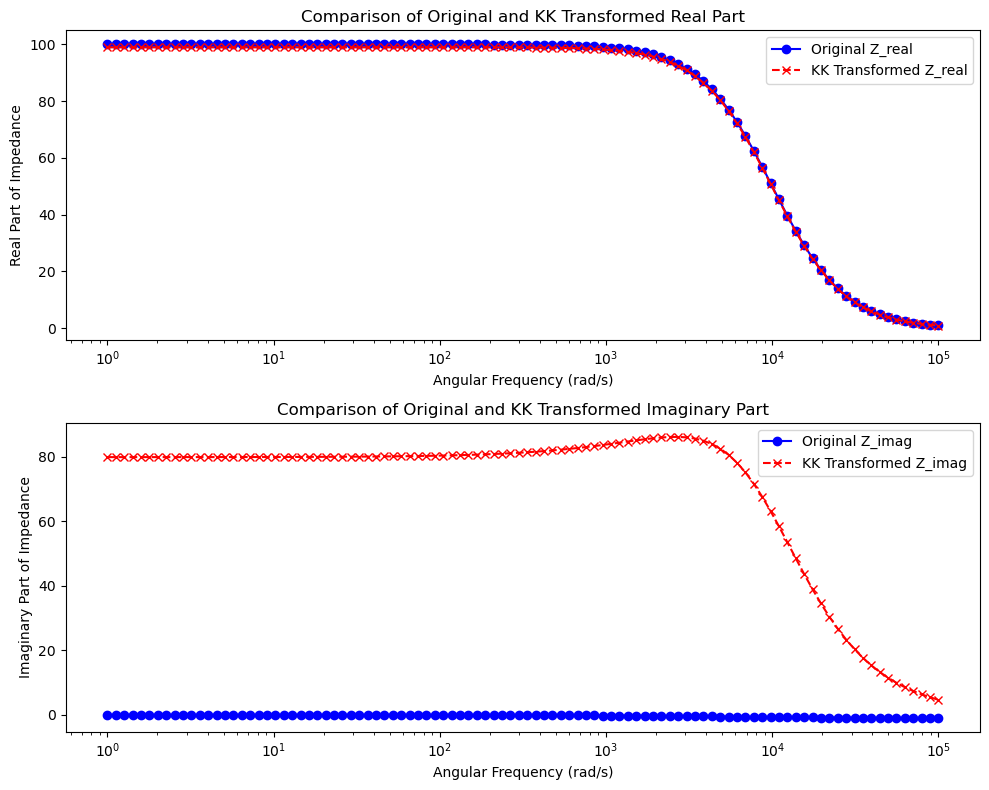

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

file_path = '/Users/rahul/Downloads/python_EIS_trial.xlsx'
sheet_name = 'Sheet3'

df = pd.read_excel(file_path, sheet_name=sheet_name)
re = df['Re'].tolist()
img = df['Imag'].tolist()

# Example Data
omega = np.logspace(0, 5, 100)  # Angular frequencies (rad/s) from 1 to 100,000
R_actual = 100  # Actual resistance in Ohms
C_actual = 1e-6  # Actual capacitance in Farads

# Generate synthetic impedance data for a parallel RC circuit
Z_real = R_actual / (1 + (omega * R_actual * C_actual)**2)  # Real part
Z_imag = -omega * R_actual*2 * C_actual / (1 + (omega * R_actual * C_actual)*2)  # Imaginary part

# Parameter estimation for R and C from the data
R_estimate = np.min(Z_real)  # Estimate R as the minimum real part (at low frequencies)
C_estimate = 1 / (omega[np.argmax(Z_imag != 0)] * R_estimate)  # Estimate C using the first non-zero imaginary part

# Display estimated parameters
print(f'Estimated Resistance (R): {R_estimate:.2f} Ohms')
print(f'Estimated Capacitance (C): {C_estimate:.2e} F')

# Number of data points
N = len(omega)

# Initialize transformed real and imaginary parts
Z_real_KK = np.zeros(N)
Z_imag_KK = np.zeros(N)
#values1 = input(f"Enter the value for element separated by spaces: ").split() #prompt the user to enter the value for the current element 
#values2 = input(f"Enter the value for element separated by spaces: ").split() #prompt the user to enter the value for the current element 
#l1 = len(values1)
#l2 = len(values2)

#v1 = [float(i) for i in values1]
#v2 = [float(i) for i in values2]

# Kramers-Kronig Relations Implementation (adjusted for parallel RC circuit)
for i in range(N):
    # Real part from imaginary part transformation
    for j in range(N):
        #if j<len(re):
            #Z_real_KK[i] = re[j]
        if i != j:  # Skip the singular point
            Z_real_KK[i] += omega[j] * (Z_imag[j] - Z_imag[i]) / (omega[j]*2 - omega[i]*2)
    Z_real_KK[i] = Z_real[i] + 2 / np.pi * Z_real_KK[i] * (omega[1] - omega[0])  # Uniform spacing assumed

    # Imaginary part from real part transformation
    for j in range(N):
        #if j<len(img):
             #Z_imag_KK[i] = img[j]
        if i != j:  # Skip the singular point
            Z_imag_KK[i] += omega[j] * (Z_real[j] - Z_real[i]) / (omega[j]*2 - omega[i]*2)
    Z_imag_KK[i] = Z_imag[i] - 2 / np.pi * Z_imag_KK[i] * (omega[1] - omega[0])  # Uniform spacing assumed

# Calculate the Root Mean Square Error (RMSE) for validation
RMSE_real = np.sqrt(np.mean((Z_real - Z_real_KK)**2))
RMSE_imag = np.sqrt(np.mean((Z_imag - Z_imag_KK)**2))

# Normalized error (percentage) for easy interpretation
normalized_error_real = (RMSE_real / np.mean(np.abs(Z_real))) * 100
normalized_error_imag = (RMSE_imag / np.mean(np.abs(Z_imag))) * 100

# Set a threshold for good fit evaluation
threshold = 10  # Error below 10% is considered acceptable

# Display the results
print('Original Real Part of Impedance (Z_real):')
print(Z_real)

print('Transformed Real Part of Impedance using KK (Z_real_KK):')
print(Z_real_KK)

print('Original Imaginary Part of Impedance (Z_imag):')
print(Z_imag)

print('Transformed Imaginary Part of Impedance using KK (Z_imag_KK):')
print(Z_imag_KK)

# Display error analysis
print(f'RMSE for Real Part: {RMSE_real:.4f}')
print(f'RMSE for Imaginary Part: {RMSE_imag:.4f}')
print(f'Normalized Error for Real Part: {normalized_error_real:.2f}%')
print(f'Normalized Error for Imaginary Part: {normalized_error_imag:.2f}%')

# Evaluate if the data is a good fit or not
if normalized_error_real < threshold and normalized_error_imag < threshold:
    print('The data is consistent and fits well with the Kramers-Kronig transformation.')
else:
    print('The data is not consistent with the Kramers-Kronig transformation. Please check the validity of your EIS data.')

# Plot the original and transformed data for visual comparison
plt.figure(figsize=(10, 8))

# Plot Real Part
plt.subplot(2, 1, 1)
plt.plot(omega, Z_real, 'b-o', label='Original Z_real')
plt.plot(omega, Z_real_KK, 'r--x', label='KK Transformed Z_real')
plt.xscale('log')
plt.xlabel('Angular Frequency (rad/s)')
plt.ylabel('Real Part of Impedance')
plt.legend()
plt.title('Comparison of Original and KK Transformed Real Part')

# Plot Imaginary Part
plt.subplot(2, 1, 2)
plt.plot(omega, Z_imag, 'b-o', label='Original Z_imag')
plt.plot(omega, Z_imag_KK, 'r--x', label='KK Transformed Z_imag')
plt.xscale('log')
plt.xlabel('Angular Frequency (rad/s)')
plt.ylabel('Imaginary Part of Impedance')
plt.legend()
plt.title('Comparison of Original and KK Transformed Imaginary Part')

plt.tight_layout()
plt.show()

Estimated Resistance (R): 3.14 Ohms
Estimated Capacitance (C): 3.18e-01 F
RMSE for Real Part: 0.0135
RMSE for Imaginary Part: 0.1029
Normalized Error for Real Part: 0.27%
Normalized Error for Imaginary Part: 21.63%
The data is not consistent with the Kramers-Kronig transformation. Please check the validity of your EIS data.


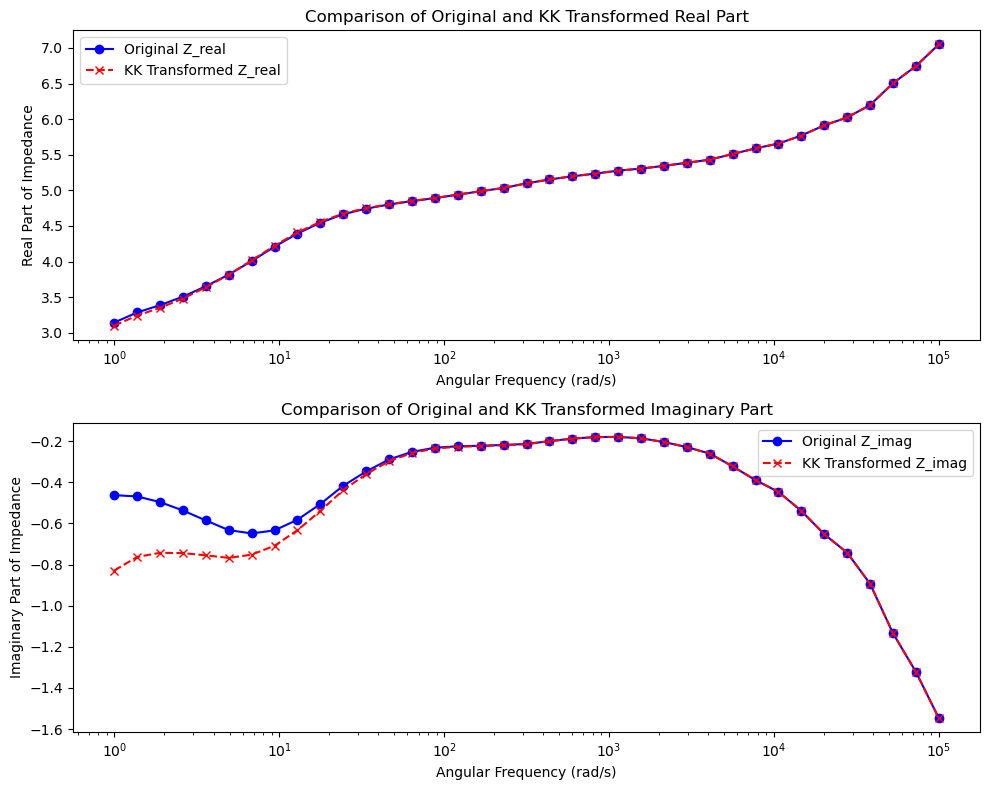

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

file_path = '/Users/rahul/Downloads/python_EIS_trial.xlsx'
sheet_name = 'Sheet3'

df = pd.read_excel(file_path, sheet_name=sheet_name)
re = df['Re'].tolist()
img = df['Imag'].tolist()

# Example Data
omega = np.logspace(0, 5, len(re))  # Angular frequencies (rad/s) from 1 to 100,000
R_actual = 100  # Actual resistance in Ohms
C_actual = 1e-6  # Actual capacitance in Farads

# Generate synthetic impedance data for a parallel RC circuit
# Z_real = R_actual / (1 + (omega * R_actual * C_actual)**2)  # Real part
# Z_imag = -omega * R_actual**2 * C_actual / (1 + (omega * R_actual * C_actual)**2)  # Imaginary part

Z_real = re
Z_imag = img

# Parameter estimation for R and C from the data
R_estimate = np.min(Z_real)  # At low frequencies, the real part approaches the resistance R
C_estimate = 1 / (omega[np.argmax(Z_imag != 0)] * R_estimate)  # Estimate C using the first non-zero imaginary part

# Display estimated parameters
print(f"Estimated Resistance (R): {R_estimate:.2f} Ohms")
print(f"Estimated Capacitance (C): {C_estimate:.2e} F")

# Number of data points
N = len(omega)

# Initialize transformed real and imaginary parts
Z_real_KK = np.zeros(N)
Z_imag_KK = np.zeros(N)

# Kramers-Kronig Relations Implementation (adjusted for parallel RC circuit)
for i in range(N):
    # Real part from imaginary part transformation
    for j in range(N):
        if i != j:  # Skip the singular point
            Z_real_KK[i] += (omega[j] * (Z_imag[j] - Z_imag[i])) / (omega[j]**2 - omega[i]**2)
    Z_real_KK[i] = Z_real[i] + 2 / np.pi * Z_real_KK[i] * (omega[1] - omega[0])  # Uniform spacing assumed

    # Imaginary part from real part transformation
    for j in range(N):
        if i != j:  # Skip the singular point
            Z_imag_KK[i] += (omega[j] * (Z_real[j] - Z_real[i])) / (omega[j]**2 - omega[i]**2)
    Z_imag_KK[i] = Z_imag[i] - 2 / np.pi * Z_imag_KK[i] * (omega[1] - omega[0])  # Uniform spacing assumed

# Calculate the Root Mean Square Error (RMSE) for validation
RMSE_real = np.sqrt(np.mean((Z_real - Z_real_KK)**2))
RMSE_imag = np.sqrt(np.mean((Z_imag - Z_imag_KK)**2))

# Normalized error (percentage) for easy interpretation
normalized_error_real = (RMSE_real / np.mean(np.abs(Z_real))) * 100
normalized_error_imag = (RMSE_imag / np.mean(np.abs(Z_imag))) * 100

# Set a threshold for good fit evaluation
threshold = 10  # Error below 10% is considered acceptable

# Display error analysis
print(f"RMSE for Real Part: {RMSE_real:.4f}")
print(f"RMSE for Imaginary Part: {RMSE_imag:.4f}")
print(f"Normalized Error for Real Part: {normalized_error_real:.2f}%")
print(f"Normalized Error for Imaginary Part: {normalized_error_imag:.2f}%")

# Evaluate if the data is a good fit or not
if normalized_error_real < threshold and normalized_error_imag < threshold:
    print('The data is consistent and fits well with the Kramers-Kronig transformation.')
else:
    print('The data is not consistent with the Kramers-Kronig transformation. Please check the validity of your EIS data.')

# Plot the original and transformed data for visual comparison
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.plot(omega, Z_real, 'b-o', label='Original Z_real')
plt.plot(omega, Z_real_KK, 'r--x', label='KK Transformed Z_real')
plt.xscale('log')
plt.xlabel('Angular Frequency (rad/s)')
plt.ylabel('Real Part of Impedance')
plt.legend()
plt.title('Comparison of Original and KK Transformed Real Part')

plt.subplot(2, 1, 2)
plt.plot(omega, Z_imag, 'b-o', label='Original Z_imag')
plt.plot(omega, Z_imag_KK, 'r--x', label='KK Transformed Z_imag')
plt.xscale('log')
plt.xlabel('Angular Frequency (rad/s)')
plt.ylabel('Imaginary Part of Impedance')
plt.legend()
plt.title('Comparison of Original and KK Transformed Imaginary Part')

plt.tight_layout()
plt.show()

In [14]:
print(convert_to_float(values1[2]))

None


In [ ]:
np.loadtxt('/Users/rahul/Downloads/python_EIS_trial.xlsx',col=2)

Text(0, 0.5, 'Img')

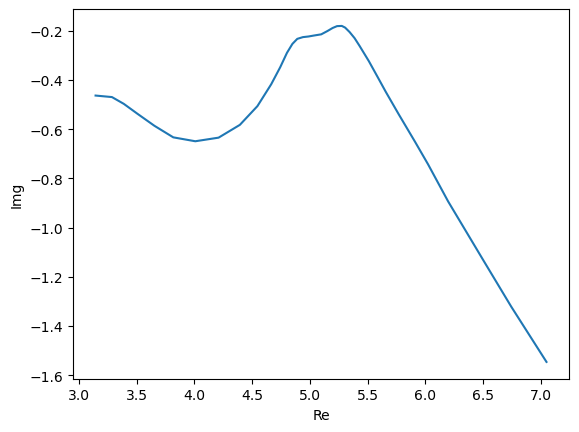

In [9]:
import pandas as pd
file_path = '/Users/rahul/Downloads/python_EIS_trial.xlsx'

df = pd.read_excel(file_path, sheet_name='Sheet3')
re = df['Re'].tolist()
img = df['Imag'].tolist()

plt.plot(re,img)
plt.xlabel('Re')
plt.ylabel('Img')

In [ ]:
import os
import matplotlib                   # type: ignore
import numpy             as     np  # type: ignore
import matplotlib.pyplot as     plt # type: ignore
import colorsys
from matplotlib import colors       # type: ignore
import random
matplotlib.use('TkAgg')

'''
July 22, 2024
RVP

This script produces snapshots at a particular strain unit (here default is set at timestep = 300).
Snapshots are produced for all the phi and ar values mentioned.
NOTE: snapshots produced for just one run (run = 1)

Command to execute in terminal:
python3 -c "from systemSnapshots import snapshot; snapshot"
'''

# Input and output paths.
topDir        = '/media/rahul/Rahul_2TB/high_bidispersity/'
fig_save_path = '/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/Research/Bidisperse Project/SOR_meeting/snapshots/movie/phi_0.78_ar_4.0_Largeonly/'

# Path errors.
print(f"Error: Path '{topDir}' not found. Check mount point") if not os.path.exists(topDir) else None
print(f"Error: Path '{fig_save_path}' not found. Check mount point") if not os.path.exists(fig_save_path) else None

# Simulation parameters.
npp = 1000

phi = [0.78] #, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76]

ar  = [4.0] #, 1.4, 1.8, 2.0, 4.0]

# Particles data file.
parFile     = 'par_random_seed_params_stress100r_shear.dat'
intFile     = 'int_random_seed_params_stress100r_shear.dat'
ranSeedFile = "random_seed.dat"

cmap           = matplotlib.colormaps['gist_rainbow'] # type: ignore
alpha          = 0.75

hls            = np.array([colorsys.rgb_to_hls(*c) for c in cmap(np.arange(cmap.N))[:,:3]])
hls[:,1]      *= alpha
rgb            = np.clip(np.array([colorsys.hls_to_rgb(*c) for c in hls]), 0,1)
cmap           = colors.LinearSegmentedColormap.from_list("", rgb)

"====================================================================================================================================="

def readParFile(particleFile):
    particleFile.seek(0)
    hashCounter   = 0
    temp          = []
    particlesList = []

    fileLines = particleFile.readlines()[22:] # skipping the comment lines

    for line in fileLines:
        if not line.split()[0] == '#':
            lineList = [float(value) for value in line.split()]
            temp.append(lineList)
        else:
            # Checking if counter reaches 7 (7 lines of comments after every timestep data).
            hashCounter += 1 
            if hashCounter == 7: 
                particlesList.append(np.array(temp))
                temp        = []
                hashCounter = 0
    particleFile.close()
    return particlesList

def particleSizeList(randomSeedFile, sizeRatio = 2, npp = 1000):
    '''
    This function reads the random seed file and creates
    a list of particle sizes. The list index is the particle index.

    Inputs:
    randomSeedFile - location for the random seed file. It contains the particle index and sizes
    sizeRatio      - delta or ar for the case
    npp            - system size
    '''

    if sizeRatio == 1:
        # Painting particles randomly in two colours for monodisperse case.
        particleSize = [1]*(int(npp/2)) + [2]*(int(npp/2))
        random.shuffle(particleSize)
    else:
        particleSize = np.loadtxt(randomSeedFile, usecols = 3) # reading only column 3 which has particle size
        randomSeedFile.close()
    return particleSize

def interactionsList(interactionFile):
    '''
    This function reads the interaction file and creates a nested-list,
    each list inside contains the array of all interaction parameters for
    that timestep.

    Input: interactionFile - the location of the interaction data file
    '''

    hashCounter = 0
    temp        = []
    contactList = [] # list with interaction parameters for each element at each timestep

    fileLines = interactionFile.readlines()[27:] # skipping the comment lines
    for line in fileLines:
        if not line.split()[0] == '#':
            lineList = [float(value) for value in line.split()]
            temp.append(lineList)
        else:
            hashCounter += 1 # checking if counter reaches 7 (7 lines of comments after every timestep data)
            if hashCounter == 7: 
                contactList.append(np.array(temp))
                temp        = []
                hashCounter = 0
    interactionFile.close()
    return contactList

"====================================================================================================================================="

frames = [200, 1500]
for j in range(len(phi)):
    phii = phi[j]
    phii = '{:.3f}'.format(phii) if len(str(phii).split('.')[1]) > 2 else '{:.2f}'.format(phii)
    for k in range(len(ar)):
        dataname = topDir + 'NP_' + str(npp) + '/phi_' + phii + '/ar_' + str(ar[k]) + '/Vr_0.5'
        pr = ar[k]
        if os.path.exists(dataname):
            for l in range(1):
                with open(f'{dataname}/run_{l+1}/{parFile}', 'r') as particleFile:
                    lines = particleFile.readlines()
                    particlesList = readParFile(particleFile)

                interFile   = open(f'{dataname}/run_{l+1}/{intFile}', 'r')
                contactList = interactionsList(interFile) 

                Lx = float(lines[3].split()[2]) 
                Lz = float(lines[3].split()[2])
                newLx = Lx + 2 * np.max(pr)
                newLz = Lz + 2 * np.max(pr)

                trajHistory = 20

                for kk in range(frames[0], frames[1]):
                    # Setting up axis and box walls
                    _, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=500)
                    ax.clear()

                    # Start fresh with the first frame
                    s       = 0
                    opacity = 0
                    for frame in range(kk, kk+trajHistory):
                        s += 1 
                        opacity += 1/trajHistory
                        for i in range(len(contactList[frame])):
                            contState = int(contactList[frame][i][10])
                            partIndex1 = int(contactList[frame][i][0])
                            partIndex2 = int(contactList[frame][i][1])
                            
                            pr1 = particlesList[frame][partIndex1][1]
                            pr2 = particlesList[frame][partIndex2][1]
                            
                            if contState == 2 and (pr1 == pr2 > 1):
                                px1 = particlesList[frame][partIndex1][2]
                                pz1 = particlesList[frame][partIndex1][3]

                                px2 = particlesList[frame][partIndex2][2]
                                pz2 = particlesList[frame][partIndex2][3]

                                if s == trajHistory: #10th particle pair
                                    circle1 = plt.Circle((px1, pz1), pr, facecolor='#8B0000', fill=True, edgecolor='None')
                                    circle2 = plt.Circle((px2, pz2), pr, facecolor='#8B0000', fill=True, edgecolor='None')
                                    ax.add_artist(circle1)
                                    ax.add_artist(circle2)
                                else:
                                    circle1 = plt.Circle((px1, pz1), pr, facecolor='#91bfdb', fill=True, edgecolor='None', alpha=opacity)
                                    circle2 = plt.Circle((px2, pz2), pr, facecolor='#91bfdb', fill=True, edgecolor='None', alpha=opacity)
                                    ax.add_artist(circle1)
                                    ax.add_artist(circle2)

                    # Set limits and aspect for the plot
                    ax.set_xlim([-(newLx / 2), (newLx / 2)])
                    ax.set_ylim([-(newLz / 2), (newLz / 2)])
                    ax.axis('off')
                    ax.set_aspect('equal')
    
                    # Saving figure for the current batch of frames
                    figFormat = ".png"
                    plt.savefig(fig_save_path + str(kk) + figFormat, bbox_inches="tight", dpi=800)
    
                    plt.close()
        else:
            print(f"{dataname} - Not Found")

In [22]:
contactList[frame][i][10]

2.0

In [25]:
particlesList[190][500][3]

31.3287

In [4]:
def interactionsList(interactionFile):
    '''
    This function reads the interaction file and creates a nested-list,
    each list inside contains the array of all interaction parameters for
    that timestep.

    Input: interactionFile - the location of the interaction data file
    '''

    hashCounter = 0
    temp        = []
    contactList = [] # list with interaction parameters for each element at each timestep

    fileLines = interactionFile.readlines()[27:] # skipping the comment lines
    for line in fileLines:
        if not line.split()[0] == '#':
            lineList = [float(value) for value in line.split()]
            temp.append(lineList)
        else:
            hashCounter += 1 # checking if counter reaches 7 (7 lines of comments after every timestep data)
            if hashCounter == 7: 
                contactList.append(np.array(temp))
                temp        = []
                hashCounter = 0
    interactionFile.close()
    return contactList

In [7]:
intFile     = 'int_random_seed_params_stress100r_shear.dat'
interFile   = open(f'/media/rahul/Rahul_2TB/high_bidispersity/NP_1000/phi_0.74/ar_1.8/Vr_0.5/run_3/{intFile}', 'r')
contactList = interactionsList(interFile)

In [14]:
contactList[200][2][10]

0.0

In [93]:
rigidID = open(glob.glob('/media/rahul/Rahul_2TB/high_bidispersity/NP_1000/phi_0.72/ar_1.8/Vr_0.5/run_1/rig_*.dat')[0], 'r')
#fileLines= rigidID.readlines()

In [94]:
hashCounter = -4
tt = 0
clusterIDs = []
for line in rigidID:
    if line[0] == '#':
        hashCounter += 1
        
    elif hashCounter >= 0:
        clusterIDs.append(line.strip())

In [74]:
hashCounter = -4
tt = 0
clusterIDs = []
for ii, line in enumerate(fileLines):
    lineq = line
    break

In [87]:
line[0][0]

'\n'

In [104]:
kk=[x  for x in clusterIDs if len(x) > 1]
kj=[int(num) for sublist in kk for num in sublist.split(',')]

In [105]:
kj

[206,
 245,
 206,
 846,
 245,
 846,
 8,
 471,
 8,
 950,
 471,
 950,
 206,
 245,
 206,
 863,
 245,
 863,
 288,
 442,
 288,
 607,
 442,
 607,
 8,
 471,
 8,
 950,
 471,
 950,
 206,
 245,
 206,
 863,
 245,
 863,
 288,
 442,
 288,
 607,
 442,
 607,
 8,
 471,
 8,
 950,
 471,
 950,
 206,
 245,
 206,
 863,
 245,
 863,
 8,
 471,
 8,
 950,
 471,
 950,
 206,
 245,
 206,
 863,
 245,
 863,
 8,
 471,
 8,
 950,
 471,
 950,
 136,
 342,
 136,
 706,
 136,
 749,
 342,
 572,
 342,
 749,
 572,
 706,
 180,
 757,
 180,
 879,
 757,
 879,
 206,
 245,
 206,
 863,
 245,
 863,
 8,
 471,
 8,
 950,
 471,
 950,
 136,
 342,
 136,
 706,
 136,
 749,
 342,
 572,
 342,
 749,
 572,
 706,
 180,
 757,
 180,
 879,
 757,
 879,
 8,
 471,
 8,
 950,
 471,
 950,
 136,
 342,
 136,
 706,
 136,
 749,
 342,
 572,
 342,
 749,
 572,
 706,
 180,
 757,
 180,
 879,
 757,
 879,
 8,
 471,
 8,
 950,
 471,
 950,
 28,
 448,
 28,
 853,
 44,
 213,
 44,
 344,
 213,
 694,
 213,
 853,
 344,
 853,
 448,
 694,
 448,
 853,
 109,
 253,
 109,
 869,
 158

In [97]:
(clusterIDs)

['0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '206,245,206,846,245,846',
 '0',
 '0',
 '0',
 '0',
 '0',
 '8,471,8,950,471,950',
 '206,245,206,863,245,863',
 '288,442,288,607,442,607',
 '8,471,8,950,471,950',
 '206,245,206,863,245,863',
 '288,442,288,607,442,607',
 '8,471,8,950,471,950',
 '206,245,206,863,245,863',
 '8,471,8,950,471,950',
 '206,245,206,863,245,863',
 '8,471,8,950,471,950',
 '136,342,136,706,136,749,342,572,342,749,572,706',
 '180,757,180,879,757,879',
 '206,245,206,863,245,863',
 '8,471,8,950,471,950',
 '136,342,136,706,136,749,342,572,342,749,572,706',
 '180,757,180,879,757,879',
 '8,471,8,950,471,950',
 '136,342,136,706,136,749,342,572,342,749,572,706',
 '180,757,180,879,757,879',
 '8,471,8,950,471,950',
 '28,448,28,853,44,213,44,344,213,694,213,853,344,853,448,694,448,853',
 '109,253,109,869,158,253,158,298,158,869,298,869',
 '136,342,136,706,136,749,342,572,342,749,572,706',
 '180,757,180,879,757,879',
 '208,241,208,281,241,281',
 '395,534,395,973,534,973',


In [95]:
hashCounter

5000

In [32]:
tt

87810

In [25]:
hashCounter

-2

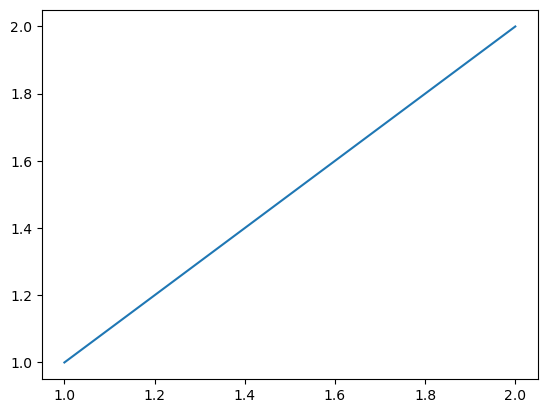

In [5]:
plt.plot([1, 2, 3],[1, 2, np.nan])

In [5]:
import numpy as np

# Define your points
positions = np.array([[4 , 5],
                      [7, 6],
                      [9, 3]])

# Step 1: Compute the Gram matrix (dot products of points)
dot_product = np.dot(positions, positions.T)

# Step 2: Get the squared norms (diagonal of the dot product matrix)
squared_norms = np.diag(dot_product)

# Step 3: Compute the squared Euclidean distances
distances_squared = squared_norms[:, np.newaxis] + squared_norms[np.newaxis, :] - 2 * dot_product

# Step 4: Take the square root to get the Euclidean distances
distances = np.sqrt(np.maximum(distances_squared, 0))  # Use np.maximum to avoid small negative numbers due to floating point errors

print(distances)


[[0.         3.16227766 5.38516481]
 [3.16227766 0.         3.60555128]
 [5.38516481 3.60555128 0.        ]]


In [6]:
np.dot(positions, positions.T)

array([[41, 58, 51],
       [58, 85, 81],
       [51, 81, 90]])

In [8]:
distances_squared

array([[ 0, 10, 29],
       [10,  0, 13],
       [29, 13,  0]])

In [9]:
squared_norms[:, np.newaxis]

array([[41],
       [85],
       [90]])

In [11]:
np.triu(distances)

array([[0.        , 3.16227766, 5.38516481],
       [0.        , 0.        , 3.60555128],
       [0.        , 0.        , 0.        ]])

In [5]:
dd=os.getcwd()

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import time

# Sample data
x = np.linspace(0, 2*np.pi, 100)

plt.ion()  # Turn on interactive mode

# Start an updating plot
for i in range(100):
    y = np.sin(x + i / 10.0)

    plt.figure()
    plt.plot(x, y)
    plt.title(f'Frame {i}')
    
    plt.show()

    clear_output(wait=True)  # Clear the previous plot
    time.sleep(0.1)  # Delay to visualize updates


KeyboardInterrupt: 

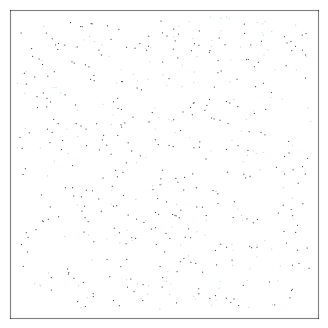

KeyboardInterrupt: 

In [1]:
import numpy as np               # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import random                    # type: ignore
from IPython.display import clear_output

# Simulation parameters
a1  = 1    # radius of smaller particle (everything scales up with this scale)

npp = 500   # total number of particles
phi = 0.7  # total solid packing fraction
vr  = 0.5  # area fraction of small particles
ar  = 1.4  # size ratio (for bi disperse systems)
dr  = 0.1 # step size increase for radius (fractional increase)

# spring constant
kp = 1 # particle - particle constant

pm = 1 # particle mass

# Number of small and large particles
nps = round(npp/((1/ar**2) * ((1/vr) -1) +1))
npl = npp - nps

# List of particle radii in system
radiiList = nps*[a1] + npl*[a1*ar]
random.shuffle(radiiList)

# Calculating box length
pa = sum(np.pi*(a**2) for a in radiiList) # area of all particles
lx = np.sqrt(pa/phi)

# Wall limits in x and y both (square box)
walls = [0, lx]

# Random particle positions and velocities between wall domain 
# Nested list of npp elements with each element being [x,y] format
#np.random.seed(42)
pos = np.random.rand(npp, 2) * (walls[1] - walls[0] - 2 * np.max(radiiList)) + walls[0] + np.max(radiiList)
vel  = np.random.randn(npp, 2)*10

tt = 100  # total time
dt = 1e-2 # time step

def verletIntegration(pos, vel, acc, dt):
    posNew = pos + vel * dt + 0.5 * acc * dt**2
    return posNew

def applyPBC(pos, lx):
    pos = pos % lx  # Wrap positions around the box
    return pos

def computeAccelerations(npp, pos, pr):
    acc = np.zeros_like(pos)
    for i in range(npp):
        for j in range(i + 1, npp):
            dist     = pos[j] - pos[i]
            dist    -= lx * np.round(dist / lx) 
            distNorm = np.linalg.norm(dist)
            rr       = pr[i] + pr[j]
            if distNorm < rr:  # Particle collision
                overlap = rr - distNorm
                normDir = dist / distNorm
                force   = overlap * normDir
                acc[i] -= force / pm
                acc[j] += force / pm
    return acc

def particleContact(pos, vel, pr):
    for i in range(npp):
        for j in range(i + 1, npp):
            dist     = pos[j] - pos[i]
            dist    -= lx * np.round(dist / lx)
            normDist = np.linalg.norm(dist)
            rr       = pr[i]+pr[j]
            if normDist < rr:  # If particles are colliding
                normDir = dist/normDist
                relVel = vel[j] - vel[i]
                velMag = np.dot(relVel, normDir)
                
                if velMag < 0:
                    vel[i] += (np.dot(relVel, dist)/normDist**2) * dist
                    vel[j] -= (np.dot(relVel, dist)/normDist**2) * dist
                
    return vel

def overlaps(pos, pr):
    contOverlaps = []
    
    for i in range(npp):
        for j in range(i+1, npp):
            rr       = pr[i]+pr[j] # net center seperation for contacting particles
            dist     = pos[j] - pos[i]
            dist    -= lx * np.round(dist /lx) 
            normDist = np.linalg.norm(dist)
            if normDist < rr:
                contOverlaps.append((rr - normDist)*100/rr) # percentage overlap
    
    return contOverlaps

def plotCircles(pos, pr, disp=True, saveFig=False):
    clear_output(wait=True)
    
    fig, ax = plt.subplots(figsize=(8/2, 8/2), dpi=100)
    
    # shifts to show particles on all mirrored sides
    shifts = [-lx, 0, lx]
    
    # Plot each particle and its mirrored versions
    for i in range(npp):
        # Check the radius of the particle to decide color (small vs large)
        facecolor = '#323232' if radiiList[i] == np.min(radiiList) else '#ADD8E6'
        
        for shiftX in shifts:
            for shiftY in shifts:
                # Shift the particle position by lx or -lx if it's near the boundary
                shiftedPos = pos[i] + np.array([shiftX, shiftY])
                circle = plt.Circle(shiftedPos, pr[i], facecolor=facecolor, fill=True, edgecolor='None')
                ax.add_artist(circle)

    ax.set_xlim(walls)
    ax.set_ylim(walls)
    ax.set_aspect('equal', 'box')
    ax.set_xticks([])
    ax.set_yticks([])
    
    for spine in ax.spines.values():
        spine.set_color((0, 0, 0, .5))  # translucent box
    
    # Save figure if required
    if saveFig:
        figFormat = '.png'
        savePath = "/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/Research/Bidisperse Project/randomSeed/images/"
        fig.savefig(f'{savePath}frame_{figCount:03d}{figFormat}', bbox_inches='tight')
    
    if disp:
        plt.show()
    
    plt.close()

def simulation():
    global pos, vel
    
    acc = computeAccelerations(npp, pos, pr)
    pos = verletIntegration(pos, vel, acc, dt)
    pos = applyPBC(pos, lx) 
    vel = vel + 0.5 * acc * dt  # Update velocities (half-step)
    vel = particleContact(pos, vel, pr)

# Generating array for radius increase
dr     *= a1  # dr is the fractional step increase proportinal to the small particle radius
rlinAll = [list(np.arange(dr, a+dr, dr)) for a in radiiList]
lenList = [len(a) for a in rlinAll]
for kk in range(npp):
    while len(rlinAll[kk]) < max(lenList):
        rlinAll[kk].append(rlinAll[kk][-1])
rlinAll = np.array(rlinAll) # shape (npp, no. of discrete radii growth)

s         = 0  # iteration counter
figCount  = 1
totIter   = rlinAll.shape[1]   

for jj in range(totIter):
    pr = rlinAll[:, jj] 
    
    prog = jj*100/totIter
    if prog%5 == 0 and prog != (jj-1)*100/totIter:
        paS  = sum(np.pi*(a**2) for a in pr)
        phiS = np.round(paS/lx**2,3)
        print(f'{phiS:.3f}, {prog:.0f}%')
        dt *= .9
        
    while True:
        s += 1
        simulation()
        
        if s%1e0 == 0:
            plotCircles(pos, pr)
        
        overlap      = overlaps(pos, pr)
        meanOverlap  = np.mean(overlap) if len(overlap) != 0 else 0
        overlapCount = len(list(filter(lambda a: a != 0, overlap))) 
        if meanOverlap == 0 or (meanOverlap < 0.05 and overlapCount > .2 *npp):
            break

# filename = f'NP_{npp}_phi_{phi}_ar_{ar}_randPackVerlet_noWalls.txt'
# with open(filename, 'w') as file:
#     file.write('# x, y, radius\n')
#     for i in range(npp):
#         file.write(f'{pos[i,0]} {pos[i,1]} {pr[i]:.1f}\n')

In [23]:
.01*(.9)**20

0.0012157665459056935

In [44]:
tot=14
for jj in range(tot):
    #pr = rlinAll[:, jj] 
    
    prog = jj*100/tot
    if prog%5 == 0 and prog != (jj-1)*100/tot:
        paS  = sum(np.pi*(a**2) for a in pr)
        phiS = np.round(paS/lx**2, 3)
        print(f'{phiS:.3f}, {prog:.0f}%')

0.700, 0%
0.700, 50%


In [59]:
tot = 14  # or any other value, e.g., 100
num_updates = 8  # You can change this to control how many updates you want
update_interval = tot // num_updates  # Calculate how frequently to print updates
last_printed_prog = -1  # Initialize to ensure the first progress is printed

for jj in range(tot):
    prog = jj * 100 / tot
    if jj % update_interval == 0 or prog == 100:  # Ensure updates are printed at intervals
        #pr = rlinAll[:, jj]  # Assuming 'pr' is initialized correctly
        paS = sum(np.pi * (a**2) for a in pr)
        phiS = np.round(paS / lx**2, 3)
        print(f'{phiS:.3f}, {prog:.0f}%')
        last_printed_prog = prog

0.566, 0%
0.566, 7%
0.566, 14%
0.566, 21%
0.566, 29%
0.566, 36%
0.566, 43%
0.566, 50%
0.566, 57%
0.566, 64%
0.566, 71%
0.566, 79%
0.566, 86%
0.566, 93%


In [57]:
tot =  14 # or any other value, e.g., 100
last_printed_prog = -5  # Initialize to ensure the first progress is printed

for jj in range(tot):
    prog = jj * 100 / tot
    if prog - last_printed_prog >= 5 or prog == 100:  # Ensure the final 100% is printed
        #pr = rlinAll[:, jj]  # Assuming 'pr' is initialized correctly
        paS = sum(np.pi * (a**2) for a in pr)
        phiS = np.round(paS / lx**2, 3)
        print(f'{phiS:.3f}, {prog:.0f}%')
        last_printed_prog = prog


0.566, 0%
0.566, 7%
0.566, 14%
0.566, 21%
0.566, 29%
0.566, 36%
0.566, 43%
0.566, 50%
0.566, 57%
0.566, 64%
0.566, 71%
0.566, 79%
0.566, 86%
0.566, 93%


In [3]:
import numpy as np               # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import random                    # type: ignore
import time
from IPython.display import clear_output


'''
Aug 24, 2024
RVP

This script generates random packing for polysdisperse (bidisperse here) system.
The particles gradually grow in box bound by walls. 
We also have a relaxtaion parameter k or temperature.
There is only one length scale (no time scale)
'''

start_time = time.time()

a1  = 1    # radius of smaller particle (everything scales up with this scale)

npp = 10   # total number of particles
phi = 0.2  # total solid packing fraction
vr  = 0.5  # area fraction of small particles
ar  = 1.4  # size ratio (for bi disperse systems)
dr  = 0.1 # step size increase for radius (fractional increase)

# Temperature or spring constant
kp = 1 # spring particle constant
kw = 1 # spring wall constant

# Number of small and large particles
nps = round(npp/((1/ar**2) * ((1/vr) -1) +1))
npl = npp - nps

# List of particle radii in system
radiiList = nps*[a1] + npl*[a1*ar]
random.shuffle(radiiList)

# Calculating box length
pa = sum(np.pi*(a**2) for a in radiiList) # area of all particles
lx = np.sqrt(pa/phi)

# Wall limits in x and y both (square box)
walls = [0, lx]

# Random particle position between wall domain
#np.random.seed(42)
x = np.random.uniform(walls[0], walls[1], npp)
y = np.random.uniform(walls[0], walls[1], npp)

vmax = 200
vx = 2 * vmax * np.random.rand(npp) - vmax
vy = 2 * vmax * np.random.rand(npp) - vmax

tt = 1000 # total time
dt = 1e-3

def distances(xlist, ylist):
    '''
    Calculates the x,y and normal distances matrix for the system at an instance
    
    input  - x and y particle center coordinates (xlist, ylist)
    output - xdist, ydist, dist the the array of x, y and normal distances of 
             all particle wrt each other. shape is (npp, npp) and these are a 
             skew-symmetric matrix
    '''
    xmat = np.outer(xlist,np.ones(npp))
    ymat = np.outer(ylist,np.ones(npp))

    xdist = xmat-xmat.transpose()
    ydist = ymat-ymat.transpose()

    dist = np.sqrt(xdist**2 + ydist**2)

    return xdist, ydist, dist

def verletVel(xlist, ylist, vx, vy, dt):
    # Update positions using list comprehension
    new_xlist = [x + dt * v for x, v in zip(xlist, vx)]
    new_ylist = [y + dt * v for y, v in zip(ylist, vy)]
    
    return new_xlist, new_ylist

def verlForce(xdist, ydist, dist, pr):
    '''
    Calculates the particle contact forces.
    force = - k*x/2, divided by two since both particles move half way apart
    
    input  - xdist, ydist and dist are outputs from the distance function
             pr is the list of particle radii at the instance
    output - contx and conty are two lists with x and y force compotents for
             every particle. Length of list is npp.
    
    '''
    dm, dn       = dist.shape # shape of distance matrix
    contvx, contvy = [[] for _ in range(dm)],  [[] for _ in range(dn)]
    
    # The two for loops below get the upper off-diagonal part of the dist matrix
    for i in range(dm):
        for j in range(i+1, dn):
            rr = pr[i]+pr[j] # net center seperation for contacting particles
            if dist[i,j] < rr:
                fnetx = xdist[i,j]/abs(xdist[i,j]) if xdist[i,j] != 0 else 0
                fnety = ydist[i,j]/abs(ydist[i,j]) if ydist[i,j] != 0 else 0
                
                #contvx[i] += (fnetx) * kp * abs(vx[i])
                #contvy[i] += (fnety) * kp * abs(vy[i])
                
                contvx[i].append((fnetx) * kp * abs(vx[i]))
                contvy[i].append((fnety) * kp * abs(vy[i]))
                
                #contvx[j] -= (fnetx) * kp * abs(vx[j])
                #contvy[j] -= (fnety) * kp * abs(vy[j])
                
                contvx[j].append(-(fnetx) * kp * abs(vx[j]))
                contvy[j].append(-(fnety) * kp * abs(vy[j]))
    
    contvx1 = [np.mean(a) if len(a) != 0 else 0 for a in contvx]
    contvy1 = [np.mean(a) if len(a) != 0 else 0 for a in contvy]
    return contvx1, contvy1

#contvx, contvy        = verlForce(xdist, ydist, dist, pr)

def wallForce(xlist, ylist, vx, vy, pr):
    '''
    Calculates contact forces wrt walls
    
    input  - xlist, ylist and pr are particle positions and radii list
    output - wallx and wally are lists with wall forces for all particles
    '''
    wallvx, wallvy = vx, vy
    #wallvx, wallvy = [[] for _ in range(len(xlist))], [[] for _ in range(len(ylist))]
    
    for ii in range(len(pr)):
        if xlist[ii] - walls[0] < pr[ii]:
            wallvx[ii] = kw * abs(vx[ii])
            #wallvx[ii].append(kw * vx[ii])
            
        elif xlist[ii] > walls[1]-pr[ii]:
            wallvx[ii] = - kw * abs(vx[ii])
            #wallvx[ii].append(-kw * vx[ii])
            
        if ylist[ii] - walls[0] < pr[ii]:
            wallvy[ii] = kw * abs(vy[ii])
            #wallvx[ii].append(kw * vy[ii])
            
        elif ylist[ii] > walls[1]-pr[ii]:
            wallvy[ii] = -kw * abs(vy[ii])
            #wallvx[ii].append(-kw * vy[ii])
    
    #wallvx1 = [np.mean(a) if len(a) != 0 else 0 for a in wallvx]
    #wallvy1 = [np.mean(a) if len(a) != 0 else 0 for a in wallvy]
    
    return wallvx, wallvy

def plot_circles(xlist, ylist, pr, disp = True, saveFig = False):
    '''
    Interactive plotting of system particles at an instance
    
    input - particle positions and radii list
    '''
    clear_output(wait=True)  # Clear previous plot for an interactive experience

    fig, ax = plt.subplots(figsize=(4, 4), dpi=200)
    
    # Plotting each circle
    for i in range(len(xlist)):
        if pr[i] == np.min(pr):  # Assuming pr is radii list
            circle = plt.Circle((xlist[i], ylist[i]), pr[i], facecolor='#323232', fill=True, edgecolor='None')
        else:
            circle = plt.Circle((xlist[i], ylist[i]), pr[i], facecolor='#ADD8E6', fill=True, edgecolor='None')
        
        ax.add_artist(circle)

    ax.set_xlim(walls)
    ax.set_ylim(walls)
    ax.set_aspect('equal', 'box')

    ax.set_xticks([])
    ax.set_yticks([])

    for spine in ax.spines.values():
        spine.set_color((0, 0, 0, .5))  # translucent box

    if saveFig:
        figFormat = '.png'
        savePath = "/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/Research/Bidisperse Project/randomSeed/images/"
        fig.savefig(f'{savePath}frame_{figCount:03d}{figFormat}', bbox_inches='tight')
    
    if disp:
        plt.show()

    plt.close()

def totalForces(*forces):
    '''
    This function takes in a variable number of iterables of force components 
    (e.g., x and y components) and generates a list of total forces on all particles (allForces)
    and the sum of all forces or the potential in the system (netForce).
    '''
    # Ensure all inputs are lists
    forces = [list(f) for f in forces]
    
    # Calculate the total force for each particle
    allForces = [sum(abs(f[i]) for f in forces) for i in range(len(forces[0]))]
    netForce  = sum(allForces)
    return allForces, netForce


s         = 0  # iteration counter
figCount  = 1

pr = radiiList

t = 0 
for jj in range(tt):
    #while True:
    s += 1
    t += dt
    # Plotting 
    #if s%1e0 == 0:
    plot_circles(x, y, pr, disp = True, saveFig = False)
        #figCount += 1
        
    # Calculating forces
    x, y                  = verletVel(x, y, vx, vy, dt)
    
    xdist, ydist, dist    = distances(x, y)
    #contvx, contvy        = verlForce(xdist, ydist, dist, pr) ##
    wallvx, wallvy        = wallForce(x, y, vx, vy, pr)
    allForces, netForce   = totalForces(wallvx, wallvy)
    
    #if s%1e1 == 0:
        #forceList.append(netForce)
    
    if netForce > 1e-10:
        #vx = [np.mean([b,c]) for b,c in zip(contvx, wallvx)]
        vx = wallvx
        #vy = [np.mean([b,c]) for b,c in zip(contvy, wallvy)]
        vy = wallvy
    else:
        break
            
print('Done\n')
end_time = time.time()
elapsed_time = (end_time - start_time)/60
print(f"Elapsed time: {elapsed_time:.3f} mins")

KeyboardInterrupt: 

In [ ]:
import numpy as np               # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import random                    # type: ignore
import time
from IPython.display import clear_output


'''
Aug 24, 2024
RVP

This script generates random packing for polysdisperse (bidisperse here) system.
The particles gradually grow in box bound by walls. 
We also have a relaxtaion parameter k or temperature.
There is only one length scale (no time scale)
'''

start_time = time.time()

a1  = 1    # radius of smaller particle (everything scales up with this scale)

npp = 10   # total number of particles
phi = 0.2  # total solid packing fraction
vr  = 0.5  # area fraction of small particles
ar  = 1.4  # size ratio (for bi disperse systems)
dr  = 0.1 # step size increase for radius (fractional increase)

# Temperature or spring constant
kp = 1 # spring particle constant
kw = 1 # spring wall constant

# Number of small and large particles
nps = round(npp/((1/ar**2) * ((1/vr) -1) +1))
npl = npp - nps

# List of particle radii in system
radiiList = nps*[a1] + npl*[a1*ar]
random.shuffle(radiiList)

# Calculating box length
pa = sum(np.pi*(a**2) for a in radiiList) # area of all particles
lx = np.sqrt(pa/phi)

# Wall limits in x and y both (square box)
walls = [0, lx]

# Random particle position between wall domain
#np.random.seed(42)
x = np.random.uniform(walls[0], walls[1], npp)
y = np.random.uniform(walls[0], walls[1], npp)

vmax = 200
vx = 2 * vmax * np.random.rand(npp) - vmax
vy = 2 * vmax * np.random.rand(npp) - vmax

tt = 1000 # total time
dt = 1e-3

def distances(xlist, ylist):
    '''
    Calculates the x,y and normal distances matrix for the system at an instance
    
    input  - x and y particle center coordinates (xlist, ylist)
    output - xdist, ydist, dist the the array of x, y and normal distances of 
             all particle wrt each other. shape is (npp, npp) and these are a 
             skew-symmetric matrix
    '''
    xmat = np.outer(xlist,np.ones(npp))
    ymat = np.outer(ylist,np.ones(npp))

    xdist = xmat-xmat.transpose()
    ydist = ymat-ymat.transpose()

    dist = np.sqrt(xdist**2 + ydist**2)

    return xdist, ydist, dist

def verletVel(xlist, ylist, vx, vy, dt):
    # Update positions using list comprehension
    new_xlist = [x + dt * v for x, v in zip(xlist, vx)]
    new_ylist = [y + dt * v for y, v in zip(ylist, vy)]
    
    return new_xlist, new_ylist

def verlForce(xdist, ydist, dist, pr):
    '''
    Calculates the particle contact forces.
    force = - k*x/2, divided by two since both particles move half way apart
    
    input  - xdist, ydist and dist are outputs from the distance function
             pr is the list of particle radii at the instance
    output - contx and conty are two lists with x and y force compotents for
             every particle. Length of list is npp.
    
    '''
    dm, dn       = dist.shape # shape of distance matrix
    contvx, contvy = [[] for _ in range(dm)],  [[] for _ in range(dn)]
    
    # The two for loops below get the upper off-diagonal part of the dist matrix
    for i in range(dm):
        for j in range(i+1, dn):
            rr = pr[i]+pr[j] # net center seperation for contacting particles
            if dist[i,j] < rr:
                fnetx = xdist[i,j]/abs(xdist[i,j]) if xdist[i,j] != 0 else 0
                fnety = ydist[i,j]/abs(ydist[i,j]) if ydist[i,j] != 0 else 0
                
                #contvx[i] += (fnetx) * kp * abs(vx[i])
                #contvy[i] += (fnety) * kp * abs(vy[i])
                
                contvx[i].append((fnetx) * kp * abs(vx[i]))
                contvy[i].append((fnety) * kp * abs(vy[i]))
                
                #contvx[j] -= (fnetx) * kp * abs(vx[j])
                #contvy[j] -= (fnety) * kp * abs(vy[j])
                
                contvx[j].append(-(fnetx) * kp * abs(vx[j]))
                contvy[j].append(-(fnety) * kp * abs(vy[j]))
    
    contvx1 = [np.mean(a) if len(a) != 0 else 0 for a in contvx]
    contvy1 = [np.mean(a) if len(a) != 0 else 0 for a in contvy]
    return contvx1, contvy1

#contvx, contvy        = verlForce(xdist, ydist, dist, pr)

def wallForce(xlist, ylist, vx, vy, pr):
    '''
    Calculates contact forces wrt walls
    
    input  - xlist, ylist and pr are particle positions and radii list
    output - wallx and wally are lists with wall forces for all particles
    '''
    wallvx, wallvy = vx, vy
    #wallvx, wallvy = [[] for _ in range(len(xlist))], [[] for _ in range(len(ylist))]
    
    for ii in range(len(pr)):
        if xlist[ii] - walls[0] < pr[ii]:
            wallvx[ii] = kw * abs(vx[ii])
            #wallvx[ii].append(kw * vx[ii])
            
        elif xlist[ii] > walls[1]-pr[ii]:
            wallvx[ii] = - kw * abs(vx[ii])
            #wallvx[ii].append(-kw * vx[ii])
            
        if ylist[ii] - walls[0] < pr[ii]:
            wallvy[ii] = kw * abs(vy[ii])
            #wallvx[ii].append(kw * vy[ii])
            
        elif ylist[ii] > walls[1]-pr[ii]:
            wallvy[ii] = -kw * abs(vy[ii])
            #wallvx[ii].append(-kw * vy[ii])
    
    #wallvx1 = [np.mean(a) if len(a) != 0 else 0 for a in wallvx]
    #wallvy1 = [np.mean(a) if len(a) != 0 else 0 for a in wallvy]
    
    return wallvx, wallvy

def plot_circles(xlist, ylist, pr, disp = True, saveFig = False):
    '''
    Interactive plotting of system particles at an instance
    
    input - particle positions and radii list
    '''
    clear_output(wait=True)  # Clear previous plot for an interactive experience

    fig, ax = plt.subplots(figsize=(4, 4), dpi=200)
    
    # Plotting each circle
    for i in range(len(xlist)):
        if pr[i] == np.min(pr):  # Assuming pr is radii list
            circle = plt.Circle((xlist[i], ylist[i]), pr[i], facecolor='#323232', fill=True, edgecolor='None')
        else:
            circle = plt.Circle((xlist[i], ylist[i]), pr[i], facecolor='#ADD8E6', fill=True, edgecolor='None')
        
        ax.add_artist(circle)

    ax.set_xlim(walls)
    ax.set_ylim(walls)
    ax.set_aspect('equal', 'box')

    ax.set_xticks([])
    ax.set_yticks([])

    for spine in ax.spines.values():
        spine.set_color((0, 0, 0, .5))  # translucent box

    if saveFig:
        figFormat = '.png'
        savePath = "/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/Research/Bidisperse Project/randomSeed/images/"
        fig.savefig(f'{savePath}frame_{figCount:03d}{figFormat}', bbox_inches='tight')
    
    if disp:
        plt.show()

    plt.close()

def totalForces(*forces):
    '''
    This function takes in a variable number of iterables of force components 
    (e.g., x and y components) and generates a list of total forces on all particles (allForces)
    and the sum of all forces or the potential in the system (netForce).
    '''
    # Ensure all inputs are lists
    forces = [list(f) for f in forces]
    
    # Calculate the total force for each particle
    allForces = [sum(abs(f[i]) for f in forces) for i in range(len(forces[0]))]
    netForce  = sum(allForces)
    return allForces, netForce


s         = 0  # iteration counter
figCount  = 1

pr = radiiList

t = 0 
for jj in range(tt):
    #while True:
    s += 1
    t += dt
    # Plotting 
    #if s%1e0 == 0:
    plot_circles(x, y, pr, disp = True, saveFig = False)
        #figCount += 1
        
    # Calculating forces
    x, y                  = verletVel(x, y, vx, vy, dt)
    
    xdist, ydist, dist    = distances(x, y)
    #contvx, contvy        = verlForce(xdist, ydist, dist, pr) ##
    wallvx, wallvy        = wallForce(x, y, vx, vy, pr)
    allForces, netForce   = totalForces(wallvx, wallvy)
    
    #if s%1e1 == 0:
        #forceList.append(netForce)
    
    if netForce > 1e-10:
        #vx = [np.mean([b,c]) for b,c in zip(contvx, wallvx)]
        vx = wallvx
        #vy = [np.mean([b,c]) for b,c in zip(contvy, wallvy)]
        vy = wallvy
    else:
        break
            
print('Done\n')
end_time = time.time()
elapsed_time = (end_time - start_time)/60
print(f"Elapsed time: {elapsed_time:.3f} mins")

In [9]:
aa=[12, 12,12,12,11,12]
    

In [10]:
np.std(aa)

0.37267799624996495

In [34]:
np.dot([-1,-2],[12,1])

-14

In [24]:
positions

array([[7.73592229, 4.48793517],
       [5.31077956, 6.13214382],
       [7.40998206, 6.43953139],
       [2.35501142, 1.91931337],
       [1.0611955 , 5.29275138],
       [9.03552002, 3.14519087],
       [0.80699014, 3.37426093],
       [3.82289894, 1.23293428],
       [5.83117454, 0.61864356],
       [4.91634508, 4.49191937]])

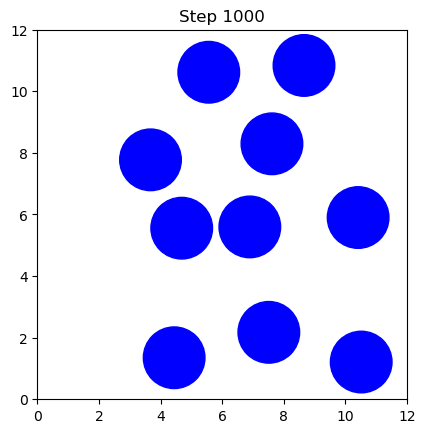

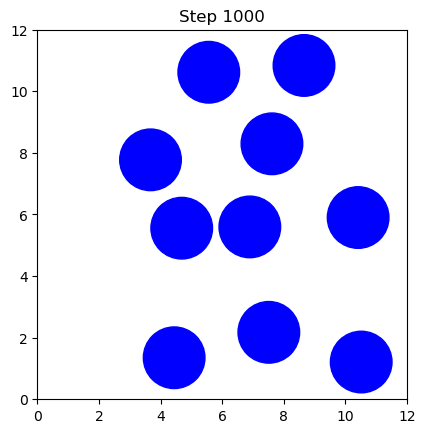

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Simulation parameters
n_particles = 10
box_size = 12.0
dt = 0.01
n_steps = 1000
particle_radius = 1
particle_mass = 1.0
elasticity = 1.0  # Elastic collisions

# Initialize particle positions and velocities
positions = np.random.rand(n_particles, 2) * (box_size - 2 * particle_radius) + particle_radius
velocities = np.random.randn(n_particles, 2) * 10

# Verlet algorithm for integration
def verlet_integration(positions, velocities, accelerations, dt):
    new_positions = positions + velocities * dt + 0.5 * accelerations * dt**2
    return new_positions

# Compute accelerations due to particle-particle collisions
def compute_accelerations(n_particles, positions, particle_radius):
    accelerations = np.zeros_like(positions)
    for i in range(n_particles):
        for j in range(i + 1, n_particles):
            delta_pos = positions[j] - positions[i]
            dist = np.linalg.norm(delta_pos)
            if dist < 2 * particle_radius:  # Particle collision
                overlap = 2 * particle_radius - dist
                direction = delta_pos / dist
                force = overlap * direction
                accelerations[i] -= force / particle_mass
                accelerations[j] += force / particle_mass
    return accelerations

# Collision with walls
def check_wall_collisions(positions, velocities, box_size, particle_radius):
    for i in range(n_particles):
        for dim in range(2):
            if positions[i, dim] < particle_radius:  # Left/Bottom wall
                velocities[i, dim] = abs(velocities[i, dim]) * elasticity
            elif positions[i, dim] > box_size - particle_radius:  # Right/Top wall
                velocities[i, dim] = -abs(velocities[i, dim]) * elasticity
    return velocities

# Update particle velocities after collision
def update_particle_velocities(positions, velocities, particle_radius):
    n_particles = len(positions)
    for i in range(n_particles):
        for j in range(i + 1, n_particles):
            delta_pos = positions[j] - positions[i]
            dist = np.linalg.norm(delta_pos)
            if dist < 2 * particle_radius:  # If particles are colliding
                # Normal vector
                normal = delta_pos / dist
                
                # Relative velocity
                relative_velocity = velocities[j] - velocities[i]
                
                # Velocity component in the direction of the normal
                normal_velocity = np.dot(relative_velocity, normal)
                
                # Update velocities if particles are overlapping
                if normal_velocity < 0:  # Only update if particles are moving towards each other
                    impulse = 2 * normal_velocity / (2 * particle_mass)
                    
                    # Apply impulse
                    velocities[i] += impulse * normal
                    velocities[j] -= impulse * normal
                
    return velocities

# Set up the figure and axis for plotting
fig, ax = plt.subplots()
ax.set_xlim(0, box_size)
ax.set_ylim(0, box_size)
ax.set_aspect('equal', adjustable='box')

# Initialize particles as circle patches
particles = [plt.Circle((positions[i, 0], positions[i, 1]), particle_radius, color='b') for i in range(n_particles)]
for particle in particles:
    ax.add_patch(particle)

# Function to update the plot and handle collisions
def update_plot():
    global positions, velocities
    
    # Compute accelerations and integrate
    #accelerations = compute_accelerations(n_particles, positions, particle_radius)
    accelerations = np.zeros_like(positions)
    new_positions = verlet_integration(positions, velocities, accelerations, dt)
    velocities = velocities + 0.5 * accelerations * dt  # Update velocities (half-step)
    
    # Check for wall collisions
    velocities = check_wall_collisions(new_positions, velocities, box_size, particle_radius)
    
    # Update particle positions
    positions[:] = new_positions
    
    # Update particle velocities due to collisions
    velocities = update_particle_velocities(positions, velocities, particle_radius)
    
    # Update circle positions in the plot
    for i, particle in enumerate(particles):
        particle.center = positions[i]

# Animation loop
for _ in range(n_steps):
    update_plot()
    ax.set_title(f"Step {_ + 1}")
    clear_output(wait=True)
    display(fig)


In [37]:
np.random.randn(n_particles, 2)

array([[ 0.54503233,  1.33649405],
       [ 0.69678599,  1.17026625],
       [ 1.17353867,  0.14539336],
       [ 2.04436719, -0.79767688],
       [-0.92264948, -0.11170433],
       [-1.38041684, -0.21546106],
       [ 0.97083012,  1.31785572],
       [ 0.73981913,  0.75702592],
       [ 0.5017976 , -1.74119326],
       [ 1.31863828, -1.2114178 ]])

In [25]:
matrix = np.array([[1, 2], [3, 4]])
norm = np.linalg.norm(matrix)
print(norm)

5.477225575051661


In [39]:
np.random.rand(npp, 1)

array([0.68277777])

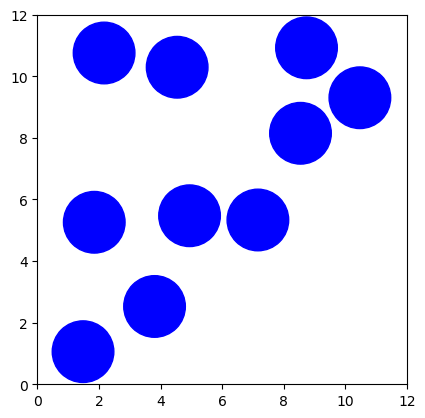

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Simulation parameters
n_particles = 10
box_size = 12.0
dt = 0.01
n_steps = 70000
particle_radius = 1
particle_mass = 1.0
elasticity = 1.0  # Elastic collisions

# Initialize particle positions and velocities
positions = np.random.rand(n_particles, 2) * (box_size - 2 * particle_radius) + particle_radius
velocities = np.random.randn(n_particles, 2) * 10

# Verlet algorithm for integration
def verlet_integration(positions, velocities, accelerations, dt):
    new_positions = positions + velocities * dt + 0.5 * accelerations * dt**2
    return new_positions


# Collision with walls
def check_wall_collisions(positions, velocities, box_size, particle_radius):
    for i in range(n_particles):
        for dim in range(2):
            if positions[i, dim] < particle_radius:  # Left/Bottom wall
                velocities[i, dim] = abs(velocities[i, dim]) * elasticity
            elif positions[i, dim] > box_size - particle_radius:  # Right/Top wall
                velocities[i, dim] = -abs(velocities[i, dim]) * elasticity
    return velocities

# Update particle velocities after collision
def update_particle_velocities(positions, velocities, particle_radius):
    n_particles = len(positions)
    for i in range(n_particles):
        for j in range(i + 1, n_particles):
            delta_pos = positions[j] - positions[i]
            dist = np.linalg.norm(delta_pos)
            if dist < 2 * particle_radius:  # If particles are colliding
                # Normal vector
                normal = delta_pos / dist
                
                # Relative velocity
                relative_velocity = velocities[j] - velocities[i]
                
                # Velocity component in the direction of the normal
                normal_velocity = np.dot(relative_velocity, normal)
                
                # Update velocities if particles are overlapping
                if normal_velocity < 0:  # Only update if particles are moving towards each other
                    impulse = 2 * normal_velocity / (2 * particle_mass)
                    
                    # Apply impulse
                    velocities[i] += impulse * normal
                    velocities[j] -= impulse * normal
                
    return velocities

# Set up the figure and axis for plotting
fig, ax = plt.subplots()
ax.set_xlim(0, box_size)
ax.set_ylim(0, box_size)
ax.set_aspect('equal', adjustable='box')

# Initialize particles as circle patches
particles = [plt.Circle((positions[i, 0], positions[i, 1]), particle_radius, color='b') for i in range(n_particles)]
for particle in particles:
    ax.add_patch(particle)

# Function to update the plot and handle collisions
def update_plot():
    global positions, velocities
    
    # Compute accelerations and integrate
    accelerations = np.zeros_like(positions)
    new_positions = verlet_integration(positions, velocities, accelerations, dt)
    velocities = velocities + 0.5 * accelerations * dt  # Update velocities (half-step)
    
    # Check for wall collisions
    velocities = check_wall_collisions(new_positions, velocities, box_size, particle_radius)
    
    # Update particle positions
    positions[:] = new_positions
    
    # Update particle velocities due to collisions
    velocities = update_particle_velocities(positions, velocities, particle_radius)
    
    # Update circle positions in the plot
    for i, particle in enumerate(particles):
        particle.center = positions[i]

# Animation loop
for _ in range(n_steps):
    update_plot()
    #ax.set_title(f"Step {_ + 1}")
    #clear_output(wait=True) #wait=True
    #display(fig)


In [7]:
np.mean(velocities)

-0.5213389108077117

In [8]:
np.mean(np.random.randn(n_particles, 2) * 10)

0.4465480436625559

In [5]:
random_integers

[82, 53, 25, 87, 52, 45, 91, 84, 64, 76]

In [ ]:
cc = [ i 

In [60]:
 xlist1 = [float('nan') for _ in range((10))]

In [61]:
xlist1

[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]

In [66]:
xlist1[2] = 10 if np.isnan(xlist1[2]) else xlist1[2]

In [67]:
xlist1

[nan, nan, 10, nan, nan, nan, nan, nan, nan, nan]

In [25]:
import math
xlist1[1]

nan

In [47]:
aa = np.genfromtxt('/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/Research/Bidisperse Project/output.txt')

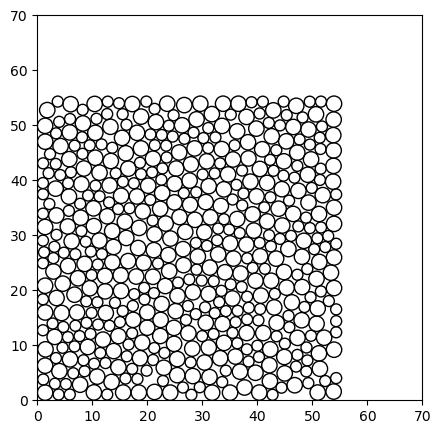

In [66]:
plot_circles(list(aa[:,1]), list(aa[:,2]), list(aa[:,0]))

In [60]:
len(list(aa[:,0]))

500

In [65]:
walls=[0,70]
def plot_circles(x,y,pr):
    fig, ax = plt.subplots(figsize=(5, 5), dpi=100)

    # Plot each circle
    for i in range(len(x)):
        circle = plt.Circle((x[i], y[i]), pr[i], edgecolor='black', facecolor='none')
        ax.add_patch(circle)

    ax.set_xlim(walls)
    ax.set_ylim(walls)
    ax.set_aspect('equal', 'box')
    plt.show()

In [8]:
import random

def generate_random_floats(min_value, max_value, count, min_separation):
    # Generate the first random float
    numbers = [random.uniform(min_value, max_value)]

    for _ in range(count - 1):
        while True:
            new_number = random.uniform(min_value, max_value)
            # Check the minimum separation condition
            if all(abs(new_number - num) >= min_separation for num in numbers):
                numbers.append(new_number)
                break

    return sorted(numbers)

# Parameters
min_value = 0
max_value = 10
count = 8  # Number of random floats
min_separation = 1  # Minimum separation between numbers

# Generate the random floats
random_floats = generate_random_floats(min_value, max_value, count, min_separation)

print(random_floats)

KeyboardInterrupt: 

In [2]:
x=[1,2,3,4,5]
y=[6,7,8,9,10]

In [3]:
a=np.outer(x,np.ones(5))
b=np.outer(x,np.ones(5)) 

In [8]:
amat = np.abs(a-a.transpose())
bmat = b-b.transpose()

In [5]:
a.transpose()

array([[1., 2., 3., 4., 5.],
       [1., 2., 3., 4., 5.],
       [1., 2., 3., 4., 5.],
       [1., 2., 3., 4., 5.],
       [1., 2., 3., 4., 5.]])

In [6]:
a

array([[1., 1., 1., 1., 1.],
       [2., 2., 2., 2., 2.],
       [3., 3., 3., 3., 3.],
       [4., 4., 4., 4., 4.],
       [5., 5., 5., 5., 5.]])

In [9]:
amat

array([[0., 1., 2., 3., 4.],
       [1., 0., 1., 2., 3.],
       [2., 1., 0., 1., 2.],
       [3., 2., 1., 0., 1.],
       [4., 3., 2., 1., 0.]])

In [11]:
amat[1,2]

-1.0

In [43]:
dist = np.sqrt(amat**2 + bmat**2)
dist

array([[0.        , 1.41421356, 2.82842712, 4.24264069, 5.65685425],
       [1.41421356, 0.        , 1.41421356, 2.82842712, 4.24264069],
       [2.82842712, 1.41421356, 0.        , 1.41421356, 2.82842712],
       [4.24264069, 2.82842712, 1.41421356, 0.        , 1.41421356],
       [5.65685425, 4.24264069, 2.82842712, 1.41421356, 0.        ]])

In [44]:
for i in range(len(x)):
    for j in range(i+1,len(y)):
        print(dist[i,j])

1.4142135623730951
2.8284271247461903
4.242640687119285
5.656854249492381
1.4142135623730951
2.8284271247461903
4.242640687119285
1.4142135623730951
2.8284271247461903
1.4142135623730951


In [34]:
y += y

In [12]:
aa= [1, 1, 1, 2, 2, 2, 3, 3, 3]

In [17]:
list(set(aa))

[1, 2, 3]

In [36]:
[a+b for a in x and b in y]

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [45]:
# -*- coding: utf-8 -*-
"""
Spyder Editor

This is a temporary script file.
"""
import numpy as np               # type: ignore
import matplotlib.pyplot as plt  # type: ignore
import time

start_time = time.time()

npp = 25
particleRadius = 1
kp = .5/200 # spring particle constant
kw = .5/200 # spring wall constant

walls = [0,10] # square box with wall at x and y = 0, 10 # 0 should not be changed or else it will change the wallForce

x = np.round(np.random.uniform(walls[0], walls[1], npp), 2) # 10 points between 0 to 10
y = np.round(np.random.uniform(walls[0], walls[1], npp), 2)  # 10 points between 0 to 10

def distance(xlist,ylist):
    xmat = np.outer(xlist,np.ones(npp))
    ymat = np.outer(ylist,np.ones(npp))

    xdist = xmat-xmat.transpose()
    ydist = ymat-ymat.transpose()

    dist = np.sqrt(xdist**2 + ydist**2)

    return xdist, ydist, dist

def contForce(xdist, ydist, distMat, pr):
    '''
    pr is particle radius
    '''
    contx1, conty1 = np.zeros(distMat.shape[0]), np.zeros(distMat.shape[1])
    # getting the lower matrix items from the symmetric distance matrix
    for i in range(distMat.shape[0]):
        for j in range(i+1, distMat.shape[1]):
            if distMat[i,j] < 2*pr:
                contx1[i] += -kp * (2*pr- xdist[i,j])/2 # force = - k*x/2 (divided by two since both particles move half way apart)
                contx1[j] += kp * (2*pr - xdist[i,j])/2
                conty1[i] += -kp * (2*pr - ydist[i,j])/2
                conty1[j] += kp * (2*pr - ydist[i,j])/2
    return contx1, conty1

def wallForce(x1,y1,pr):

    wallx1, wally1 = np.zeros(len(x1)), np.zeros(len(y1))
    
    for ii in range(len(x1)):
        if x1[ii] < pr:
            wallx1[ii] += kw*(pr - x1[ii])
            
        elif x1[ii] > walls[1]-pr:
            wallx1[ii] += -kw*(pr - (walls[1] - x1[ii]))
            
        if y1[ii] < pr:
            wally1[ii] += kw*(pr - y1[ii])
            
        elif y1[ii] > walls[1]-pr:
            wally1[ii] += -kw*(pr - (walls[1] - y1[ii]))
    
    return wallx1, wally1

plt.clf()
#fig, ax = plt.subplots(figsize=(8, 8), dpi=300)

def plot_circles(x,y,pr):
    #ax.cla() 
    
    fig, ax = plt.subplots(figsize=(8, 8), dpi=300)

    # Plot each circle
    for i in range(len(x)):
        circle = plt.Circle((x[i], y[i]), pr, edgecolor='black', facecolor='none')
        ax.add_patch(circle)

    # Set the limits of the plot
    ax.set_xlim(walls)
    ax.set_ylim(walls)

    # Set the aspect ratio to be equal
    ax.set_aspect('equal', 'box')

    # Show the plot
    plt.show()
    #plt.draw()
    #plt.pause(0.1)
    plt.close(fig)

#fig, ax = plt.subplots(figsize=(8, 8), dpi=300)
s = 0
dr = .001 # step size increase
rlin = np.arange(dr, particleRadius+dr, dr)
forceList = []

for jj in range(len(rlin)):
    while True:
        s += 1
        pr = rlin[jj]
        #if s%1e5 == 0:
            #plot_circles(x,y,pr)
        # contact forces
        xdist, ydist, dist = distance(x,y)
        contx, conty = contForce(xdist, ydist, dist, pr)
    
        # wall forces
        wallx, wally = wallForce(x, y, pr)
    
        #netForce = np.sum(list(contx)+ list(conty)+ list(wallx)+ list(wally))
        netForce = sum(abs(a) for a in contx+conty+wallx+wally)
        #if s%1e1 == 0:
            #forceList.append(netForce)
        
        if netForce > 1e-9:
            x = [a+b+c for a,b,c in zip(x, contx, wallx)]
            y = [a+b+c for a,b,c in zip(y, conty, wally)]
            
            #x = [a if a >= pr else pr for a in x]
            #y = [a if a >= pr else pr for a in y]
            
            #x = [a if (walls[1]-a) >= pr else pr for a in x]
            #y = [a if (walls[1]-a) >= pr else pr for a in y]
            
        else:
            break
            
print('Done\n')
end_time = time.time()
elapsed_time = (end_time - start_time)/60
print(f"Elapsed time: {elapsed_time} mins")

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

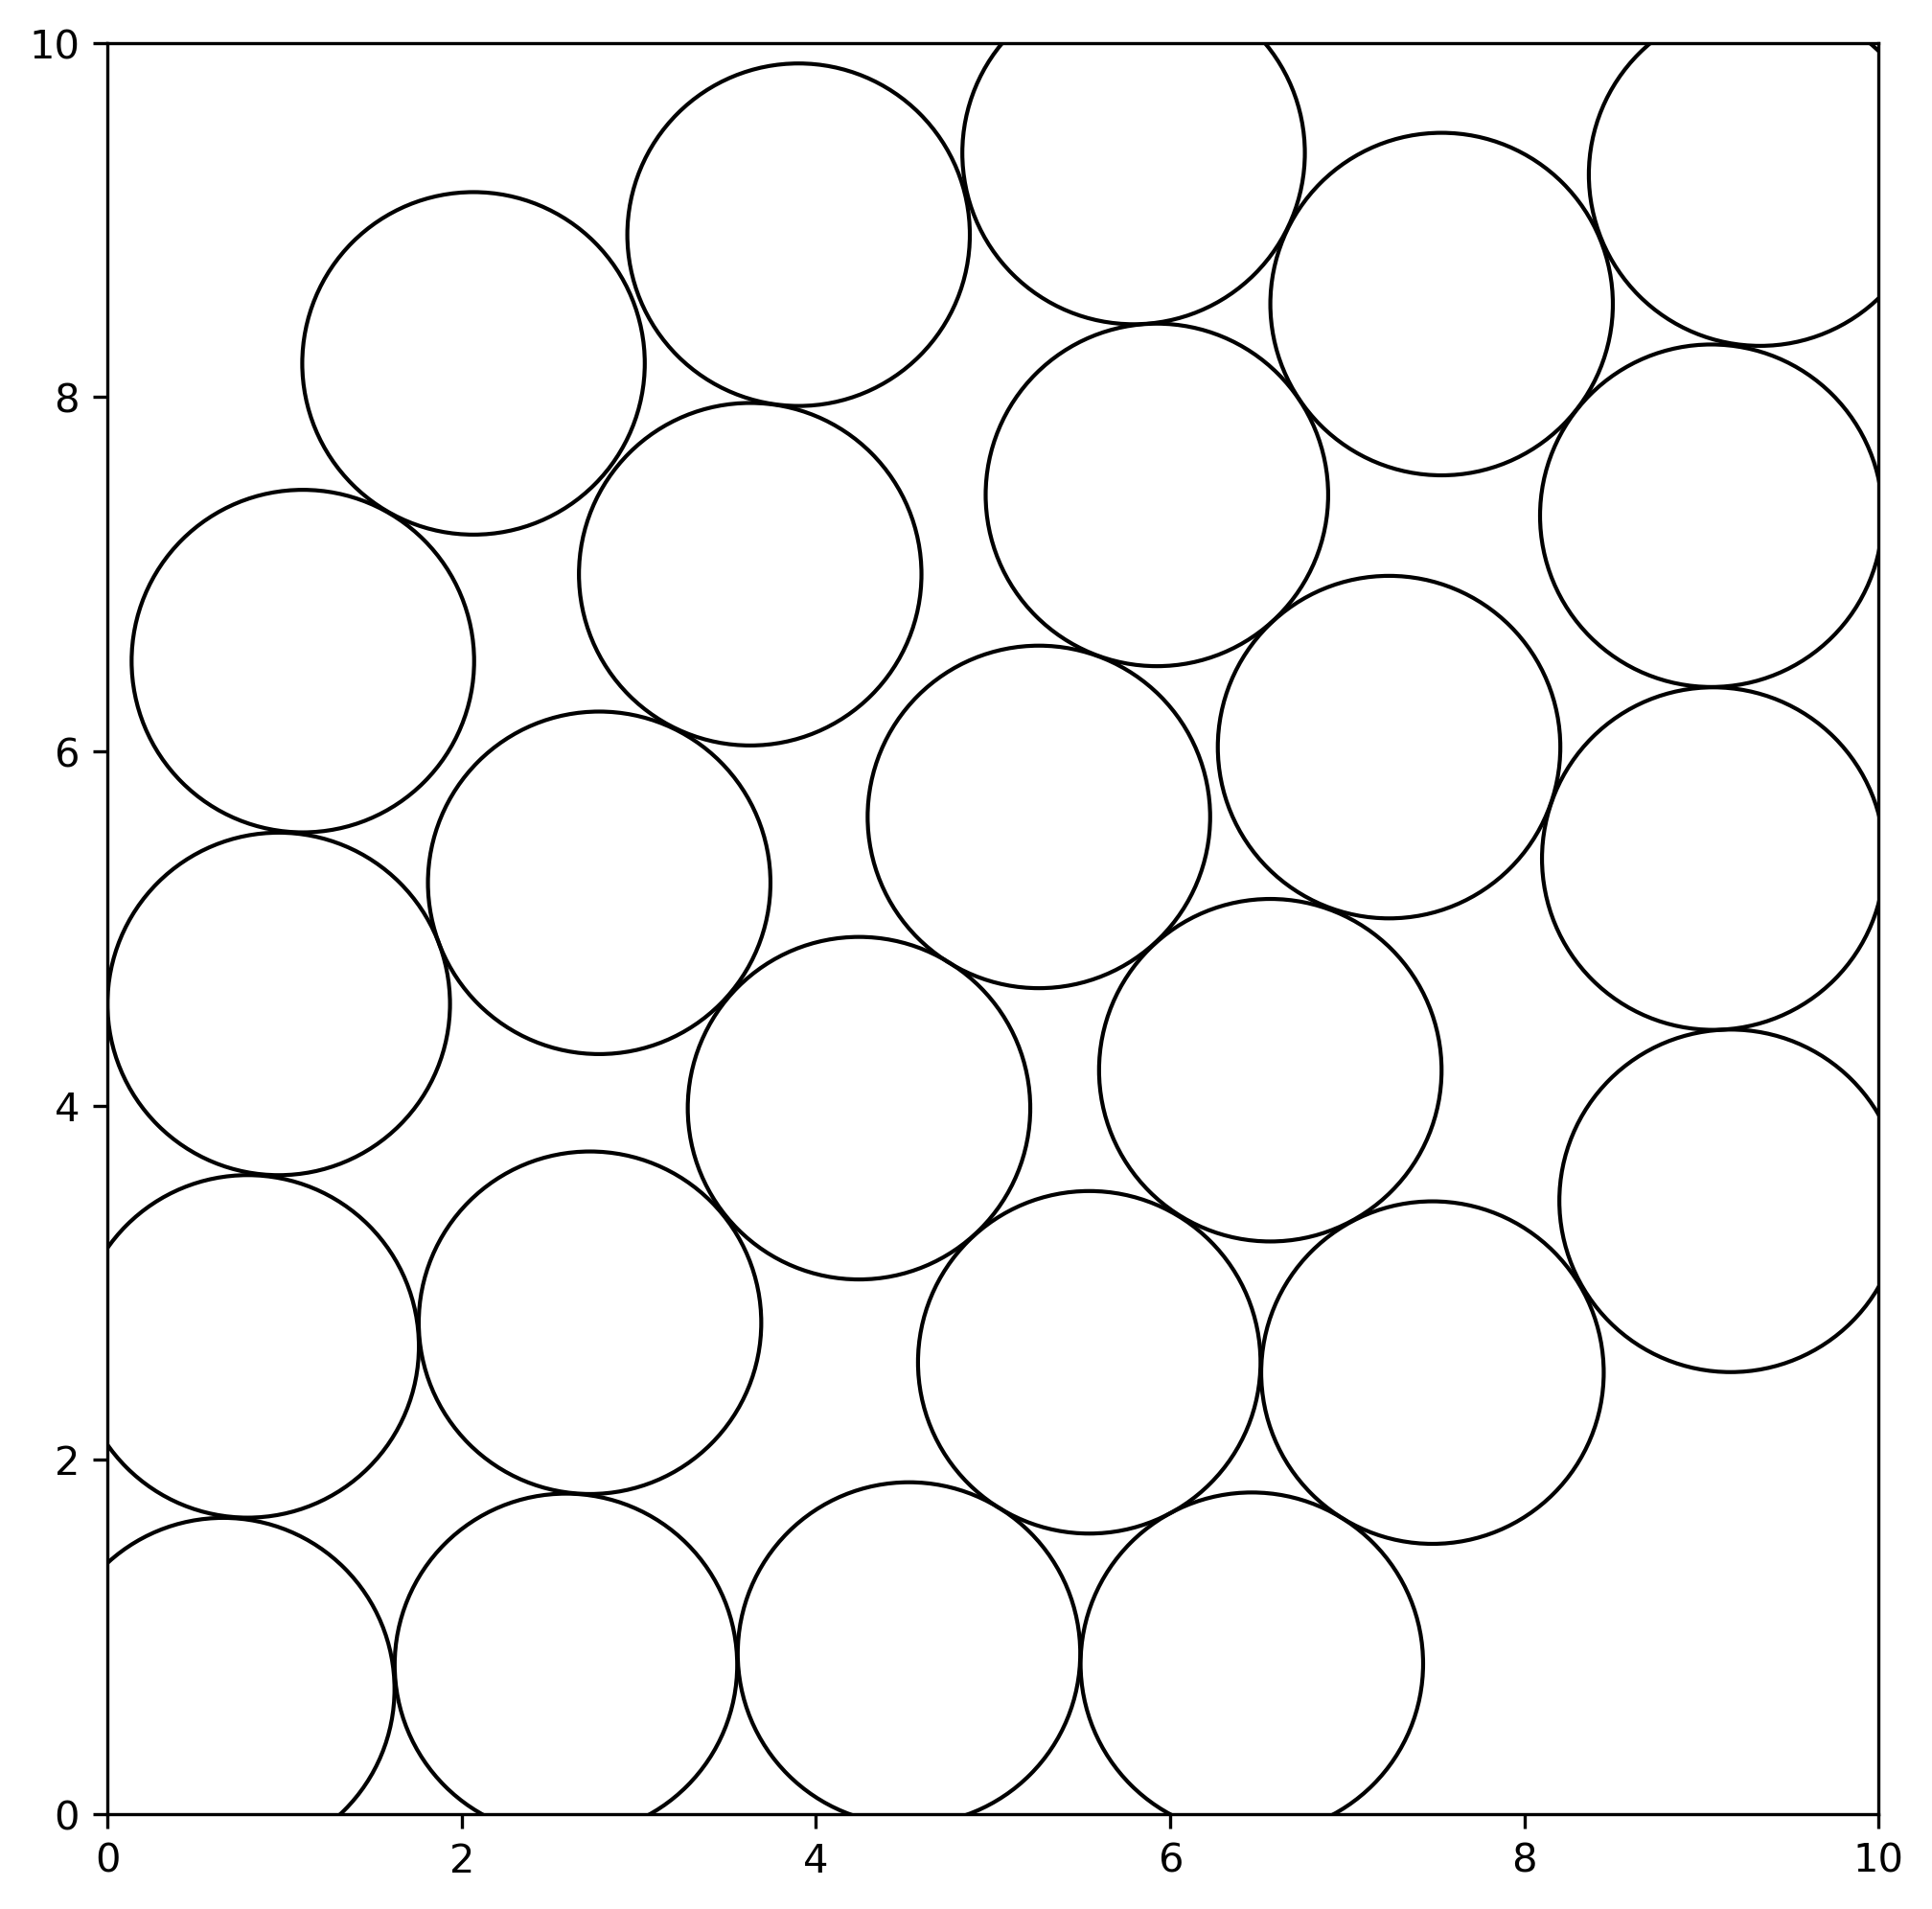

In [46]:
plot_circles(x,y,pr)

In [15]:
xdist

array([[ 0.  , -2.35, -6.44, -3.82, -5.09],
       [ 2.35,  0.  , -4.09, -1.47, -2.74],
       [ 6.44,  4.09,  0.  ,  2.62,  1.35],
       [ 3.82,  1.47, -2.62,  0.  , -1.27],
       [ 5.09,  2.74, -1.35,  1.27,  0.  ]])

In [4]:
# gap statistics
# first loading par and int file

#def interactionsList(interactionFile):
'''
This function reads the interaction file and creates a nested-list,
each list inside contains the array of all interaction parameters for
that timestep.

Input: interactionFile - the location of the interaction data file
'''
parFile2 = glob.glob('/media/rahul/Rahul_2TB/high_bidispersity/NP_1000/phi_0.74/ar_1.4/Vr_0.5/run_2/par_*')[0]

parFile = open(parFile2, 'r')

hashCounter = 0
temp        = []
parList = [] # list with interaction parameters for each element at each timestep

fileLines = parFile.readlines()[22:] # skipping the comment lines
for line in fileLines:
    if not line.split()[0] == '#':
        lineList = [float(value) for value in line.split()]
        temp.append(lineList)
    else:
        hashCounter += 1 # checking if counter reaches 7 (7 lines of comments after every timestep data)
        if hashCounter == 7: 
            parList.append(np.array(temp))
            temp        = []
            hashCounter = 0
parFile.close()
#parList

####
intFile = glob.glob('/media/rahul/Rahul_2TB/high_bidispersity/NP_1000/phi_0.74/ar_1.4/Vr_0.5/run_2/int_*')[0]
interactionFile   = open(intFile, 'r')
#contactList = interactionsList(interFile) 
'''
This function reads the interaction file and creates a nested-list,
each list inside contains the array of all interaction parameters for
that timestep.

Input: interactionFile - the location of the interaction data file
'''

hashCounter = 0
temp        = []
contactList = [] # list with interaction parameters for each element at each timestep

fileLines = interactionFile.readlines()[27:] # skipping the comment lines
for line in fileLines:
    if not line.split()[0] == '#':
        lineList = [float(value) for value in line.split()]
        temp.append(lineList)
    else:
        hashCounter += 1 # checking if counter reaches 7 (7 lines of comments after every timestep data)
        if hashCounter == 7: 
            contactList.append(np.array(temp))
            temp        = []
            hashCounter = 0
interactionFile.close()

##
datFile = glob.glob('/media/rahul/Rahul_2TB/high_bidispersity/NP_1000/phi_0.74/ar_1.4/Vr_0.5/run_2/data_*')[0]
lx = np.genfromtxt(datFile, skip_header=3, max_rows=1, comments = '_')[2]
lz = np.genfromtxt(datFile, skip_header=5, max_rows=1, comments = '_')[2]
# we now have contactList and parList

In [8]:
t, gamma, gammapt, _,  _, _, _, _, _, _, \
_, _, _, minGap, _, _, _, _, _, _,       \
_, _, _, _,  _, _, _, _, _, _            \
= np.loadtxt(datFile, skiprows=37).transpose()

In [2]:
len(parList)

NameError: name 'parList' is not defined

In [9]:
#interacting particles
timeSample = 1000
part1 = contactList[timeSample][:,0]
part2 = contactList[timeSample][:,1]

particleRadius = parList[0][:,1] # size of all particles

gap=[] #gap for each interaction pair
partDist =[]


for i in range(contactList[timeSample].shape[0]):
    
    cdist = particleRadius[int(part1[i])] + particleRadius[int(part2[i])]
    
    xpos1 = parList[timeSample][int(part1[i]),2]
    zpos1 = parList[timeSample][int(part1[i]),3]
    
    xpos2 = parList[timeSample][int(part2[i]),2]
    zpos2 = parList[timeSample][int(part2[i]),3]
    
    dist = np.sqrt((xpos2-xpos1)**2 + (zpos2-zpos1)**2)
    partDist.append(dist)
    
    # correcting for boundaries
    if dist > 70:
        if xpos1 < 0:
            xpos1 = xpos1 + gamma[timeSample]*lz
        else:
            xpos1 = xpos1 - gamma[timeSample]*lz
            
        if zpos1 < 0:
            zpos1 = zpos1 + lz
        else:
            zpos1 = zpos1 - lz
            
        dist = np.sqrt((xpos2-xpos1)**2 + (zpos2-zpos1)**2)
        dist2 = 2*dist/(
        
    gapp = dist - cdist
    gap.append(gapp)

In [19]:
#interacting particles # part 2

timeSample = 1000
part1 = contactList[timeSample][:,0]
part2 = contactList[timeSample][:,1]

particleRadius = parList[0][:,1] # size of all particles

gap=[] #gap for each interaction pair
partDist =[]

for i in range(contactList[timeSample].shape[0]):
    
    cdist = particleRadius[int(part1[i])] + particleRadius[int(part2[i])]
    
    xpos1 = parList[timeSample][int(part1[i]),2]
    zpos1 = parList[timeSample][int(part1[i]),3]
    
    xpos2 = parList[timeSample][int(part2[i]),2]
    zpos2 = parList[timeSample][int(part2[i]),3]
    
    dist = np.sqrt((xpos2-xpos1)**2 + (zpos2-zpos1)**2)
    #partDist.append(dist)
    dist2 = (2*dist/cdist)-2
        
    #gapp = dist - cdist
    gap.append(dist2)

In [ ]:
## next line of action

# try correctign the boudary condition part since there are few distances > 70

In [87]:
partDist # distances of interacting particles for a time sample

[2.051559387831608,
 1.9998520234257333,
 2.9997668742753993,
 2.1485477188091475,
 2.002934210102768,
 2.2035063128795445,
 1.999808659847237,
 2.9999507530791236,
 2.999140016738132,
 2.1121437498427964,
 2.157382536779236,
 2.9992576031411504,
 1.9999495527177678,
 2.9999950416625674,
 1.9995547588400777,
 1.999225217734361,
 2.1377764827034618,
 3.101522988791151,
 1.9999179507169773,
 2.200517943576012,
 2.339344773649234,
 2.4524262677805426,
 4.734856163602016,
 2.429825353806318,
 3.0423978470936377,
 2.0466401907760923,
 2.999835332147418,
 2.00193965598991,
 4.014923968408367,
 2.9989794478857297,
 1.9997899139659632,
 80.93210922594321,
 1.9998028903869507,
 2.2221450177699946,
 2.9987976472079576,
 2.3181487139525787,
 1.9990115482407769,
 2.9991486208589277,
 3.0504784428020457,
 1.999367914717049,
 2.9999335459306447,
 1.9998219736766558,
 79.42341452871439,
 3.2077404711104656,
 4.344538562537573,
 4.000513779503828,
 2.999668748795439,
 4.4446469848571795,
 2.9998453776

In [88]:
max(partDist)

82.30428712436553

In [ ]:
partDist

In [20]:
gap # gap between particles

[-0.00044726528933680676,
 0.1873215630080547,
 -0.0004414721938104105,
 0.07725723404685692,
 0.09592696914754084,
 0.3860637921061558,
 -0.00010034001702940998,
 84.46239829769291,
 0.09042895358823655,
 0.008893904714729395,
 0.2854929394115393,
 0.0001263050395388099,
 -0.0003516897929567442,
 0.20732142068981663,
 0.09532261287227328,
 0.2023700075146344,
 -0.0006052039531605491,
 0.1700289145539049,
 0.2123579502422306,
 0.03189494547440885,
 0.2848246255335316,
 0.006644882303163513,
 -0.00016548427681839506,
 0.013137859685723452,
 71.01382980374335,
 0.025962647730701782,
 0.15153074222103857,
 0.37289482489216264,
 -0.0001024799005335808,
 -0.00034150658724430016,
 -8.758275390929882e-05,
 0.0017471344497481667,
 -6.566376890382308e-05,
 58.58076691653971,
 50.49864875423374,
 -0.0005002413798038674,
 -0.0009100370418557713,
 0.49462646379724573,
 -0.00017438260232260916,
 0.26231746003959344,
 0.010104799208489279,
 -0.00014825421931585758,
 0.2000029198212938,
 0.3941761547

In [21]:
mingap = list(contactList[timeSample][:,5])

In [24]:
temp=[]
for ii, sampleList in enumerate(contactList[100:]):
    gap1 = [a*100/2 for a in sampleList[:,5]]
    temp.append(gap1)

In [26]:
temp1 = [a for sublist in temp for a in sublist]

In [27]:
len(temp1)

7693112

In [3]:
import numpy             as np
import matplotlib.pyplot as plt


plt.close('all')
plt.rcParams.update({
  'figure.max_open_warning': 0,
  'text.usetex':             True,
  'figure.autolayout':       True,
  'font.family':             "STIXGeneral",
  'mathtext.fontset':        "stix",
  'font.size':              10,
  'axes.titlesize':         10,
  'figure.labelsize':       10,
  'figure.titlesize':       10,
  'legend.fontsize':        10,
  'legend.handlelength':     1,
  'legend.handletextpad':    0.5,
  'legend.borderpad':        0.5,
  'legend.borderaxespad':    0.5,
  'legend.columnspacing':    1,
  'legend.framealpha':       1,
  'legend.fancybox':         True,
  'axes.grid':               True,
  'axes.grid.axis':          'both',
  'grid.alpha':              0.2,
  'grid.linewidth':          0.4,
  'xtick.labelsize':        10,
  'ytick.labelsize':        10,
  'lines.linewidth':         1,
  'lines.markersize':        5,
  'savefig.transparent':     True,
  'savefig.pad_inches':      0.01,
  'savefig.format':          'pdf',
  'savefig.bbox':            'tight'
})
plt.rcParams['text.latex.preamble']= r"\usepackage{amsmath}"

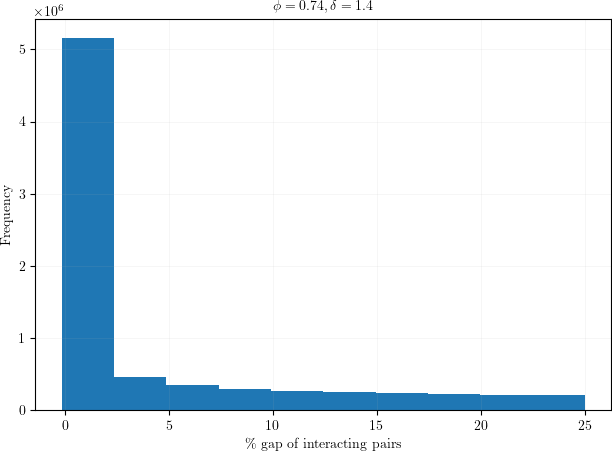

In [44]:
import matplotlib.pyplot as plt
plt.hist(temp1, bins=10)
plt.xlabel(r'\% gap of interacting pairs')
plt.ylabel('Frequency')
plt.title(r'$\phi = 0.74, \delta = 1.4$')
file_path = '/home/rahul/Dropbox (City College)/CUNY/Research/Bidisperse Project/analysis/figures/minGap/histogram.jpeg'

# Save the histogram to the specified file path
plt.savefig(file_path)

# Display the plot
plt.show()

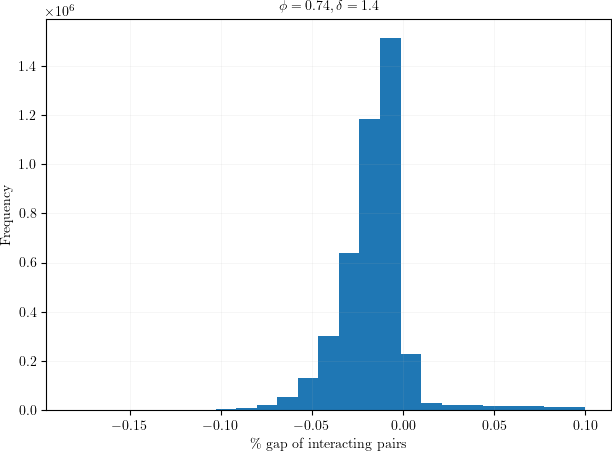

In [45]:
temp2 = [ a for a in temp1 if a < 0.1]
plt.hist(temp2,bins=25)
plt.xlabel(r'\% gap of interacting pairs')
plt.ylabel('Frequency')
plt.title(r'$\phi = 0.74, \delta = 1.4$')
file_path = '/home/rahul/Dropbox (City College)/CUNY/Research/Bidisperse Project/analysis/figures/minGap/histogram2.jpeg'

# Save the histogram to the specified file path
plt.savefig(file_path)

# Display the plot
plt.show()

In [22]:
mingap

[-0.000414616,
 0.187345,
 -0.000385461,
 0.0772572,
 0.0958996,
 0.386031,
 -0.000155925,
 0.366609,
 0.0904157,
 0.00888419,
 0.285508,
 0.000150776,
 -0.000371161,
 0.207348,
 0.0953468,
 0.2023,
 -0.000619442,
 0.170034,
 0.212345,
 0.0318597,
 0.284827,
 0.00667346,
 -0.000181065,
 0.0131042,
 0.00369616,
 0.0260245,
 0.151603,
 0.372856,
 -6.98205e-05,
 -0.000317472,
 -0.000110921,
 0.00174688,
 -7.30457e-05,
 -0.00103573,
 -2.62509e-05,
 -0.000445154,
 -0.000869557,
 0.494617,
 -0.000203195,
 0.262415,
 0.0101066,
 -0.000144042,
 0.20001,
 0.39417,
 -6.77581e-05,
 0.000996354,
 -0.000180196,
 -0.000453674,
 -0.000144612,
 0.180373,
 0.464011,
 -0.000137677,
 0.0887321,
 -0.000973892,
 -0.000205608,
 -3.62773e-05,
 0.005423,
 0.0103023,
 0.134599,
 0.00342225,
 0.324607,
 -0.000840693,
 0.0162409,
 0.119656,
 -6.08195e-05,
 0.489378,
 -0.000730934,
 -0.000346775,
 0.465891,
 0.000971161,
 0.0150622,
 0.198776,
 0.0231221,
 0.00252186,
 0.194835,
 -0.000129843,
 -0.000226979,
 -0.

In [40]:
kk=[round(a - b) for a in gap for b in list(contactList[timeSample][:,5]+2)]

AttributeError: 'list' object has no attribute 'min'

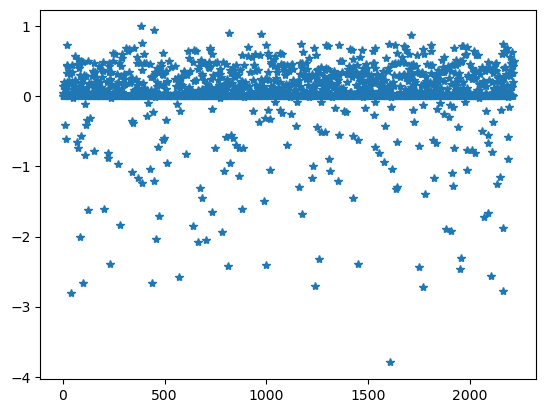

In [77]:
plt.plot(gap,'*')

In [5]:
75/(2*np.pi)

11.93662073189215

In [8]:
np.log(5/3.6)/2

0.16425203348601802

In [1]:
a=[[] for _ in range(4)]

In [2]:
# plotting different contacts in the system for a phi value
# plotting small-small, large-large and small-large contacts on one plot


#topDir   = "/Volumes/Rahul_2TB/high_bidispersity/"
topDir      = "/media/rahul/Rahul_2TB/high_bidispersity/"

contFile = 'contacts.txt'

NP       = [1000]

run      = {500:8,1000:4,2000:2,4000:1}

phi      = [0.75]

ar       = [1.0, 1.4, 1.8, 2.0, 4.0]

off = 100

cmap = matplotlib.colormaps['viridis_r'] #color scheme

for ii in range(len(NP)):
    for j in range(len(phi)):
        phir       = '{:.3f}'.format(phi[j]) if len(str(phi[j]).split('.')[1])>2 else '{:.2f}'.format(phi[j])
        contType   = ['Total contacts', 'S-S contacts', 'S-L contacts', 'L-L contacts']
        conList    = [[] for _ in range(len(contType))]
        conStdList = [[] for _ in range(len(contType))]

        for k in range(len(ar)):
            dataname=topDir+'NP_'+str(NP[ii])+'/phi_'+phir+'/ar_'+str(ar[k])+'/Vr_0.5'
            if os.path.exists(dataname):
                temp    = [[] for _ in range(len(contType))]
                tempStd = [[] for _ in range(len(contType))]
                
                for l in range (run[NP[ii]]):
                    conFile  = open(f'{dataname}/run_{l+1}/{contFile}', 'r')
                    contData = np.loadtxt(conFile) # reading only column 3 which has particle size
                    conFile.close()
                    
                    for ik in range(len(temp)):
                        ZnetCont = [ a / b for a, b in zip(contData[off:,ik*2], contData[off:,(ik*2)+1]) if b != 0 ]
                        temp[ik].append(np.mean(ZnetCont))
                        tempStd[ik].append(np.var(ZnetCont))
                    
                for ij in range(len(temp)):
                    conList[ij].append(np.mean(temp[ij]))
                    conStdList[ij].append(np.sqrt(np.mean(tempStd[ij])))
        
        for il in range(len(conList)):
            plt.errorbar(ar, conList[il], yerr = conStdList[il], fmt='--o', label = contType[il], color=cmap((il+1)/len(ar)), capsize=2, linewidth=1.2, elinewidth=0.5)
        
        plt.grid(which='Both', alpha=0.2)

        plt.title(fr"$\phi = {phir}$", fontsize=18)
        plt.xlabel(r'$\delta$', fontsize=14,fontstyle='italic')
        plt.ylabel(r'$\langle Z_{net} \rangle$', fontsize=14,fontstyle='italic')

        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(fontsize=10, labelspacing=1,borderpad=1, loc=(0.65, 0.66))

        plt.tight_layout()
        if False:
            figFormat=".pdf"
            fig_save_path = "/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/Research/Bidisperse Project/analysis/figures/contacts"
            plt.savefig(fig_save_path+'/contacts_NP_'+str(1000)+'_phi_'+str(phi[j])+figFormat, bbox_inches="tight",dpi=500)

        plt.show()

[[], [], [], []]

In [3]:
a=[0]*4

In [4]:
a

[0, 0, 0, 0]

In [6]:
a[2] = 3

In [7]:
a

[0, 0, 3, 0]

In [3]:
angleBins  = np.linspace(-np.pi, np.pi,72)
binCenters = (angleBins[:-1] + angleBins[1:])/2

In [5]:
int(np.floor(len(binCenters)/2))

35

In [34]:
binCenters[70]

3.097344869736416

In [6]:
theta = np.round(0.5144796631234967,2)

In [7]:
bin_Index = np.argmin(np.abs(binCenters - theta))
#forceList[bin_Index] += forceVal
if theta < 0:
    theta2    = np.pi - abs(theta)
    #bin_Index2 = np.argmin(np.abs(binCenters - theta2))
else:
    theta2    = theta - np.pi
    
bin_Index2 = np.argmin(np.abs(binCenters - theta2))
#forceList[[bin_Index, bin_Index2]] += forceVal

In [8]:
theta, bin_Index

(0.51, 41)

In [9]:
binCenters[bin_Index] 

0.5309734062405285

In [10]:
abs(binCenters[bin_Index-1] - theta), abs(binCenters[bin_Index] - theta), abs(binCenters[bin_Index+1] - theta)

(0.06752216146622647, 0.020973406240528458, 0.10946897394728317)

In [11]:
theta2, bin_Index2

(-2.6315926535897933, 5)

In [12]:
binCenters[bin_Index2] 

-2.6548670312026417

In [15]:
35+bin_Index2

40

In [14]:
abs(binCenters[bin_Index2-1] - theta2), abs(binCenters[bin_Index2] - theta2), abs(binCenters[bin_Index2+1] - theta2)

(0.11176994531960371, 0.02327437761284834, 0.06522119009390615)

In [122]:
binCenters

array([-3.09734487, -3.0088493 , -2.92035373, -2.83185817, -2.7433626 ,
       -2.65486703, -2.56637146, -2.4778759 , -2.38938033, -2.30088476,
       -2.21238919, -2.12389362, -2.03539806, -1.94690249, -1.85840692,
       -1.76991135, -1.68141579, -1.59292022, -1.50442465, -1.41592908,
       -1.32743352, -1.23893795, -1.15044238, -1.06194681, -0.97345124,
       -0.88495568, -0.79646011, -0.70796454, -0.61946897, -0.53097341,
       -0.44247784, -0.35398227, -0.2654867 , -0.17699114, -0.08849557,
        0.        ,  0.08849557,  0.17699114,  0.2654867 ,  0.35398227,
        0.44247784,  0.53097341,  0.61946897,  0.70796454,  0.79646011,
        0.88495568,  0.97345124,  1.06194681,  1.15044238,  1.23893795,
        1.32743352,  1.41592908,  1.50442465,  1.59292022,  1.68141579,
        1.76991135,  1.85840692,  1.94690249,  2.03539806,  2.12389362,
        2.21238919,  2.30088476,  2.38938033,  2.4778759 ,  2.56637146,
        2.65486703,  2.7433626 ,  2.83185817,  2.92035373,  3.00

In [62]:
binCenters[35]

0.0

In [94]:
import pandas as pd

In [75]:
a[[1,3]] += 20

In [76]:
a

array([ 0.72568799, 40.99084048,  0.21322581, 40.16481093,  0.27166934,
        0.64224686,  0.41489585,  0.7640976 ,  0.86664531,  0.27934632])

In [ ]:
a = []

In [1]:
import random

# Generate a list of length 1000 with random choices of 1 and 2
random_list = [random.choice([1, 2]) for _ in range(1000)]

# Print the first 10 elements to verify
print(random_list[:10])


[2, 2, 2, 2, 1, 1, 1, 2, 1, 1]


In [4]:
random_list.count(2)

521

In [23]:
import random

NP          = [1000]

particleSize = [1]*(int(NP[0]/2)) + [2]*(int(NP[0]/2))
random.shuffle(particleSize)

In [26]:
particleSize.count(1)

1000

In [17]:
2*list(ones_and_twos).count(2)

10

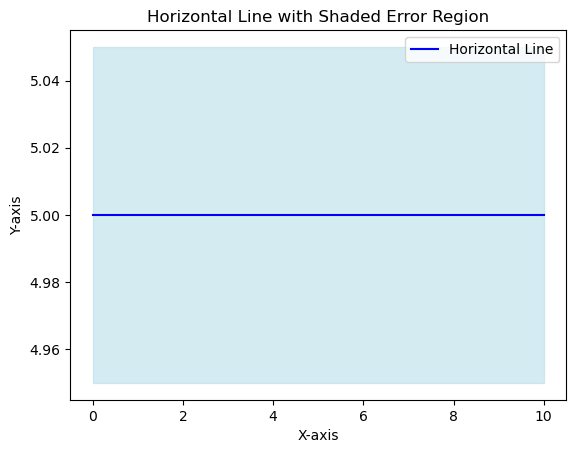

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data for the horizontal line
x = np.linspace(0, 10, 100)
y = np.ones_like(x) * 5  # Horizontal line at y=5
error = 0.05  # Uniform error

# Plot the horizontal line
plt.plot(x, y, label='Horizontal Line', color='blue')

# Add shaded region for the uniform error
plt.fill_between(x, y - error, y + error, color='lightblue', alpha=0.5)

# Add labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Horizontal Line with Shaded Error Region')
plt.legend()

# Show the plot
plt.show()


In [2]:
plt.close('all')
plt.rcParams.update({
  "figure.max_open_warning": 0,
  "text.usetex": True,
  "figure.autolayout": True,
  "font.family": "STIXGeneral",
  "mathtext.fontset": "stix",
  "font.size":        10,
  "xtick.labelsize":  10,
  "ytick.labelsize":  10,
  "lines.linewidth":  1,
  "lines.markersize": 5
})
plt.rcParams['text.latex.preamble']= r"\usepackage{amsmath}"

#matplotlib.use('TkAgg')

In [5]:
import os
import matplotlib                   # type: ignore
import numpy             as     np  # type: ignore
import matplotlib.pyplot as     plt # type: ignore

In [6]:
filePath = '/media/rahul/Linux_1TB_HDD/Bidisperse_project/NP_1000/phi_0.72/ar_1.4/Vr_0.5/run_2/'

In [7]:
parFile1 = filePath + 'par_random_seed_params_stress100r_shear.dat'

hashCounter = 0
temp        = []
particlesList = [] # list with interaction parameters for each element at each timestep

parFile      = open(parFile1, 'r')

fileLines = parFile.readlines()[22:] # skipping the comment lines

nn = 0
for line in fileLines:
    if not line.split()[0] == '#':
        lineList = [float(value) for value in line.split()]
        temp.append(lineList)
        #nn += nParticles
    else:
        hashCounter += 1 # checking if counter reaches 7 (7 lines of comments after every timestep data)
        if hashCounter == 7: 
            particlesList.append(np.array(temp))
            temp        = []
            hashCounter = 0
parFile.close()

In [8]:
len(particlesList[1])

1000

In [20]:
np.mean(particlesList[80])

45.575609715585635

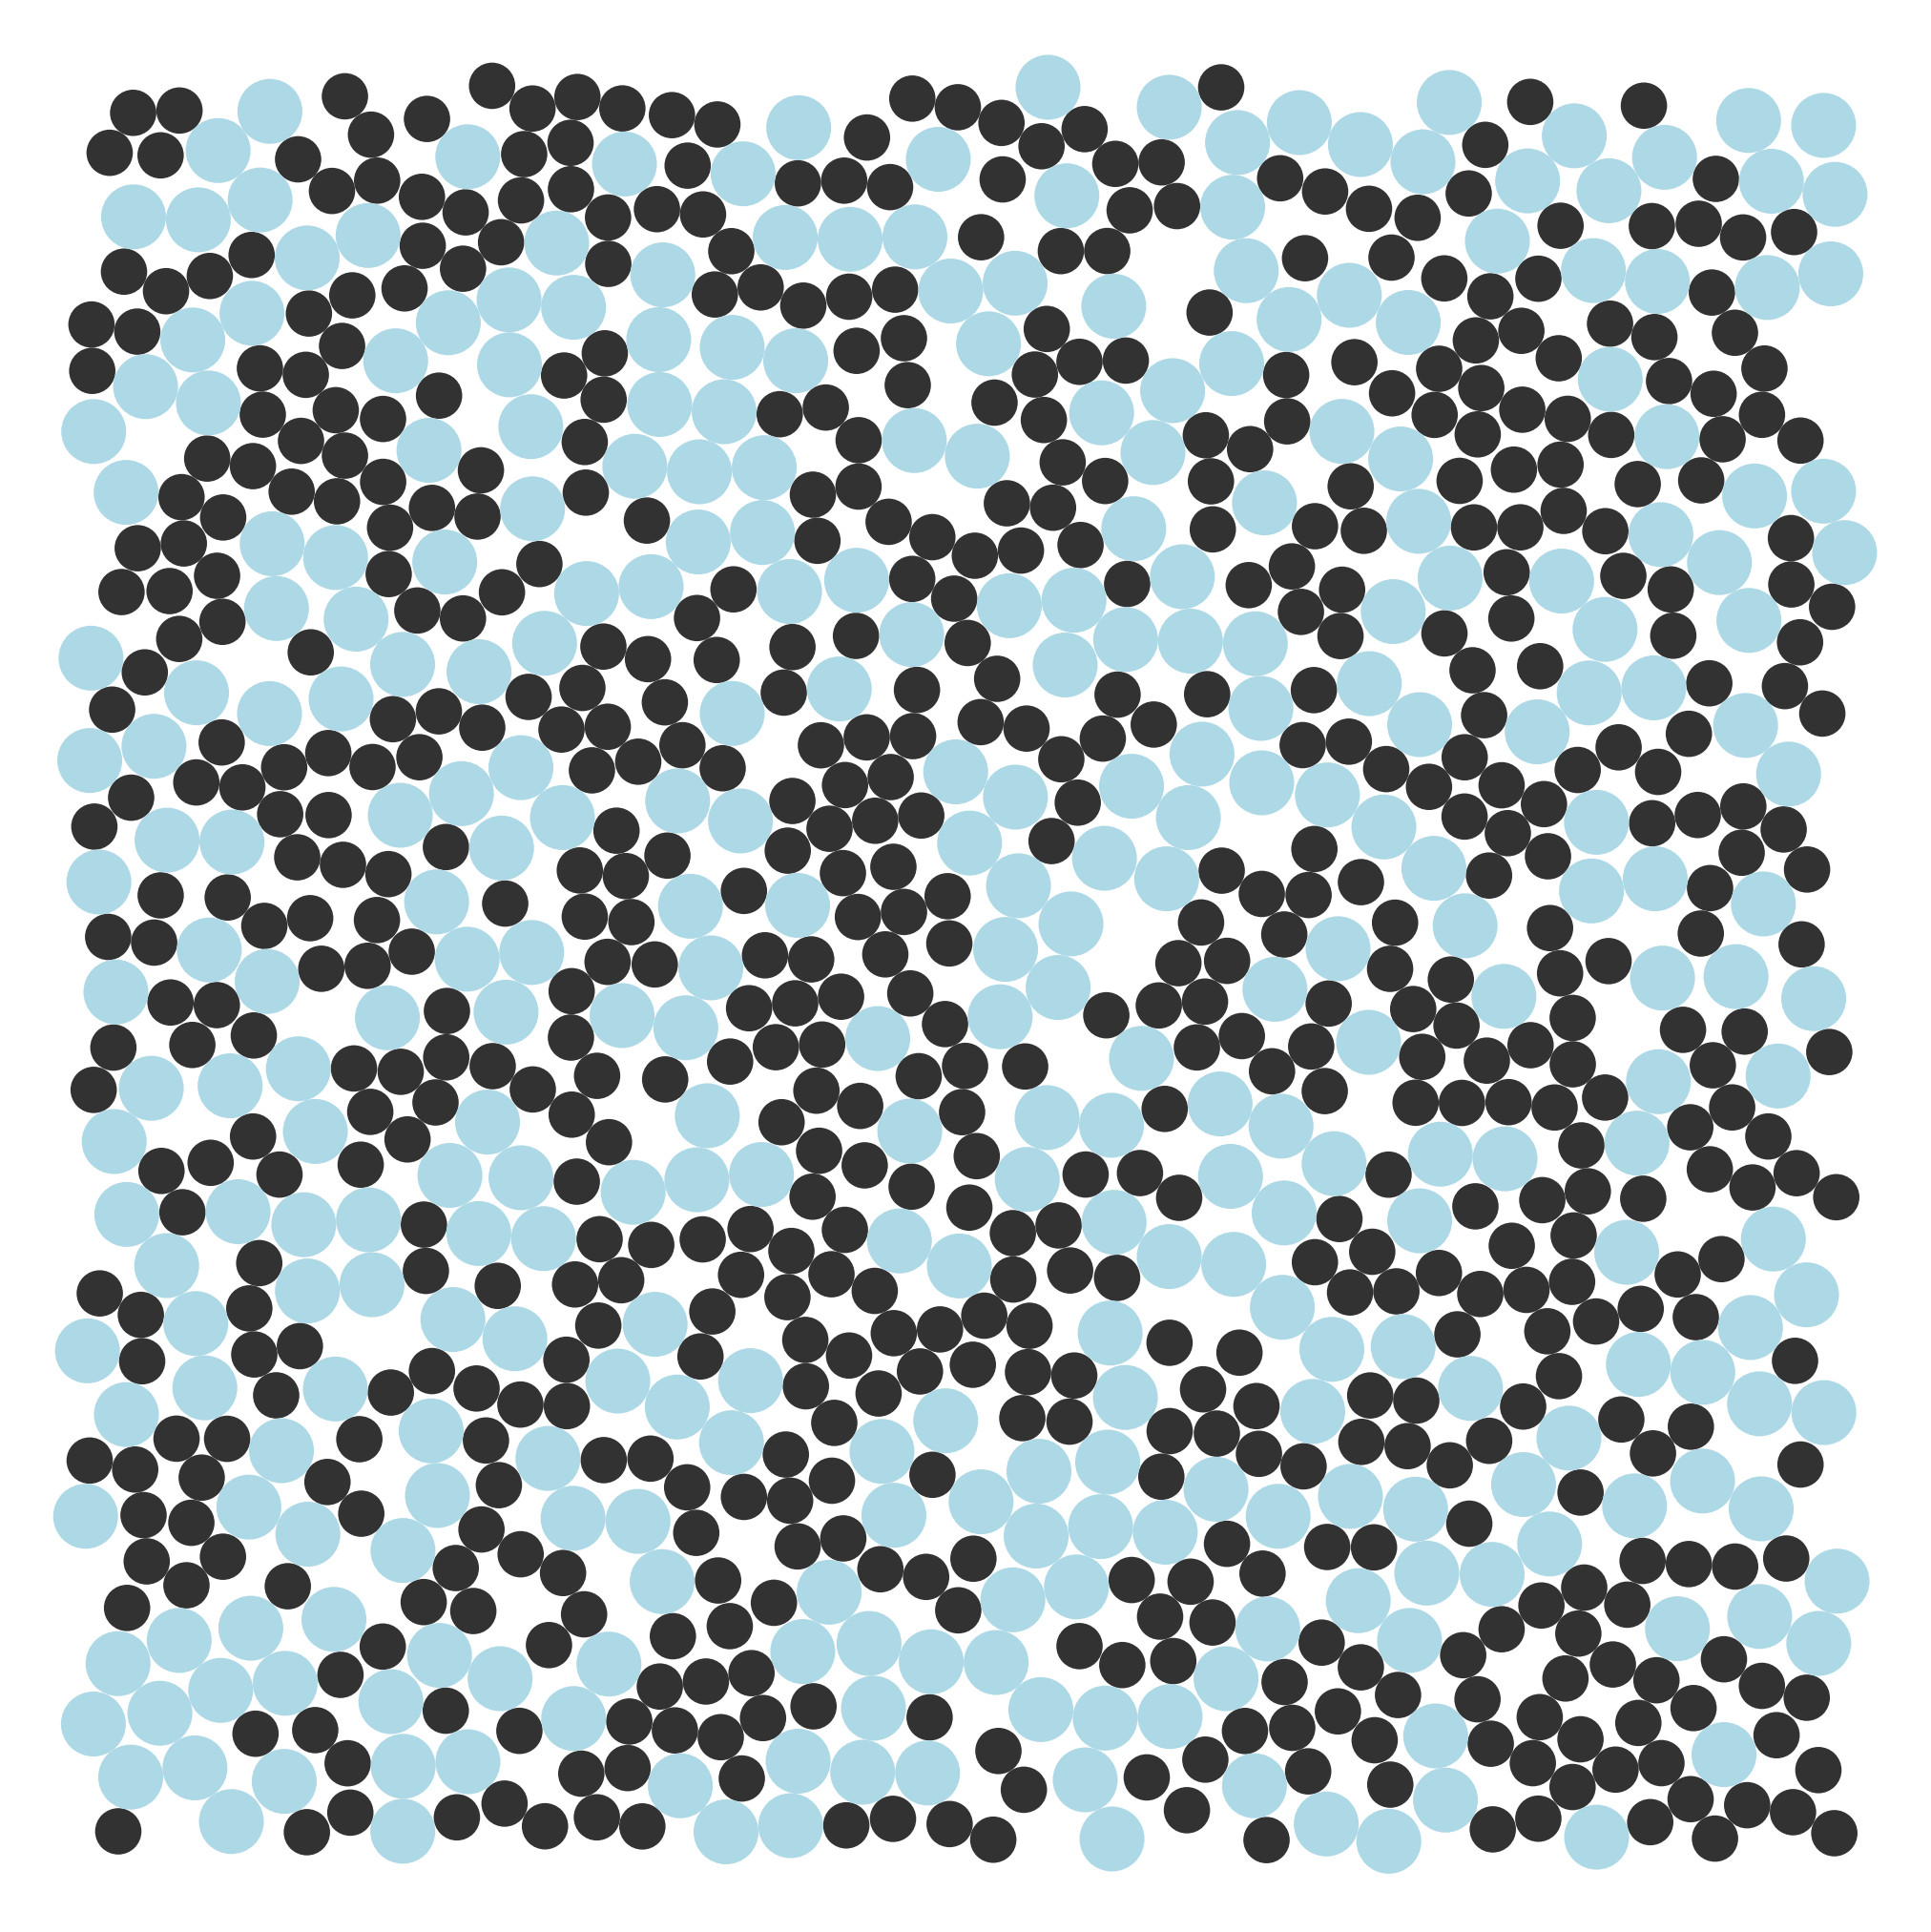

In [34]:
import colorsys
from matplotlib import colors

cmap           = matplotlib.colormaps['gist_rainbow']
alpha          = 0.75

hls            = np.array([colorsys.rgb_to_hls(*c) for c in cmap(np.arange(cmap.N))[:,:3]])
hls[:,1]      *= alpha
rgb            = np.clip(np.array([colorsys.hls_to_rgb(*c) for c in hls]), 0,1)
cmap           = colors.LinearSegmentedColormap.from_list("", rgb)

frame = 100
lx =particlesList[frame][:,2]
lz =particlesList[frame][:,3]
r  =particlesList[frame][:,1]

fig1, ax1 = plt.subplots(1,1, figsize=(5,5), dpi = 500)

a2    = np.max(r)
lxx =  76.0206

newLx = lxx + 2*a2
newLz = lxx + 2*a2

ax1.clear()
#ax1.set_title(title)
for i in range(len(particlesList[frame])):
    if r[i] == 1:
        circle = plt.Circle((lx[i],lz[i]), r[i], facecolor='#323232', fill=True, edgecolor='None')
        #ax1.add_artist(circle)
    else:
        circle = plt.Circle((lx[i],lz[i]), r[i], facecolor='#ADD8E6', fill=True, edgecolor='None')
    ax1.add_artist(circle)

ax1.set_xlim([-(newLx/2+0.2),(newLx/2+0.2)])
ax1.set_ylim([-(newLz/2+0.2),(newLz/2+0.2)])
ax1.axis('off')
ax1.set_aspect('equal')
plt.show()

In [12]:
circle = plt.Circle((lx[i],lz[i]), r[i], color='#D3D3D3', fill='#D3D3D3')
ax1.add_artist(circle)
plt.show()

In [40]:
lx =particlesList[frame][:,2]
lz =particlesList[frame][:,4]
r  =list(particlesList[frame][:,1])

In [22]:
-(newLx/2+0.2)

-38.84235

In [69]:
r[1]

1.0

In [11]:
parFile      = open(parFile1, 'r')
np.genfromtxt(parFile, comments=None, skip_header=3, max_rows=1)[2]
np.genfromtxt(parFile, comments=None, skip_header=5, max_rows=1)[2]

IndexError: index 2 is out of bounds for axis 0 with size 2

In [25]:
with open(parFile1, 'r') as particleFile:
    lines = particleFile.readlines()
    particlesList = readParFile(particleFile)

# Box dimensions.
Lx = float(lines[3].split()[2]) 
Lz = float(lines[3].split()[2])

In [26]:
len(particlesList)

5000

In [24]:
def readParFile(particleFile):
    particleFile.seek(0)
    hashCounter   = 0
    temp          = []
    particlesList = []

    fileLines = particleFile.readlines()[22:] # skipping the comment lines

    for line in fileLines:
        if not line.split()[0] == '#':
            lineList = [float(value) for value in line.split()]
            temp.append(lineList)
        else:
            # Checking if counter reaches 7 (7 lines of comments after every timestep data).
            hashCounter += 1 
            if hashCounter == 7: 
                particlesList.append(np.array(temp))
                temp        = []
                hashCounter = 0
    particleFile.close()
    return particlesList

/var/folders/7z/4v7gv78n0rq_k11539h6b9zc0000gn/T/ipykernel_46064/2718544577.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  edges = np.array(edges)


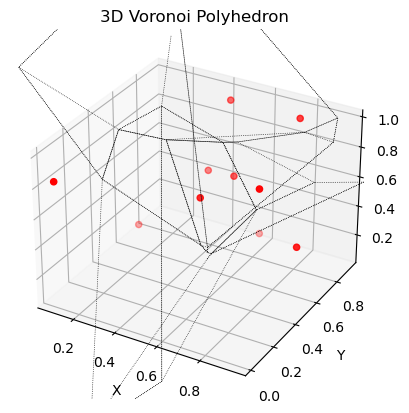

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from scipy.spatial import Voronoi

# Generate random 3D points
np.random.seed(0)
points = np.random.rand(10, 3)

# Compute Voronoi tessellation
vor = Voronoi(points)

# Visualize a specific Voronoi polyhedron (e.g., the first one)
polyhedron_index = 0

# Plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot input points
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='r', marker='o')

# Plot the selected Voronoi polyhedron
region = vor.regions[polyhedron_index]
if not -1 in region and len(region) > 0:
    vertices = vor.vertices[region]
    poly = Poly3DCollection([vertices], facecolors='cyan', linewidths=1, edgecolors='r', alpha=0.2)
    ax.add_collection3d(poly)

# Plot Voronoi edges
edges = []
for edge in vor.ridge_vertices:
    if edge[0] != -1 and edge[1] != -1:
        edges.append(vor.vertices[edge])
edges = np.array(edges)
ax.add_collection3d(Line3DCollection(edges, colors='k', linewidths=0.5, linestyles='dotted'))

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Voronoi Polyhedron')

plt.show()


In [46]:
parFile

<_io.TextIOWrapper name='/media/Linux_1TB/simulations/NP_1000/phi_0.75/ar_1.4/Vr_0.5/run_1/par_random_seed_params_stress100r_shear.dat' mode='r' encoding='UTF-8'>

In [18]:
v2

array([[4],
       [5],
       [6]])

In [21]:
v1 = np.array([1, 2, 3]).reshape(3,1)
v2 = np.array([4, 5, 6]).reshape(1,3)

In [22]:
np.dot(v1,v2)

array([[ 4,  5,  6],
       [ 8, 10, 12],
       [12, 15, 18]])

In [45]:
import os
import matplotlib                   # type: ignore
import numpy             as     np  # type: ignore
import matplotlib.pyplot as     plt # type: ignore
import random

"""
July 16, 2024
RVP

This script is to plot the force histogram wrt angular contact for different simulation parameters.
The functions here can plot angular force histograms for different size-pairs in the system

commands to run in terminal: 
All angular forces for a phi for all delta: 
python3 -c "from angularForce import angularForces; angularForces(0.70, True)"

Angular forces for all different size pairs for a phi and delta value: 
python3 -c "from angularForce import angularForcesAllSizePair; angularForcesAllSizePair(0.75, 1.4, True)"

Angular forces for a specific size pair for a phi value and all delta:
python3 -c "from angularForce import angularForcesSizePair; angularForcesSizePair(0.75, 'ss', True)"

Angular forces on a specific size for a phi value and all delta:
python3 -c "from angularForce import angularForcesOnSize; angularForcesOnSize(0.75, 'onsmall', True)"
"""

# Matplotlib rc parameters modification.
plt.rcParams.update({
  "figure.max_open_warning" : 0,
  "text.usetex"             : True,
  "text.latex.preamble"     : r"\usepackage{type1cm}",
  "figure.autolayout"       : True,
  "font.family"             : "STIXGeneral",
  "mathtext.fontset"        : "stix",
  "font.size"               : 8,
  "xtick.labelsize"         : 12,
  "ytick.labelsize"         : 12,
  "lines.linewidth"         : 1,
  "lines.markersize"        : 5
})

plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"

# Simulation data mount point and figure save path.
topDir        = "/media/rahul/Rahul_2TB/high_bidispersity/"
fig_save_path = "/home/rahul/Dropbox (City College)/CUNY/Research/Bidisperse Project/analysis/figures/angular_Force"

# Relevant file names to read.
ranSeedFile = "random_seed.dat"
intFile     = "int_random_seed_params_stress100r_shear.dat"
contFile    = 'contacts.txt'

# Some simulation parameters.
run         = {500:8, 1000:1, 2000:2, 4000:1}

ar          = [1.0, 1.4, 1.8, 2.0, 4.0]

def angularForces(phii, figsave = False):
    '''
    This function plots the sum of forces in a particular angular bin for all particles in the system and all ar values.
    Plots is fc/f0 vs theta, with one curve for each ar value for one phi value.

    input: phii - value for one single 
    '''

    plt.clf()
    cmap = matplotlib.colormaps['viridis_r'] #color scheme

    npp = 1000
    off = 100

    phii = '{:.3f}'.format(phii) if len(str(phii).split('.')[1]) > 2 else '{:.2f}'.format(phii)

    angleBins  = np.linspace(-np.pi, np.pi,72)
    #binWidth   = angleBins[1] - angleBins[0]
    binCenters = (angleBins[:-1] + angleBins[1:])/2
    
    contCount = 0
    for k in range(len(ar)):
        forceBin_Sum = [0]*len(binCenters)
        dataname     = topDir+'NP_'+str(npp)+'/phi_'+phii+'/ar_'+str(ar[k])+'/Vr_0.5'
        if os.path.exists(dataname):
            for l in range (run[npp]):
                interFile   = open(f'{dataname}/run_{l+1}/{intFile}', 'r')
                contactList = interactionsList(interFile)
                for sampleList in contactList[off:]:
                    for i in range (sampleList.shape[0]):
                        if int(sampleList[i,10]) == 2:
                            contForce = sampleList[i,11]
                            thetaRad  = np.arctan2(sampleList[i,4],sampleList[i,2])
                            updateContForce(thetaRad, binCenters, forceBin_Sum, contForce)
                            contCount += 2

        forceAvg     = np.mean(forceBin_Sum)
        forceDensity = [i/forceAvg for i in forceBin_Sum]
        plt.plot(binCenters, forceDensity, 'o', markersize = 3, label = r'$\delta$' + f' = {ar[k]}',color = cmap((k+1)/len(ar))) 

    xticks       = [-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi]
    xtick_labels = [r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$']
    plt.xticks(xticks, xtick_labels)
    plt.title(fr"$\phi = {phii}$", fontsize = 18)
    plt.xlabel(r'$\theta$',  fontsize = 14, fontstyle = 'italic')
    plt.ylabel(r'$f_c/f_0$', fontsize = 14, fontstyle = 'italic')

    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.legend(fontsize = 14)
    plt.legend(fontsize = 10, labelspacing = 1, borderpad = 1)

    plt.grid(which = 'Both', alpha = 0.2)

    plt.tight_layout()
    if figsave:
        figFormat     = ".pdf"
        #fig_save_path = "/home/rahul/Dropbox (City College)/CUNY/Research/Bidisperse Project/analysis/figures/angular_Force"
        #fig_save_path = "/media/Linux_1TB/Dropbox (City College)/CUNY/Research/Bidisperse Project/analysis/figures/angular_Force"
        plt.savefig(fig_save_path + '/angularForces_NP_' + str(npp) + '_phi_' + str(phii) + figFormat, bbox_inches = "tight", dpi = 500)

    #plt.show()

"====================================================================================================================================="

def angularForcesAllSizePair(phii, arr, figsave = False):
    '''
    This function plots angular forces for one phi value and ar value for all size pairs.
    The plots would be fc/f0 vs theta, it will have 4 curves ( 3 for different size pairs and 1 total).

    Inputs:
    phii - phi value
    arr  - ar value
    '''

    plt.clf()
    cmap = matplotlib.colormaps['viridis_r'] #color scheme

    npp = 1000 # no. of particles
    off = 100  # steady state cut off

    angleBins  = np.linspace(-np.pi, np.pi,72)
    #binWidth   = angleBins[1] - angleBins[0]
    binCenters = (angleBins[:-1] + angleBins[1:])/2

    phii = '{:.3f}'.format(phii) if len(str(phii).split('.')[1]) > 2 else '{:.2f}'.format(phii)

    forceBin_Sum = [[0]*len(binCenters) for _ in range(run[npp])] # empty nested list for all four runs 
    contCount    = [0]*run[npp]
    sizePair     = ['Total', 'SS', 'SL', 'LL']
    
    dataname     = topDir + 'NP_' + str(npp) + '/phi_' + phii + '/ar_' + str(arr) + '/Vr_0.5'
    if os.path.exists(dataname):
        for l in range (run[npp]):
            # List of particle size. List index is particle index.
            ranFile      = open(f'{dataname}/run_{l+1}/{ranSeedFile}', 'r')
            particleSize = particleSizeList(ranFile, sizeRatio = arr) 

            # Nested list of all interaction params, each list is one timestep.
            interFile   = open(f'{dataname}/run_{l+1}/{intFile}', 'r')
            contactList = interactionsList(interFile) 
           
            for sampleList in contactList[off:]:
                for i in range (sampleList.shape[0]):
                    particleSize1 = particleSize[int(sampleList[i,0])]
                    particleSize2 = particleSize[int(sampleList[i,1])]
                    contState     = int(sampleList[i,10]) # Contact state
                    contForce     = sampleList[i,11] # Norm of normal contact force
                    thetaRad      = np.arctan2(sampleList[i,4], sampleList[i,2])

                    if contState == 2:
                        # For all particles.
                        updateContForce(thetaRad, binCenters, forceBin_Sum[0], contForce)
                        contCount[0] += 2
                        
                        # Small-Small.
                        if (particleSize1 == particleSize2 == 1):
                            updateContForce(thetaRad, binCenters, forceBin_Sum[1], contForce)
                            contCount[1] += 2

                        # Small-Large
                        elif (particleSize1 != particleSize2):
                            updateContForce(thetaRad, binCenters, forceBin_Sum[2], contForce)
                            contCount[2] += 2

                        # Large-Large
                        elif (particleSize1 == particleSize2 > 1):
                            updateContForce(thetaRad, binCenters, forceBin_Sum[3], contForce)
                            contCount[3] += 2

    # Loop for plotting each size pair 
    for ii in range(len(forceBin_Sum)):
        forceAvg     = np.mean(forceBin_Sum[ii])
        forceDensity = [i/forceAvg for i in forceBin_Sum[ii]]
        #forceDensity = [i/contCount[ii]/binWidth for i in forceBin_Sum[ii]]
        plt.plot(binCenters, forceDensity, 'o', markersize = 3, label = str(sizePair[ii]), color = cmap((ii+1)/len(ar))) 

    xticks       = [-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi]
    xtick_labels = [r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$']
    plt.xticks(xticks, xtick_labels)
    plt.title(fr"$\phi = {phii},  \delta = {arr}$", fontsize = 18)
    plt.xlabel(r'$\theta$',  fontsize = 14, fontstyle = 'italic')
    plt.ylabel(r'$f_c/f_0$', fontsize = 14, fontstyle = 'italic')

    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.legend(fontsize = 10, labelspacing = 1, borderpad = 1)

    plt.grid(which = 'Both', alpha = 0.2)

    plt.tight_layout()
    if figsave:
        figFormat     = ".pdf"
        #fig_save_path = "/home/rahul/Dropbox (City College)/CUNY/Research/Bidisperse Project/analysis/figures/angular_Contacts"
        #fig_save_path = "/media/Linux_1TB/Dropbox (City College)/CUNY/Research/Bidisperse Project/analysis/figures/angular_Force"
        plt.savefig(fig_save_path + '/angularForcesAllSizePair_NP_' + str(npp) + '_phi_' + str(phii) + '_ar_' + str(arr) + figFormat, bbox_inches = "tight", dpi = 500)

    plt.show()

"====================================================================================================================================="

# (angularContactsSizePair) script for histogram of angular contacts for a size pair small-small/ small-large/ large-large for one phi value
def angularForcesSizePair(phii, sizePair, figsave = False):
    '''
    This function is for plotting histogram of angular contacts for a size pair small-small/ small-large/ large-large 
    for one phi value.
    Plots would be fc/f0 vs theta, will contain curves for all ar values for a single size pair

    Inputs:
    phii     - phi value
    sizePair - can be one of the following strings: 'total', 'ss', 'sl' or 'll'
    '''

    plt.clf()
    cmap = matplotlib.colormaps['viridis_r'] # Color scheme

    npp = 1000 # No. of particles
    off = 100  # Steady state cut off

    angleBins  = np.linspace(-np.pi, np.pi,72)
    #binWidth   = angleBins[1] - angleBins[0]
    binCenters = (angleBins[:-1] + angleBins[1:])/2

    phii = '{:.3f}'.format(phii) if len(str(phii).split('.')[1]) > 2 else '{:.2f}'.format(phii)

    for k in range(len(ar)):
        dataname = topDir + 'NP_' + str(npp) + '/phi_' + phii + '/ar_' + str(ar[k]) + '/Vr_0.5'
        if os.path.exists(dataname):
            for l in range (run[npp]):
                ranFile      = open(f'{dataname}/run_{l+1}/{ranSeedFile}', 'r')
                particleSize = particleSizeList(ranFile, sizeRatio = ar[k])

                interFile   = open(f'{dataname}/run_{l+1}/{intFile}', 'r')
                contactList = interactionsList(interFile)

                forceBin_Sum = [0]*len(binCenters) # Total number of particles in frictional contacts
                contCount    = 0
                for sampleList in contactList[off:]:
                    for i in range(sampleList.shape[0]):
                        particleSize1 = particleSize[int(sampleList[i, 0])]
                        particleSize2 = particleSize[int(sampleList[i, 1])]
                        contForce     = sampleList[i,11] # Norm of normal contact force
                        contState     = int(sampleList[i, 10]) # Contact state

                        if contState == 2:
                            thetaRad = np.arctan2(sampleList[i, 4], sampleList[i, 2])
                            if sizePair   == 'total':
                                updateContForce(thetaRad, binCenters, forceBin_Sum, contForce)
                                contCount += 2
                                plotTitle = 'Total Contacts'

                            elif sizePair == 'ss' and particleSize1 == particleSize2 == 1:
                                updateContForce(thetaRad, binCenters, forceBin_Sum, contForce)
                                contCount += 2
                                plotTitle = 'Small - Small Contacts'

                            elif sizePair == 'sl' and particleSize1 != particleSize2:
                                updateContForce(thetaRad, binCenters, forceBin_Sum, contForce)
                                contCount += 2
                                plotTitle = 'Small - Large Contacts'

                            elif sizePair == 'll' and particleSize1 == particleSize2 > 1:
                                updateContForce(thetaRad, binCenters, forceBin_Sum, contForce)
                                contCount += 2
                                plotTitle = 'Large - Large Contacts'      

        # Histogram plotting
        forceAvg     = np.mean(forceBin_Sum)
        forceDensity = [i/forceAvg for i in forceBin_Sum]
        plt.plot(binCenters, forceDensity, 'o', markersize = 3, label = r'$\delta$' + f' = {ar[k]}', color = cmap((k+1)/len(ar))) 

    xticks       = [-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi]
    xtick_labels = [r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$']
    plt.xticks(xticks, xtick_labels)
    plt.title(fr"$\phi = {phii}$, {plotTitle}", fontsize = 18)
    plt.xlabel(r'$\theta$',  fontsize = 14, fontstyle = 'italic')
    plt.ylabel(r'$f_c/f_0$', fontsize = 14, fontstyle = 'italic')

    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.legend(fontsize = 10, labelspacing = 1, borderpad = 1)

    plt.grid(which = 'Both', alpha = 0.2)

    plt.tight_layout()
    if figsave:
        figFormat     = ".pdf"
        plt.savefig(fig_save_path+'/angularForcesSizePair_' + sizePair + '_NP_' + str(npp) + '_phi_' + str(phii) + figFormat, bbox_inches = "tight", dpi = 500)

    plt.show()

"====================================================================================================================================="

def angularForcesOnSize(phii, onSize, figsave = False):
    '''
    This function is for plotting histogram of angular contact forces on a particular size particle - either small or large 
    for one phi value.
    Plots would be fc/f0 vs theta, will contain curves for all ar values for a single size.

    Inputs:
    phii     - phi value
    onSize - can be one of the following strings: 'onsmall' or 'onlarge'
    '''
    plt.clf()
    cmap = matplotlib.colormaps['viridis_r'] #color scheme

    npp = 1000
    off = 100

    angleBins  = np.linspace(-np.pi, np.pi,72)
    binCenters = (angleBins[:-1] + angleBins[1:])/2

    phii = '{:.3f}'.format(phii) if len(str(phii).split('.')[1])>2 else '{:.2f}'.format(phii)
    
    for k in range(len(ar)):
        dataname = topDir + 'NP_' + str(npp) + '/phi_' + phii + '/ar_' + str(ar[k]) + '/Vr_0.5'
        if os.path.exists(dataname):
            for l in range (run[npp]):
                ranFile      = open(f'{dataname}/run_{l+1}/{ranSeedFile}', 'r')
                particleSize = particleSizeList(ranFile, sizeRatio = ar[k])

                interFile   = open(f'{dataname}/run_{l+1}/{intFile}', 'r')
                contactList = interactionsList(interFile)

                forceBin_Sum = [0]*len(binCenters) # Total number of particles in frictional contacts
                contCount    = 0
                for sampleList in contactList[off:]:
                    for i in range(sampleList.shape[0]):
                        particleSize1 = particleSize[int(sampleList[i, 0])]
                        particleSize2 = particleSize[int(sampleList[i, 1])]
                        contForce     = sampleList[i,11] # Norm of normal contact force
                        contState     = int(sampleList[i, 10]) # Contact state

                        if contState == 2:
                            thetaRad = np.arctan2(sampleList[i, 4], sampleList[i, 2])
                            if onSize   == 'onsmall' and (particleSize1 == 1 or particleSize2 == 1):
                                updateContForce(thetaRad, binCenters, forceBin_Sum, contForce)
                                contCount += 2
                                plotTitle = 'On Small Contacts'

                            elif onSize == 'onlarge' and (particleSize1 > 1 or particleSize2 > 1):
                                updateContForce(thetaRad, binCenters, forceBin_Sum, contForce)
                                contCount += 2
                                plotTitle = 'On Large Contacts'

        # Histogram plotting
        forceAvg     = np.mean(forceBin_Sum)
        forceDensity = [i/forceAvg for i in forceBin_Sum]
        plt.plot(binCenters, forceDensity, 'o', markersize = 3, label = r'$\delta$' + f' = {ar[k]}', color = cmap((k+1)/len(ar))) 

    xticks       = [-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi]
    xtick_labels = [r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$']
    plt.xticks(xticks, xtick_labels)
    plt.title(fr"$\phi = {phii}$, {plotTitle}", fontsize = 18)
    plt.xlabel(r'$\theta$',  fontsize = 14, fontstyle = 'italic')
    plt.ylabel(r'$f_c/f_0$', fontsize = 14, fontstyle = 'italic')

    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.legend(fontsize = 10, labelspacing = 1, borderpad = 1)

    plt.grid(which = 'Both', alpha = 0.2)

    plt.tight_layout()
    if figsave:
        figFormat     = ".pdf"
        plt.savefig(fig_save_path+'/angularForcesSizePair_' + onSize + '_NP_' + str(1000) + '_phi_' + str(phii) + figFormat, bbox_inches = "tight", dpi = 500)

    plt.show()

"====================================================================================================================================="

# Below are the functions used in the above histogram functions. Esessentially to shorten it.

def updateContForce(theta, binCentersList, forceList, forceVal):
    '''
    This function is used to calulated the complementary contact angle and 
    sum-append the force for that contact to relevant list

    Inputs:
    theta          - primary contact angle. Calculated by arctan2(nz,nx)
    binCentersList - centers of bins
    forceList      - list of total forces for each bin. The force appends here at the relevant bin
    forceVal       - the value of norm of the normal contact force to be sum-appended to 'forceList'
    '''
    
    theta2 = np.pi - abs(theta) if theta < 0 else theta - np.pi
    bin_Index = np.argmin(np.abs(binCentersList - theta))
    forceList[bin_Index] += forceVal

    if bin_Index != 35:
        bin_Index2 = 36 + bin_Index if bin_Index < 35 else bin_Index - 36
        forceList[bin_Index2] += forceVal

        #old function code
    
#     theta2 = np.pi - abs(theta) if theta < 0 else theta - np.pi
#     bin_Index, bin_Index2 = np.digitize(theta, binCentersList), np.digitize(theta2, binCentersList)
#     forceList[bin_Index] += forceVal
#     forceList[bin_Index2] += forceVal
    
    
#     if theta < 0:
#         bin_Index = np.argmin(np.abs(binCentersList - theta))
#         forceList[bin_Index] += forceVal
#         theta2 = np.pi - abs(theta)
#         bin_Index2 = np.argmin(np.abs(binCentersList - theta2))
#         forceList[bin_Index2-1] += forceVal
#     else:
#         bin_Index = np.argmin(np.abs(binCentersList - theta))
#         forceList[bin_Index-1] += forceVal
#         theta2 = theta - np.pi
#         bin_Index2 = np.argmin(np.abs(binCentersList - theta2))
#         forceList[bin_Index2] += forceVal

def particleSizeList(randomSeedFile, sizeRatio, npp = 1000):
    '''
    This function reads the random seed file and creates
    a list of particle sizes. The list index is the particle index.

    Inputs:
    randomSeedFile - location for the random seed file. It contains the particle index and sizes
    sizeRatio      - delta or ar for the case
    npp            - system size
    '''

    if sizeRatio == 1:
        # Painting particles randomly in two colours for monodisperse case.
        particleSize = [1]*(int(npp/2)) + [2]*(int(npp/2))
        random.shuffle(particleSize)
    else:
        particleSize = np.loadtxt(randomSeedFile, usecols = 3) # reading only column 3 which has particle size
        randomSeedFile.close()
    return particleSize

def interactionsList(interactionFile):
    '''
    This function reads the interaction file and creates a nested-list,
    each list inside contains the array of all interaction parameters for
    that timestep.

    Input: interactionFile - the location of the interaction data file
    '''

    hashCounter = 0
    temp        = []
    contactList = [] # list with interaction parameters for each element at each timestep

    fileLines = interactionFile.readlines()[27:] # skipping the comment lines
    for line in fileLines:
        if not line.split()[0] == '#':
            lineList = [float(value) for value in line.split()]
            temp.append(lineList)
        else:
            hashCounter += 1 # checking if counter reaches 7 (7 lines of comments after every timestep data)
            if hashCounter == 7: 
                contactList.append(np.array(temp))
                temp        = []
                hashCounter = 0
    interactionFile.close()
    return contactList

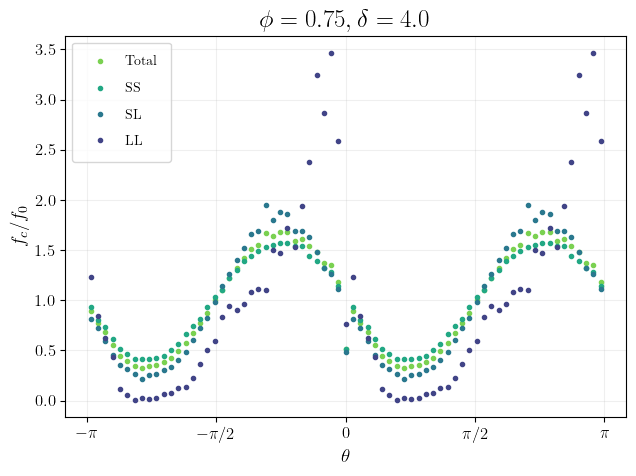

In [46]:
plt.clf()
cmap = matplotlib.colormaps['viridis_r'] #color scheme

phii = 0.75
arr = 4.0

npp = 1000 # no. of particles
off = 100  # steady state cut off

angleBins  = np.linspace(-np.pi, np.pi,72)
#binWidth   = angleBins[1] - angleBins[0]
binCenters = (angleBins[:-1] + angleBins[1:])/2

phii = '{:.3f}'.format(phii) if len(str(phii).split('.')[1]) > 2 else '{:.2f}'.format(phii)


sizePair     = ['Total', 'SS', 'SL', 'LL']
forceBin_Sum = [[0]*len(binCenters) for _ in range(len(sizePair))] 
contCount    = [0]*len(sizePair)
#sizePair     = ['Total', 'SS', 'SL', 'LL']
k1 = []
k2 = []

t1=[]
t2=[]

dataname     = topDir + 'NP_' + str(npp) + '/phi_' + phii + '/ar_' + str(arr) + '/Vr_0.5'
if os.path.exists(dataname):
    for l in range (run[npp]):
        # List of particle size. List index is particle index.
        ranFile      = open(f'{dataname}/run_{l+1}/{ranSeedFile}', 'r')
        particleSize = particleSizeList(ranFile, sizeRatio = arr) 

        # Nested list of all interaction params, each list is one timestep.
        interFile   = open(f'{dataname}/run_{l+1}/{intFile}', 'r')
        contactList = interactionsList(interFile) 

        for sampleList in contactList[off:]:
            for i in range (sampleList.shape[0]):
                particleSize1 = particleSize[int(sampleList[i,0])]
                particleSize2 = particleSize[int(sampleList[i,1])]
                contState     = int(sampleList[i,10]) # Contact state
                contForce     = sampleList[i,11] # Norm of normal contact force
                thetaRad      = np.arctan2(sampleList[i,4], sampleList[i,2])

                if contState == 2:
                    # For all particles.
                    updateContForce(thetaRad, binCenters, forceBin_Sum[0], contForce)
                    contCount[0] += 2

                    # Small-Small.
                    if (particleSize1 == particleSize2 == 1):
                        updateContForce(thetaRad, binCenters, forceBin_Sum[1], contForce)
                        contCount[1] += 2

                    # Small-Large
                    elif (particleSize1 != particleSize2):
                        updateContForce(thetaRad, binCenters, forceBin_Sum[2], contForce)
                        contCount[2] += 2

                    # Large-Large
                    elif (particleSize1 == particleSize2 > 1):
#                         theta2 = np.pi - abs(thetaRad) if thetaRad < 0 else thetaRad - np.pi
#                         bin_Index, bin_Index2 = np.argmin(np.abs(binCenters - thetaRad)), np.argmin(np.abs(binCenters - theta2))
#                         k1.append(bin_Index)
#                         k2.append(bin_Index2)
                        
#                         t1.append(thetaRad)
#                         t2.append(theta2)
                        
#                         forceBin_Sum[3][bin_Index] += contForce
#                         forceBin_Sum[3][bin_Index2] += contForce
                        updateContForce(thetaRad, binCenters, forceBin_Sum[3], contForce)
                        contCount[3] += 2

# Loop for plotting each size pair 
for ii in range(len(forceBin_Sum)):
    forceAvg     = np.mean(forceBin_Sum[ii])
    forceDensity = [i/forceAvg for i in forceBin_Sum[ii]]
    #forceDensity = [i/contCount[ii]/binWidth for i in forceBin_Sum[ii]]
    plt.plot(binCenters, forceDensity, 'o', markersize = 3, label = str(sizePair[ii]), color = cmap((ii+1)/len(ar))) 

xticks       = [-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi]
xtick_labels = [r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$']
plt.xticks(xticks, xtick_labels)
plt.title(fr"$\phi = {phii},  \delta = {arr}$", fontsize = 18)
plt.xlabel(r'$\theta$',  fontsize = 14, fontstyle = 'italic')
plt.ylabel(r'$f_c/f_0$', fontsize = 14, fontstyle = 'italic')

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 10, labelspacing = 1, borderpad = 1)

plt.grid(which = 'Both', alpha = 0.2)

plt.tight_layout()
if False:
    figFormat     = ".pdf"
    #fig_save_path = "/home/rahul/Dropbox (City College)/CUNY/Research/Bidisperse Project/analysis/figures/angular_Contacts"
    #fig_save_path = "/media/Linux_1TB/Dropbox (City College)/CUNY/Research/Bidisperse Project/analysis/figures/angular_Force"
    plt.savefig(fig_save_path + '/angularForcesAllSizePair_NP_' + str(npp) + '_phi_' + str(phii) + '_ar_' + str(arr) + figFormat, bbox_inches = "tight", dpi = 500)

plt.show()

In [35]:
np.floor(5/2)

2.0

In [38]:
binCenters[35]

0.0

In [49]:
k=os.getcwd()

In [50]:
k

'/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/Research/Bidisperse Project/analysis'

In [30]:
kk=np.random.rand(10)

In [37]:
kk[2] += 10
kk[3] += 20
kk

array([1.55324454e-01, 1.60920281e-01, 7.07738127e+01, 1.40630386e+02,
       2.73518810e-01, 9.76116430e-01, 1.34953203e-02, 4.68843846e-01,
       5.05437287e-01, 4.81554980e-01])